Introduction 
===

In this notebook we will demonstrate two methods of 

### 1. Willmore Energy Flow:

The Willmore energy is defined by: 

$$
E=\int_{M} H^{2} d A
$$

The discrete Willmore energy is defined by:

$$
E_{\text {discrete }}=\sum_{i \in V}(H N)_{i}^{2} / A_{i}
$$

Noting that
$$
\nabla E_{W}(f) = \frac{1}{4}\langle\langle\Delta f, \Delta f\rangle\rangle=\frac{1}{4}\left\langle\left\langle\Delta^{2} f, f\right\rangle\right\rangle
$$

$$
\dot{f} = -\nabla E_{W}(f) =-\frac{1}{2} \Delta^{2} f
$$

##### NOTE: This should be $C_{i}$ and not $A_{i}$? I believe this is a typo in the notes. Read the papers again.
##### NOTE 2: Why do we only devide by $C_{i}$  once; $H N)_{i}$ is the integrated mean curvature over a vertex neighbourhood, so $(H N)_{i}^{2}$ contains a factor of squared area and we cancel one of those factors out. Remember that we want to integrate mean curvature squared over the whole surface.

The change in time is defined by:
$$
\frac{d}{d t}= -\nabla_{f} E
$$


### 2. Mean Curvature Flow:

Energy defined by:
$$
E(f)=\int_{M} d A
$$

Differential energy by:
$$
\delta E=2 H N d A
$$

Surface change over time:
$$
\frac{d}{d t} f=-2 H N
$$

Discretised differential:

$$
f_{i}^{k+1}=f_{i}^{k}-\frac{\tau}{2} \sum_{i j \in \operatorname{St}(i)}\left(\cot \alpha_{i j}+\cot \beta_{i j}\right)\left(f_{j}^{k}-f_{i}^{k}\right)
$$

### 3. Gauss Energy Flow (TODO):

Energy defined by:
$$
E(f)=\int_{M} H d A
$$

Differential energy by:
$$
\delta E=K N d A
$$

Surface change over time:
$$
\frac{d}{d t} f=-K N
$$

Discretised differential:

$$
f_{i}^{k+1}=f_{i}^{k}-\frac{\tau}{2} \sum_{i j \in \mathrm{St}(i)} \frac{\varphi_{i j}}{\ell_{i j}}\left(f_{j}^{k}-f_{i}^{k}\right)
$$

In [48]:
# NOTE: CP is used for the Equation of State:
try:
    from CoolProp.CoolProp import PropsSI
except ImportError:
    import sys
    !{sys.executable} -m pip install coolprop

In [282]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
%matplotlib notebook

# Parameters for a water droplet in air at standard laboratory conditions
def eos(P=101.325, T=298.15):
    # P in kPa T in K 
    return PropsSI('D','T|liquid',298.15,'P',101.325,'Water') # density kg /m3

# Surface tension of water gamma(T)
def IAPWS(T=298.15): 
    T_C = 647.096  # K, critical temperature
    return 235.8e-3 * (1 -(T/T_C))**1.256 * (1 - 0.625*(1 - (T/T_C)))  # N/m

T_0 = 273.15 + 20  # K, initial tmeperature
T_0 = 101.325  # kPa, Ambient pressure
gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
rho_0 = eos(P=101.325, T=T_0)  # kg/m3, density
g = 9.81  # m/s2

from ddgclib import *
from ddgclib._complex import Complex
#from ddgclib.curvatures import plot_surface, curvature

# Colour scheme for surfaces
db = np.array([129, 160, 189]) / 255  # Dark blue
lb = np.array([176, 206, 234]) / 255  # Light blue



def mean_flow(HC, bV, m_0, tau=0.5, h_0=0.0, gravity_field=False):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :return:
    """
    #rint('-')
    # Define the normals (NOTE: ONLY WORKS FOR CONVEX SURFACES)
    # Note that the cache HC.V is an OrderedDict:
    N = []

    V = set(HC.V) - bV
    V_a = []
    f = []
    
    for v in V:
        f.append(v.x_a)
        
    f = np.array(f)
    #COM = numpy.average(nonZeroMasses[:,:3], axis=0, weights=nonZeroMasses[:,3])
    com = np.average(f, axis=0)
    #print(f'com = {com}')
    for v in V:         
        N.append(normalized(v.x_a - com)[0])
    
    NdA = []
    HNdA = []
    HN = []  # sum(HNdA_ij, axes=0) / C_ijk
    C = []
    for i, v in enumerate(V):
        F, nn = vectorise_vnn(v)
        try:
            c_outd = curvatures(F, nn, n_i=N[i])
        except IndexError:
            print(f'WARNING, IndexError in loop')
            c_outd = {}
            c_outd['HNdA_i'] = np.zeros(3)
            c_outd['C_ijk'] = np.array([1.0])
            c_outd['NdA_i'] = np.zeros(3)
            
        NdA.append(c_outd['NdA_i'])
        HN.append(c_outd['HNdA_i']/np.sum(c_outd['C_ijk']))
        C.append(np.sum(c_outd['C_ijk']))
        #f.append(v.x_a)

    H = np.nan_to_num(-np.array(HN))
    NdA = np.nan_to_num(np.array(NdA))
    dP = -gamma * H  # Hydrostatic pressure
    
    # Add volume perservation
    # First note that the volume gradient points in the same direction as the 
    # vector area NV (i.e. they are the same up to a constant factor).
    # Therefore we simply need to compute the different between the current 
    # volume and the equilibrium volume and add a scalar multiplier
    Rho = []
    for dp in dP:
        #p = 101.325 + dp
        p = 101.325 + np.sum(dp)  #TODO: Validate
        #print(f'p = {p}')
        rho = eos(P=p)  # kg m-3
        Rho.append(rho)
        # TODO: Compute local signed 
    Rho = np.array(Rho) 
    #print(f'Rho = {Rho}')
    V_eq = m_0/Rho  # m-3
    V_eq = np.mean(m_0/Rho)  # m-3
    print(f'V_eq = {V_eq}')
    
    N = np.array(N)
    #print(f'N_i = {N}')
    #print(f'NdA = {NdA}')
    if 0:
        print(f'np.sum(N) = {np.sum(N)}')
        print(f'np.sum(NdA) = {np.sum(NdA)}')
        print(f'np.sum(NdA*N) = {np.sum(NdA*N)}')
        print(f'NdA.dot(N) = {NdA.T.dot(N)}')
        print(f'sum NdA.dot(N) = {np.sum(NdA.T.dot(N))}')
    
    V_current = np.sum(C)/6.0
    print(f'V_current = {V_current}')
    #dV =  -(V_current - V_eq)*H
    dV = 2* 6*(V_eq - V_current)*N
    
    # Add gravity force rho * g * h (Validated)
    if gravity_field:
        h = f[:, 2] - h_0
        g_v = np.zeros_like(df)
        g_v[:, 2] = -g
        dg = rho*(h*g_v.T).T
    else:
        dg = np.zeros_like(dP)
    
    #dV = np.zeros_like(dP)
    
    df = dP + dV + dg
    #print(f'df = {df}')
    f_k = f + tau * df
    #print(f'df = {df}')
    for i, v in enumerate(V):
        #print(f'f_k[i] = {f_k[i]}')
        HC.V.move(HC.V[tuple(v.x_a)], tuple(f_k[i]))

    return HC


In [263]:
mean_flow(HC, bV, m_0, tau=0.5, h_0=0.0, gravity_field=False)

V_eq = 1.0
V_current = 0.003966690228877168


<IPython.core.display.Javascript object>


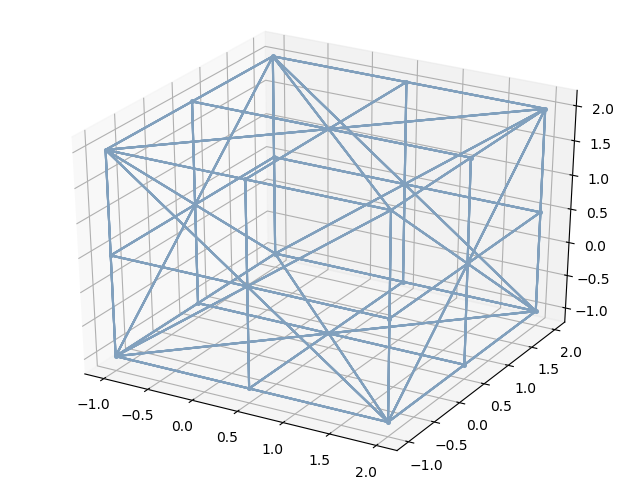

In [264]:
bounds = [(-1, 2.0),]*3
HC, bV = cube_to_drop_init(refinements=1, bounds=bounds)

V = set(HC.V) - bV
V_a = []
f = []

for v in V:
    f.append(v.x_a)

f = np.array(f)
#COM = numpy.average(nonZeroMasses[:,:3], axis=0, weights=nonZeroMasses[:,3])
com = np.average(f, axis=0)
com

V_a = []

for v in HC.V:
    V_a.append(v.x_a)
    #v.connect(HC.V[tuple(com)])


Nf = []
N = []
for v in V:         
    N.append(normalized(v.x_a - com)[0])
    Nf.append(v.x_a - com)

NdA = []
HNdA = []
HN = []  # sum(HNdA_ij, axes=0) / C_ijk
C = []
A = []
for i, v in enumerate(V):
    F, nn = vectorise_vnn(v)
    try:
        c_outd = curvatures(F, nn, n_i=N[i])
    except IndexError:
        print(f'WARNING, IndexError in loop')
        c_outd = {}
        c_outd['HNdA_i'] = np.zeros(3)
        c_outd['C_ijk'] = np.array([0.0])
        c_outd['A_ijk'] = np.array([0.0])
        c_outd['NdA_i'] = np.zeros(3)    
    
    C.append(np.sum(c_outd['C_ijk']))
    A.append(np.sum(c_outd['A_ijk']))
    #HN.append(c_outd['HNdA_i']/np.sum(c_outd['C_ijk']))

C = np.array(C)
A = np.array(A)

np.sum(C), np.sum(A)

V_a = np.array(V_a)
V_a

HC.vertex_face_mesh()
HC.vertices_fm, HC.simplices_fm, HC.simplices_fm_i

fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )


In [221]:
np.N

AttributeError: module 'numpy' has no attribute 'N'

In [265]:
np.sum(C), np.sum(C)/6.0, np.sum(A)

(54.0, 9.0, 162.0)

In [266]:
3**2

9

In [267]:
C

array([2.25  , 2.25  , 2.25  , 2.25  , 2.25  , 1.6875, 1.6875, 2.25  ,
       1.6875, 1.6875, 1.6875, 1.6875, 2.25  , 1.6875, 1.6875, 2.25  ,
       2.25  , 2.25  , 2.25  , 2.25  , 2.25  , 2.25  , 2.25  , 2.25  ,
       2.25  , 2.25  ])

In [268]:
# Droplet parameters
R = 1.0  # Radius of the droplet sphere
H_f = 1/R + 1/R
K_f = (1/R)**2
V_0 = 1.0 # m3  initial volume
m_0 = rho_0 * V_0  # kg, initial mass
r_f = ((3/(4 * np.pi))*V_0)**(1/3.0)  # V = 4/3πr3
print(f'Expected final droplet radius r_f = {r_f}')
theta = 0
phi = 0.0

Expected final droplet radius r_f = 0.6203504908994001


In [269]:
def cube_to_drop_init(refinements=2, bounds=None):
    # Initiate a cubical complex
    if bounds is None:
        bounds = [(0.0, 1.0),]*3
    HC = Complex(3, domain=bounds)
    HC.triangulate()

    for i in range(refinements):
        HC.refine_all()
        
    del_list = []
    for v in HC.V:
        if np.any(v.x_a == HC.domain[0][0]) or np.any(v.x_a == HC.domain[0][1]):
            continue
        else:
            del_list.append(v)

    for v in del_list:
        HC.V.remove(v)

    bV = set()

    return HC, bV

V_eq = 1.0
V_current = 1.0
V_eq = 1.0
V_current = 0.9916216512469731
V_eq = 1.0
V_current = 0.9845552613655242
V_eq = 1.0
V_current = 0.9785962437171737
V_eq = 1.0
V_current = 0.9735738918071553
V_eq = 1.0
V_current = 0.9693451349742502
V_eq = 1.0
V_current = 0.9657896131078457
V_eq = 1.0
V_current = 0.9628057520267862
V_eq = 1.0
V_current = 0.9603076066329658
V_eq = 1.0
V_current = 0.9582222996002816
V_eq = 1.0
V_current = 0.9564879268503855
V_eq = 1.0
V_current = 0.9550518325694011
V_eq = 1.0
V_current = 0.9538691795594864
V_eq = 1.0
V_current = 0.9529017577274425
V_eq = 1.0
V_current = 0.9521169861841349
V_eq = 1.0
V_current = 0.951487073955598
V_eq = 1.0
V_current = 0.950988311535327
V_eq = 1.0
V_current = 0.9506004710425597
V_eq = 1.0
V_current = 0.9503062970293096
V_eq = 1.0
V_current = 0.9500910733159259
V_eq = 1.0
V_current = 0.9499422538620484
V_eq = 1.0
V_current = 0.9498491477669694
V_eq = 1.0
V_current = 0.9498026501663123
V_eq = 1.0
V_current = 0.9497950121442926
V_eq = 1.

V_current = 0.9582320074505573
V_eq = 1.0
V_current = 0.9582356480870201
V_eq = 1.0
V_current = 0.9582392045691869
V_eq = 1.0
V_current = 0.9582426788991191
V_eq = 1.0
V_current = 0.9582460730300048
V_eq = 1.0
V_current = 0.9582493888673614
V_eq = 1.0
V_current = 0.9582526282702123
V_eq = 1.0
V_current = 0.9582557930522341
V_eq = 1.0
V_current = 0.9582588849828778
V_eq = 1.0
V_current = 0.9582619057884605
V_eq = 1.0
V_current = 0.9582648571532321
V_eq = 1.0
V_current = 0.9582677407204168
V_eq = 1.0
V_current = 0.9582705580932279
V_eq = 1.0
V_current = 0.958273310835859
V_eq = 1.0
V_current = 0.95827600047445
V_eq = 1.0
V_current = 0.9582786284980319
V_eq = 1.0
V_current = 0.9582811963594438
V_eq = 1.0
V_current = 0.9582837054762329
V_eq = 1.0
V_current = 0.9582861572315285
V_eq = 1.0
V_current = 0.9582885529748953
V_eq = 1.0
V_current = 0.9582908940231679
V_eq = 1.0
V_current = 0.9582931816612605
V_eq = 1.0
V_current = 0.9582954171429606
V_eq = 1.0
V_current = 0.9582976016917008
V_eq =

V_eq = 1.0
V_current = 0.9583914467367342
V_eq = 1.0
V_current = 0.9583914910925982
V_eq = 1.0
V_current = 0.9583915344988716
V_eq = 1.0
V_current = 0.958391576975994
V_eq = 1.0
V_current = 0.9583916185439615
V_eq = 1.0
V_current = 0.958391659222336
V_eq = 1.0
V_current = 0.958391699030256
V_eq = 1.0
V_current = 0.9583917379864441
V_eq = 1.0
V_current = 0.9583917761092176
V_eq = 1.0
V_current = 0.9583918134164966
V_eq = 1.0
V_current = 0.9583918499258134
V_eq = 1.0
V_current = 0.9583918856543202
V_eq = 1.0
V_current = 0.9583919206187975
V_eq = 1.0
V_current = 0.9583919548356635
V_eq = 1.0
V_current = 0.95839198832098
V_eq = 1.0
V_current = 0.9583920210904616
V_eq = 1.0
V_current = 0.958392053159483
V_eq = 1.0
V_current = 0.9583920845430862
V_eq = 1.0
V_current = 0.9583921152559883
V_eq = 1.0
V_current = 0.9583921453125881
V_eq = 1.0
V_current = 0.9583921747269731
V_eq = 1.0
V_current = 0.9583922035129256
V_eq = 1.0
V_current = 0.9583922316839323
V_eq = 1.0
V_current = 0.958392259253186

V_eq = 1.0
V_current = 0.9583934958486683
V_eq = 1.0
V_current = 0.958393496490332
V_eq = 1.0
V_current = 0.9583934971183897
V_eq = 1.0
V_current = 0.9583934977331298
V_eq = 1.0
V_current = 0.9583934983348349
V_eq = 1.0
V_current = 0.9583934989237822
V_eq = 1.0
V_current = 0.9583934995002418
V_eq = 1.0
V_current = 0.9583935000644784
V_eq = 1.0
V_current = 0.9583935006167522
V_eq = 1.0
V_current = 0.9583935011573157
V_eq = 1.0
V_current = 0.9583935016864186
V_eq = 1.0
V_current = 0.9583935022043035
V_eq = 1.0
V_current = 0.9583935027112083
V_eq = 1.0
V_current = 0.9583935032073659
V_eq = 1.0
V_current = 0.9583935036930046
V_eq = 1.0
V_current = 0.9583935041683468
V_eq = 1.0
V_current = 0.9583935046336123
V_eq = 1.0
V_current = 0.9583935050890134
V_eq = 1.0
V_current = 0.9583935055347602
V_eq = 1.0
V_current = 0.9583935059710572
V_eq = 1.0
V_current = 0.9583935063981049
V_eq = 1.0
V_current = 0.9583935068160997
V_eq = 1.0
V_current = 0.958393507225233
V_eq = 1.0
V_current = 0.95839350762

V_current = 0.9583935256670006
V_eq = 1.0
V_current = 0.9583935256766462
V_eq = 1.0
V_current = 0.9583935256860873
V_eq = 1.0
V_current = 0.9583935256953283
V_eq = 1.0
V_current = 0.9583935257043737
V_eq = 1.0
V_current = 0.9583935257132276
V_eq = 1.0
V_current = 0.9583935257218937
V_eq = 1.0
V_current = 0.9583935257303766
V_eq = 1.0
V_current = 0.9583935257386796
V_eq = 1.0
V_current = 0.958393525746807
V_eq = 1.0
V_current = 0.9583935257547621


<IPython.core.display.Javascript object>


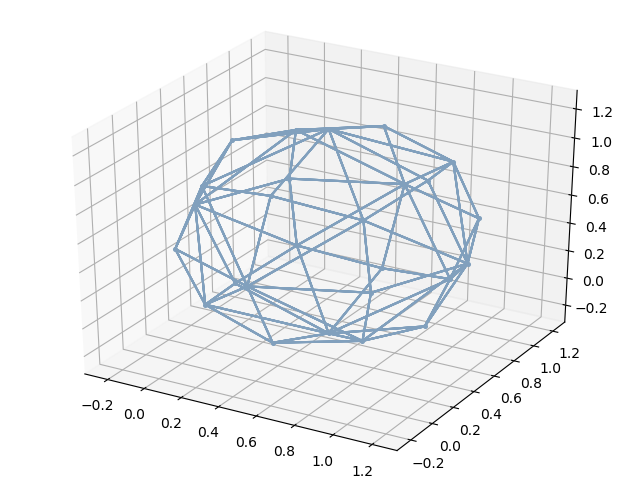

In [271]:
# Initiate a cubical complex
HC, bV = cube_to_drop_init(refinements=1)

#for i in range(150):
for i in range(800):
    HC = mean_flow(HC, bV, m_0, tau=0.01)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

V_eq = 1.0
V_current = 1.0
V_eq = 1.0
V_current = 0.9845453071382662
V_eq = 1.0
V_current = 0.9720571136074098
V_eq = 1.0
V_current = 0.9620154627132874
V_eq = 1.0
V_current = 0.9539998842691939
V_eq = 1.0
V_current = 0.9476669559590096
V_eq = 1.0
V_current = 0.9427337931356871
V_eq = 1.0
V_current = 0.9389657142541769
V_eq = 1.0
V_current = 0.9361668882241471
V_eq = 1.0
V_current = 0.9341731381130716
V_eq = 1.0
V_current = 0.9328463228640848
V_eq = 1.0
V_current = 0.9320698877163065
V_eq = 1.0
V_current = 0.931745291373513
V_eq = 1.0
V_current = 0.9317891004712999
V_eq = 1.0
V_current = 0.9321306003918233
V_eq = 1.0
V_current = 0.9327098131101067
V_eq = 1.0
V_current = 0.9335210214771887
V_eq = 1.0
V_current = 0.9346793089369445
V_eq = 1.0
V_current = 0.935940184428731
V_eq = 1.0
V_current = 0.9372707236748322
V_eq = 1.0
V_current = 0.9386429521105343
V_eq = 1.0
V_current = 0.9400332030358959
V_eq = 1.0
V_current = 0.9414215717491207
V_eq = 1.0
V_current = 0.9427914518798275
V_eq = 1.

V_eq = 1.0
V_current = 0.959193448355763
V_eq = 1.0
V_current = 0.9592000699021357
V_eq = 1.0
V_current = 0.9592067152355869
V_eq = 1.0
V_current = 0.9592133836480002
V_eq = 1.0
V_current = 0.959220074402265
V_eq = 1.0
V_current = 0.9592267867309028
V_eq = 1.0
V_current = 0.9592335198346359
V_eq = 1.0
V_current = 0.9592402728809012
V_eq = 1.0
V_current = 0.9592470450023001
V_eq = 1.0
V_current = 0.9592538352949828
V_eq = 1.0
V_current = 0.9592606428169689
V_eq = 1.0
V_current = 0.9592674665863933
V_eq = 1.0
V_current = 0.9592743055796781
V_eq = 1.0
V_current = 0.9592811587296279
V_eq = 1.0
V_current = 0.9592880249234405
V_eq = 1.0
V_current = 0.959294903000632
V_eq = 1.0
V_current = 0.9593017917508715
V_eq = 1.0
V_current = 0.9593086899117179
V_eq = 1.0
V_current = 0.9593155961662593
V_eq = 1.0
V_current = 0.9593225091406459
V_eq = 1.0
V_current = 0.9593294274015097
V_eq = 1.0
V_current = 0.9593363494532711
V_eq = 1.0
V_current = 0.9593432737353186
V_eq = 1.0
V_current = 0.959350198619

V_eq = 1.0
V_current = 0.9646271093477594
V_eq = 1.0
V_current = 0.9544073836835419
V_eq = 1.0
V_current = 0.9658372530126579
V_eq = 1.0
V_current = 0.9594512554876328
V_eq = 1.0
V_current = 0.9773803125964254
V_eq = 1.0
V_current = 1.010169772301368
V_eq = 1.0
V_current = 0.963468726776116
V_eq = 1.0
V_current = 0.9305148928098546
V_eq = 1.0
V_current = 0.9687371949409688
V_eq = 1.0
V_current = 0.9894996373528643
V_eq = 1.0
V_current = 0.9736253350191048
V_eq = 1.0
V_current = 1.0182446030524446
V_eq = 1.0
V_current = 1.080659594937808
V_eq = 1.0
V_current = 1.0432476568657312
V_eq = 1.0
V_current = 1.0007371838490378
V_eq = 1.0
V_current = 0.989277721516177
V_eq = 1.0
V_current = 0.9537700942936264
V_eq = 1.0
V_current = 1.0108273895677329
V_eq = 1.0
V_current = 0.9475298104663811
V_eq = 1.0
V_current = 0.9861325195724143
V_eq = 1.0
V_current = 0.9273945012823298
V_eq = 1.0
V_current = 0.9578652872866632
V_eq = 1.0
V_current = 0.9411882520140981
V_eq = 1.0
V_current = 0.9926687182456

<IPython.core.display.Javascript object>


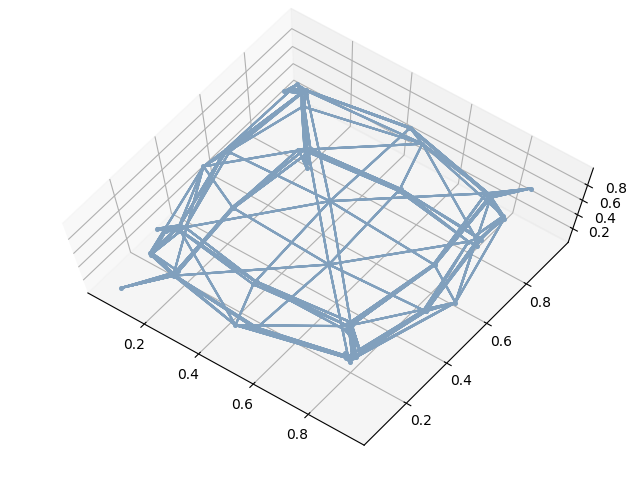

In [276]:
# Initiate a cubical complex
HC, bV = cube_to_drop_init(refinements=2)

#for i in range(150):
for i in range(500):
    HC = mean_flow(HC, bV, m_0, tau=0.01)
    for j in range(10):
        HC = regularize(HC, bV)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA10dzkAAAgAElEQVR4Xuy9Z3QV6ZXuvxEgQCKKjMhJ5JwbaHJ3uwPdbtvtNG6HCc5ue+787+f5MrPunWuP7XHbnvHY4xy73TkSmtjkKEDknHNGgBD/9SvxSqU6VafiOTqS9ruWlkCn6g3PW6fqqR2e3eT+/fv3RZsioAgoAoqAIqAIKAKKQKNBoIkSwEaz17pQRUARUAQUAUVAEVAELASUAOqFoAgoAoqAIqAIKAKKQCNDQAlgI9twXa4ioAgoAoqAIqAIKAJKAPUaUAQUAUVAEVAEFAFFoJEhoASwkW24LlcRUAQUAUVAEVAEFAElgHoNKAKKgCKgCCgCioAi0MgQUALYyDZcl6sI5CICRo2qSZMmuTg9nZMioAgoAg0OASWADW5LdUGKQP1CoLKyUm7duiV37tyRVq1aSX5+vuTl5dWvRehsFQFFQBGoZwgoAaxnG6bTVQQaEgL37t2Tu3fvWj8QQIgfPy1btrSIoFoEG9Ju61oUAUUglxBQAphLu6FzUQQaEQKG/OH+xQoICYT88Xf+1qxZM4sINm/eXIlgI7oudKmKgCKQHQSUAGYHZx1FEVAEbAhA8rD40bDyQfhu374tTZs2tf7G/zmGBhFs0aKFEkG9ghQBRUARSBABJYAJgqldKQKKQHoEDLHD2mfIHwQQC6BxAdt7sBNBLIEQQQihuob1SlMEFAFFIB4CSgDj4adnKwKKQEAEvMgfp3sRQNM1n2MRhPhBBHENYy1UIhgQfD1MEVAEFAEHAkoA9ZJQBBSBjCMA+auoqLB+aM4sXz8CaCeCHEsjScRYBDO+AB1AEVAEFIEGhoASwAa2obocRSDXEPAjf0EsgPY10Z+xJkIkDRE08YO5tn6djyKgCCgCuYiAEsBc3BWdkyLQQBCAqBHvZ9y3Xi7boBbAdEQQayA/qiHYQC4eXYYioAhkFAElgBmFVztXBBovAkHJX1gLoBNRIyMDicQKaCyCSgQb77WnK1cEFAF/BJQA+mOkRygCikBIBAz5I+YPIuaXrGEsgBznd6zXVJxEUMWkQ26aHq4IKAKNCgElgI1qu3WxikDmEQhL/uwWwDgE0KzMxAcaMWncwlpVJPP7riMoAopA/UJACWD92i+drSKQ0whAutDzI+YviOXPTtrswtBJLNKuIYhrWKuKJIGq9qEIKAINBQElgA1lJ3UdikAdI2DKuYUlf0zbEEf+HdUF7LV8Z1URiKCKSdfxxaLDKwKKQJ0joASwzrdAJ6AI1H8ETAwfZCuKGzeTBNBuZTTl5bSqSP2/5nQFioAiEA8BJYDx8NOzFYFGj4Ahf/wO4/a1A2fiBg2BzCSo9qoiKiadSaS1b0VAEchlBJQA5vLu6NwUgRxHIAnyxxKzSQANpIYIqph0jl9kOj1FQBHICAJKADMCq3aqCDR8BHCnIvIcx/Jnd8/SVzYsgE7Lo1YVafjXqq5QEVAEUhFQAqhXhSKgCIRGwJC/qDF/zgGNBdCQydATinmCiknHBFBPVwQUgXqHgBLAerdlOmFFoG4RgPzZJVuSyNqtawJot0RCQk1VEaMhqFVF6vaa09EVAUUgeQSUACaPqfaoCDRIBIyrFFctLUq2rxcw5eXlsnnzZiksLJR+/fpZmn112bSqSF2ir2MrAopANhBQApgNlHUMRaCeI5BJ8nfjxg3ZsGGDdOjQQSgdd+HCBenZs6f06dNHkGupy+asKqJi0nW5Gzq2IqAIJImAEsAk0dS+FIEGiAAkCGLGDy1Jd+i1a9dk48aN0r17d+nfv7/leoUQHjhwQK5cuSK9e/eWXr16WcLNddmcYtK4hiGnSbi/63JdOrYioAg0XgSUADbevdeVKwK+CGSS/EHwIH9Y+gYMGGCVj4NkGoJ56dIliwjeunVL+vbtK8XFxYmST9/FuxxgJ4IqJh0FQT1HEVAEcgUBJYC5shM6D0UgxxAwiRkQsyTj/VjmxYsXrZi/gQMHWuSOZjKL7RZG5nD+/Hk5ePCg9Tnxgd26datzy5ubmDT1htUimGMXsU5HEVAEPBFQAqgXhyKgCKQgkEnyd+7cOdm6dasMHTrUivUzDesfCSYQKWdjPqdPn5ZDhw5Zn+Mu7tSpU50TLpMxzHypKkKMoNv89RJTBBQBRSDXEFACmGs7ovNRBOoYAUP+jDs2SasWJK60tFRGjBhhxf3ZWzoCaI6DcJ08edIigq1atbJcxySP1GUDLxWTrssd0LEVAUUgCgJKAKOgpucoAg0UgUySv+PHj0tZWZmMHj1aunTpkoKg0RcMYkGDLB47dkyOHj0q7dq1s4hgmzZt6nRXVEy6TuHXwRUBRSAkAkoAQwKmhysCDRUBCAwCzxAx4vCStPwdPnxY9u/fL+PGjZOioiJXCLHu3b59O5QLFZfxkSNHBHKJSxjXcEFBQZ1ukZMIqph0nW6HDq4IKAIeCCgB1EtDEVAELPkVyFTS5A8yRCYvJG38+PHSvn17T7SZAwQ0iswMxBG3MC5mkkRILMkVMWkwYE3MhzjBJIm1XrqKgCKgCERFQAlgVOT0PEWggSBgiFdSdX0NLPS3Z88eK2Zv4sSJvi7aOATQjHnz5k0rY5jMYRWTbiAXqC5DEVAEMoKAEsCMwKqdKgL1AwFDuvidpNsX8rdz506LiEH+KPHm15IggGYMBKZVTNoPcf1cEVAEGjMCSgAb8+7r2hs1Apkif/RLpi9Cz5A/snWDtCQJoBkv18WkcQcTs6hVRYJcIXqMIqAIJImAEsAk0dS+FIF6goARXU7a8ke/aPyVl5fLhAkThASIoC0TBJCxc1lMevny5RZObdu2rdYQ1BjBoFeMHqcIKAJxEFACGAc9PVcRqIcIGPKXdMwf0ixU94DIkfCBVStMMwQw6aojZg65JibNfD744AOZMmWKlRxC4zekua5rH4fZNz1WEVAE6icCSgDr577prBWBSAgYrT1OTpJokUFMXV+Iy9ixYyMRmEwTQANYrohJM49ly5bJ9OnTLbKsYtKRLmk9SRFQBCIioAQwInB6miJQ3xAwlTaSJn9IsED+iPVD5DmIkLMbdhAg+kqSmKbbI/BAPxCJmroQk2b8FStWyMyZM6sJs1tVEeRjokjj1LfrU+erCCgC2UVACWB28dbRFIGsI2AsS1jpkiZ/t27dkg0bNlgEauTIkbGICvMkdjDJbOQgYNeVmDSah6tWrZKHH344hTRrVZEgO6fHKAKKQBwElADGQU/PVQRyHAGIBJYmfmhJWpJu3Lhhkb/OnTvLsGHDYgscU9qNUnEIOffr1y9UAkkS25BtMWnI7ocffiizZ8/2xM5JBFVMOomd1j4UAUXAMgbc5w6jTRFQBBocApkkf+jsQf6Ki4tl8ODBscmfKRU3aNAgSzvwwoULdSbknC0xaayna9eutQigXzNWXH4TZ2nKy2nGsB9y+rkioAh4IaAEUK8NRaABIgBRMKXdkrb8Xb58WTZt2mSVW6P2bhwS4iwVhyYefzNCzvzu3bu39OrVK3JsYdTtzbSYNBZUYidxAQdthghyPLGWWARVQzAoenqcIqAI2BFQAqjXgyLQwBCwk7+kEyqwzCH1gtWvT58+sZAzpeJOnTplaeG1bt3aIq1GnobOL168aFX0wD0L4ezRo0eibuwgC8iUmDQEc8uWLVYSSNhmJ4JYBCGC/I5DxsPOQY9XBBSB+o2AEsD6vX86e0WgFgKZJH9nz56Vbdu2ydChQy33bJzmVirOzN1OABmD/587d86q8Yt0ClbHrl27ZpXsZEJMmkopVExBBiZqsxNBLIFGQ1CJYFRE9TxFoPEgoASw8ey1rrSBI2AIFAkfSWfSYqXbsWOHlelLkkacBonbvn275ealVBzWK0P0sACa6iTOMfj76dOn5dChQ5bbEyLYsWPHrBNBMwdcsMyhU6dOkeaAK33Xrl0ybdq0OHBa54INGo8QPyMmzfyUCMaGVjtQBBosAkoAG+zW6sIaEwLGQnX06FEZPnx4og9+snN3794tY8aMsTJ+47R0peIMgfUigGZc+jhx4oSl30fM4IABA6R9+/ZxphX63CTEpHFv792716oEklSzE0GsgfxE1WVMak7ajyKgCOQmAkoAc3NfdFaKQGAEIE5oykEoqMM7Z86cwOf6HWiyc8eNGydFRUV+h6f9PEipOJO4EkSuhv4gvBBUCCBEkDjCbLY4YtJkOxPfOHny5ESn7CYmrUQwUYi1M0WgQSCgBLBBbKMuorEiYMqnmSoay5cvlwULFsROlKC//fv3WwSLBA2EnuO0oKXiwhBAMx/IL0T15MmTloUStyxVSbLZoohJE1OJFRM3eCaaiklnAlXtUxFoOAgoAWw4e6kraWQIGPJnXKY88N9//32ZNWtWdVxdFEjoB5cvsW6QvzZt2kTppvocUyqOWD/cyOlcklEIoBkIXT3iAyFW3bt3t7KGsXxls4URkz5z5oxVim78+PEZnaKTCBoNwSBW1oxOTDtXBBSBOkVACWCdwq+DKwLREHCSPxPsv2TJklgWO5Odi9wLlili7OI0SBlad23btg1UKs5ULYlDTq5fv25lDCPfQrYycjVIpGSzBRGTJrGGH9zr2WhaVSQbKOsYikD9QUAJYP3ZK52pImAhQBKEPVvWnulJbdmSkpJIyRpe2blRYTel4siSDZqYYtYWhwCa+SKzQowdhBASCBnMdkJEOjFpElmQt8Eqms3mrCqiYtLZRF/HUgRyBwElgLmzFzoTRcAXAUOQjFaeU+aD8my4P8Pq9JnsXFyYuH2REonTID5Y/pgLhDSoHAkWQMhtUkQNnIyYNP3iFmZOSRDMMPi4iUlDAPn7qFGjwnSV2LFOMWlcw1pVJDF4tSNFIOcRUAKY81ukE1QEqhDwI38cg75eYWGhlREbtAXJzg3aF8dheYP8YXVjHkHJH+cmTQDNvCE7xAbiGmY+JIqQMBJmbmEwcDvWKSaNW5y/oa1Yl03FpOsSfR1bEag7BJQA1h32OrIiEBgBQ4w4IV15N5I3cOUOGzYsUN9k0FLXlxi5sWPHxo6Vw9pGqbiBAwda1rawDZLLnJKyADrHBxvi7kgWweIFEUTeJttEkASbffv2WQSQvYoqJh0W33THq5h0kmhqX4pA7iOgBDD390hn2IgRMNYZ3Jd+5I/PITZY4ILEleHuxWWMxXD06NGx3aLEs6FDOGTIEOnVq1ekXYOEMK9MEUAzKYgmGbjIsKAdiKUyrtRN2AUTn4gLmEQZZGuYQ4cOHcJ2k/jx7AE/NEIBiBHM9H4kvgjtUBFQBHwRUALoC5EeoAjUDQKQP5MVywyCxK2hhYcwsp+4MKQD8oeA8ogRIwL1nQ4FLFrUtaUvYuyiNpPdHGStUcewnwexRusQMgj5goRBiLPR0FmEiDKmIaOQUP4fV3on7vxVTDougnq+IpD7CCgBzP090hk2QgSikD9gQr5l586dMnPmTE/UyIolRq9Lly4ydOjQ2O5PkhmoaYsVkT6jNiM+TYUMXLPZtIZhdURMGvcwa+jXr1/GxaRxAdMGDRpk/Y4iJh0V66Dn2aVjIOWmvFy2CHrQeepxioAiEB4BJYDhMdMzFIGMImBq4mIdooV52JJ9u3btWpk/f77rHK9evWqRv+LiYhk8eHBs8ocLlXq2aNl17NgxMi528emuXbtatX7rwhqGfh9udNzZYEQiS9yMaC9Q9uzZY7lWiZe0tzBi0pEBD3miVhUJCZgergjUAwSUANaDTdIpNh4E7OQvXbKHFyIkUCxdulTmzZuXktBBvBkJH1jX+InbiGGDLCEbgys5arOLT1MVg4QUyC/kEtcoCRLMN64odZj5YSVlfZcvX7biGXv37h07QcY5fllZWXUiitvcgohJh1lTEscaIshvXkyID4QgZzOJJol1aB+KgCIgogRQrwJFIEcQiEv+WIYpBzdjxoxahAnXMNm5aPJBZuI0xsDqh5UO8oecSdTmFJ+GTEBijdWzvLzccs0SY9itWzfLNZvN8m4QQIggZIys5h49eiSWEIGrnnhDv2zpdGLSUXGPe55TTNqUl1MiGBdZPV8RyB4CSgCzh7WOpAh4ImDIH0kfkJ84D9Jly5ZZ8Xgmhg79u23btllyI7g14zTmieWKPiF/ZNBGbUZ8GpJHX5AIkwTitH5SVQRrI/GBprwbosXZaKwZAo2GIHF6kFDIaBjXvNs8d+zYYZHnoITcTUw67hzi4mfXEMSdrVVF4iKq5ysC2UNACWD2sNaRFAFXBHiIYvWCEMUlfwywZs2aapJCVjCWJsSGIS1xGuQM0oJVjDrBSJdEbV7i014E0IxDDCMWOaxi2S7vxj6dOXPGIoLsE9m6cfT7EO2GpIeRzHGKSRsyGueFIeoe2s9zVhWBCOLKr+t5JbE27UMRaKgIKAFsqDur66oXCCRN/lg0cX4QE0gKwtAIPPP/OA1ihhURSxzWOh7wURtWNBJRsBiRPAJRMA08SILwi3805d04FhKUzfJuYAGxxjUNDkZMOiweaCZSjSSKVRaccItjFQVH5hCHjIadu9fxJnud/cNCazQElQgmhbD2owgkh4ASwOSw1J4UgVAIQCQgQ/z2IzxhOsZKR8wa1jKSKuLKqWCZ3LJlizVX+ouTFQthg/xBDBCrdgoMG0LMev1IA8eSrYtFjn9DgpBw8TsvDJbpjgUXNBfREUS3D4tgmHhIYjIhrnF1EyGjEMFcFpPGvW8n+kntgfajCCgC0RFQAhgdOz1TEYiMgHF18jsJt6/dgrZ+/XqrGghi0HGrW0D6ICo0k6EbddHE+iE+DVkaNWqUawxdGAJo5gGGxhqG1Qkils3ybk79PiySQcSksdQSz4jsTdyGSz3XxKRZkykvxzXOiwNEUKuKxN1tPV8RSAYBJYDJ4Ki9KAKBEcgk+cPlS3YuJMuvGojfhIlLxFrHgxs3cpwHNxZJyB9agcOHD/e00kUhgGYdWORYO67ZuijvZtfvg9RBBNO5ysGDOMY44tnOPcxVMWn2lb3hGiLmEVzqOoHF7/rXzxWBho6AEsCGvsO6vpxCIJPkD9cvsXEQD6xB06ZNi7x2rHWQvyTqBKOpB9khCYU6welctCYbmt9RXblYw3DL4p7F/Y1rOE62clgQg+r3rVu3rjqRJOwYfsfnopg0yUhoOWL1hAgai6ASQb/d1M8VgcwgoAQwM7hqr4pACgJYqEzMX5JuX6OlB9EiQYM6vyQYzJ49O9IuGGsdblSsdXEe0LiiIZJInVDxwo/UJUEAzaKxYGINJEYuW+Xd7ID76fdRsYVqLOCcqRaUjGZqfHu/JuaRFwGuWX7s0jFxrrNszF/HUAQaGgJKABvajup6chIBQ/6MZcuPCAVdhEnQgOxA/rCq8NBfuXKlLFiwwJdwOccx1jpcmHHrBJvKI8TkYZUM0gwBNLGRQc7xOwZCTKJINsq7uc3Frt8HDohJQ3Y+/PBDS5sxThUVv7Wbz/3IaNB+4hwH4aXusSkZaC8vR4KIiknHQVfPVQTCI6AEMDxmeoYiEAoBXJJY/mhJZvvSL4kENORUjDAypHDRokUyZ86cUBm7pk4wLjoe1HFIKoLNZA6HrTySCQJoNste3g2LJLFo2cpMder34Zbet2+flQwTN1EnzMVYl2LSK1assGJJiU+1NxWTDrODeqwikBwCSgCTw1J7UgRcH2yZIH9+CRqLFy+2kkCcD1uvLUqyTjBiyYgc4z7G2hWmZZIAmnk4y7uhw5ct96Ndv484S4g2hDsO2Q6DL8fWhZg0LyXLly+X6dOne76UqJh02J3U4xWBeAgoAYyHn56tCLgiYARxsdLRkiQYQRI0sLbgXgwiAB3VWue2cFN5BMtWVHkTCLOpipKpy8uUd6OqCHuERY7YtGwRMVzcECJi4Ei0Yfy4eo1hscqmmDRueCrUEJfqh7GdCGLVNhqCfueFXb8erwg0dgSUADb2K0DXnzgCmSR/xPeRVAFZSJegQYYpliW/KhOmTnAUa50TODJv9+zZE7vyCHV3cc3GKTUXdFPt5d2yXVHjgw8+sErqEZsIdsQCQgSDWm2DrtHvOFPZJJNi0iQDlZaWWhbAoM1oCEL87BqCSgSDIqjHKQLpEVACqFeIIpAgAsaFiQUractfmAQNsoCJLUuXfJGEtc5AB3nAmha38ghzQs6GBoFFJ8/ENia4TSldOcu7kbiSSYsc1wkEEKkeNPFw6R85csTSyqM8HPuGZEo2WybFpCG5XCOTJk0KvSQnETTl5UJ3pCcoAopALQSUAOoFoQgkhICd/CWZ7MH0SNBAS4/EhSAJGmVlZZarDd09t4ZGXhJ1glnz/v37LQsWWchxEhrMnEyVEAgD62bNJG3EEaIOusWZJEH2OXjFxOHeZ93EUVIirm/fvpYLNJstE2LSEFtCDUaPHh1pKVxnxjWsVUUiQagnKQIpCCgB1ItCEUgAgUySvygJGsieIP3h9sBNylrHmiGRlGGD/MVxXaLXB5HEgkg9XUjI5Ru35dXVe+TKzbvSsmmlzBrWVUoG9E40ntJr6zNBguxjQTSJ05w5c6ZrJvKNGzcs6Rrc4YYAZ8MSap9jkmLSrIX+kBaK0+zSMSomHQdJPVcREFECqFeBIhATAUP+eKgnKfDMtKImaFAJBHeq3eWWpLWOvqjswPwYI6q7kn5wHeP+NBZEI5vzy0U75OrNO9W706rZfRnd+Z4VJ4ewczZiwTJlkcPlu2rVKpk1a1ZaQosFFHwg87jDTRWNmJdsqNOTEJPmRcHUaQ41uMfBTiJoNASTTLZKYp7ahyKQywgoAczl3dG55TwCPIh4mJus1SRJSRw5FWKueOjOmDHDwtBurSPxIE5pNFN5BFJCX+nq3abbQOa0d+9ei6jaLYgXr96Qn7291fXUj03sZrmbDZmgikaSmHvNN2mLHMQSIeggWbHMiRJ/EEGsaMQH4h7ONtmJIyaNLBB7BYFNsjmJINciCSPZuCaSXIf2pQjUBQJKAOsCdR2zQSCQSfIXN0HDxAzOnTvXIn9Y63AnQtiiWuvYNIguCSYQGEhb1Pg05rRr1y4rA5Y5IYVy526F/Pj1jXL7blUCjVebP7aPtG1abpV5g8iSsBEn9jDMxZiURQ6rGpnaYcr1gRl44U7l39m0hNoxiiImTfwqFkwst5loJj6Q32SQQwR5SVAimAm0tc+GgoASwIayk7qOrCKAFczU9U064SMJORUsRWSZzps3z8qqjWutA1xcs1T34DfkL2pMGtgxJwSZIX+QyP9+e4tcul6esodNsF567OynZ5XIjcvnheQRMnYhghDJbLS4Fjksisj5PPzww6GnC37EXRLLmW1LqJksRAv3P2SUlwKskul0FFevXm3JFmW67J1dQ9CUl1MiGPoS0xMaCQJKABvJRusyk0OABzBuX1OvNkkrAw9UfuLKqfAgfO+99yy3myFsuMaiNsguZedwO1J2LmoJNTDbtm2bQIAgf39dvU+Onr3iOq0eRa3luVlD5cXXN8mdikrXY2aO7CnDexfJkcOH5dSpU5aFCctYVLd0GHziWOQg5FhSjYs+zLjmWIgX2bV1YQm1E0FDRr10FMFp2bJlVmWaONbnMBjZiaCKSYdBTo9tTAgoAWxMu61rjY1ApsgfDyxqw5K8gXWNTNg4DdK3ZMkSy0VKkkZUax1zgOziwoNUjRkzJrIcC4Rl8+bNFiG90KRIdh4+H2eJKee2LciXkV3z5OaVC5YANi7HOKQ36OSiWOSiCCN7zQc8sRobSygEOE6MZ9B1249LJybNy8PKlSsta2c2pHyc8+K64yWN74DREEzypS0KXnqOIpALCCgBzIVd0DnUCwQySf7Q7aMqB+Qv7sMbwoa1DuHoESNGWAkDURuxfpA/JF6MPl+Uvs5euiZ/Wrpdbt6Ncnbwc/KaNJEvziuxrKi4mNEPREYlqsUy+MhV8ZFBLXLE0bHnCEEn1dh3rIHEj2IJxS2bjWoq9vm76ShCtrgeo7i7k8KG7y4/NFNVJBvXRFLz134UgUwgoAQwE6hqnw0OAR7uJuYvSakXezwc5C+ui4zYP2LLePAzZ+rxQoKiNBIVIH8dO3a04reiWk0gJv/5xoaMkz/nGof1bCedml4T1oGgMlbBbGTOOi1ybrGJxBCSAT1lypQoW5P2HOruEh/IC0WPHj2stWfDEmqflF1HEWs2c3rooYcSX2uYDlVMOgxaemxjQEAJYGPYZV1jLAQM+eMBkmTChz0eDvIXN26NhyyEjYzYkSNHWpm/EMGBAweGXr8pO0dgP9VEopI/COn69RvkwxOkc9RdG1ZUKW3yqzQEIcVR1xNmBawdixyxiYyJRc7ssUmgiFIaLegc2EMsoVgbjZh0tq1eYMB1iDXWkNG413nQ9XsdZ5eO4YWAJCR+svFyEHfuer4ikCQCSgCTRFP7anAIQP6wYNGSJH/2jFoSPuJaaEiqgPxRR3bYsGHWXPfs2WPF22G9C9OIT8OKiOUQ8hiVLBlCSubn+uMVcvHqLc+M3jDzi3vsxG6VMmTwAMuyGXVtYeYADhAxJFxMbCKECPFrEmEy3dhPNAQhhMYSms1YPNYJCYV8QnyzWeM5HbZaVSTTV572n+sIKAHM9R3S+dUJAiaLEFdW0uTPZNRCPiB/ca0yZJRC/iAXgwcPriY1WJ9wNZK1G7SZsnO4LbFYRW1OQnrx2i15ZdVuuXD1VkqX33h6opy+eEO2Hjgtx89dlVt3KqIOK0VtWqJ6LRev3/bto3meyKdnDrAypbPR2CcTm8iYWMew/GajcT0b6RquPyPbkg2rF8lNjM+1GUdMOlM4qZh0ppDVfnMdASWAub5DOr+sI2DIX2lpqZX8gPssqYY1EesaLqc4GbVmPliSCLDHsoN7027RwvUICZw6dWqg6UctO+fs3IuQVlRUyndfWlPr8H/6xNQU1xv4Q45Yy7rdp2RN2YlA8zcHfeuZCUIyyFvrD8je4xcDnTugWxt5atqQQMfGPYg9IwGEBBssrNmKTWTeYEtsIEnjtaUAACAASURBVEQUfLlmsBpn0hKKCxh9Rq5R06KIScfF3e98p5i0KS+XSWz85qSfKwKZREAJYCbR1b7rHQI8BHCb8kMpNW7+cQvYGxCSyqg1/WHRQVYFEmF/uNo/h8QGyb6MU3bOvsnGfewkpDdv35X/eGV99aFEBP5/n3RPCmAPwOqHr21Oe/00b5ond+/V1gdsld9MvvzE2Frnbdh7UlbtCE4iHxnXV4b17ZzRaxe5Hwg6caBBhJSTngzjMj7JIhAdLL6ZsoRyjZKJ7sxGDysmnTQGXv3ZNQRxlWtVkWwhr+NkGwElgNlGXMfLWQS48eMe44FM4yFtpFniTtpk1PKQRZolrlWBeDKEhCGnXvVVccNSgWH+/Plpx4tbds6PkF64etOq9GFay+ZN5VvPume/GgL+vZdryKId+2Z5TaSisqo2iFuVkPzmefK1J8e7bteh05fl1Q/3hdrKLywYIe1btwp1TpCD0ezDCkayDuQbi5yXkHKQ/qIew7XOdU6cHtZuiGBcDUrnXNauXSuDBg2yYi7dGnvuJyYddX1xznNWFYEIEq4R97sbZ056riKQJAJKAJNEU/uqtwjYyZ9J9qB2LiXLgljQ0i08qYxaMwYPSyx7fhp/WDEXL14s1AP2EoKGiGDpHDt2rHTq1Cny/nkR0iOnL8sfl+2s7rdj21bytx9xj0lkDzbtOSFLth5JmUeTJiLfXDhefvLmFs+qIOakb380fWLF5evl8uvFO+TeAyIZZNFN80S+9uS4xISMIVy4ytlDWjoh5SDzi3sMLz5GTBqihms4qbJ6K1assK4vCGa6VtcYeM3NvJSomHTcq0zPzzUElADm2o7ofLKOgBv5YxJkby5fvlwWLFgQWSIiqYxaAwrWGuLHiB8kditdY12LFi2yxIbdxKVx/5EdGrfsnHEfOwnp9oNn5J31+6un2L97e/n4w+4Zycz1ey+tkYp7qZV/izu2lqenDrD6+dm7O+RORZWF1qv5EUBzHv38ZvEOuXqzKss7aOtRVCDPzQqXWe3sm9hMrMJkbNsbpB1SDhkjexoi5kecgs47yHHppGuCnO88Bgsj36Hp06cHznR3E5POJgZe61Qx6ShXgJ6TywgoAczl3dG5ZRwBQ/546DgFnvkMCxpJFFGqc5gYvbgZtQYESAMZlWT1ernTnIDx8IWY2Y9nXfv377dIBlmo6AZGbcZ9PHr0aKv6hGkrth+RNbuOV/9/3KBuMn98FYlzNrD/7kvrXD+bM7aPjOnf1XLL8/Ozd0vl9t1UAtisaZ5UPIgH/OIjI6VdYcvAS+LBjmv4yNmrgc8xB04d2kOmDC0OfR4uX8iWV3wpyUJYCaksAtEnazeuSHiYSUJOeUGwS9dEkSriJQoX8KxZs0K7Tu1i0linwSApq2QYLJzHmrhN7hemqkg2ZXXizF3PVQTsCCgB1Ouh0SIAEeJBC7Hwqu5BDB1JFgj5hmnGJYqIctwsYuYJYYAAYq3DMhS08fClJq4JwKcv9AFJAID8xbGsQCDpy0lIX/9wj5QdranzO3dsP5lQ0sN1ytv2n5Z3Nx5w/ewLj4wWXMam8eD98eubpNyFAD40rFhW76pK9MDSuHDqoKAQ1TpuZekx2bjvdKRzPz6jRHp2DlbDGQLOdVdSUpJ2LJJhIGJYWdlDkmtI2shWs0vXRCmrl0TNY4gyGBD6gDA5GOSCmLSJETREkDllQ1YnW3uv4zR8BJQANvw91hW6IBCE/HEaiRYExeOKC9pMjB4CzFQ/iNOYJyXDsAQhGhyWsG3ZskU6dOhgPTTpC0kO5F7oK441xct9/Ov3t8mpi9erl/zM9CEyuKd78P8PX1knt267a/5959lJrg/TF1/b6KoT+I2nxsp/vF6VaEK84AvPxBNY3n3svLyz4VDkrfvKE2OkZX5zz/PZU2LKSI4I0kjo4SWAuFRT1cMrrjNIf2GPQbqGcIGwZfV4EeLFJQnBa8YGAxWTDrt7erwi4I6AEkC9MhodAliSTF1fv+oeuFyxwpCtGaRB1Hbt2iVOl2iQc53HQNjoi4doVMLG+binIBokjmCRoS9KxEVp6dzHL762Qa7fqomne/6RUdKtQ2rgP5av//eXta7Dd25XIM8vGOU5tR+/vlFuupDGrz0xWl58c1v1eUHjAP0wOHvphvx+2S60pd1eIx7kInv30rplM/nSo6NTyCyWUzJKCQ8I065evWoRMSxzWHbJAM+W+5G9h4AyflDpGmJWOYfvQ1KtPohJGw1BtQgmtevaTyYQUAKYCVS1z5xFAPKH25eHmR/5YxHEuOHqnDLFXbbEvlBitrDshInR8wKKeZKBjOUlDmHD1Yj1iAc28Vi4faO6EMGMjGEsnMzJHhf5//78Ya2s2q8+NUHaFKS6KnccOitvrXOXYpkyrFimD08vuv2TNzbJjfKq6iz2hgXwLyv3yOlLN60/J0UAzRjldyrkl++Xulof2zW/K1fuelv7TB9DehXJYxOrCB+JPOxDGMuyfb2mqgfuUWLjcA9ni2xwHQSVrvGLdYxzo8hVMWmTLMJvviPss0rHxNlpPTdTCCgBzBSy2m/OIWDIH7+9Yv6ckzZZvEippGtYRaLE6Ln1yfxwPePygmhFJWz0zZyYGwkEkL+obkPjPsaaw5xMQgJz/bc/167u8e2PTZb8Zs1Slvbia+vl+q1U8saBn5kzXLp3TC8TwnFeBPB/fXyKnDh3Rf6wrMwa95HxfaSkZ8fErWOs90/Ld8vpSzdS1teq6T0Z0r2VbDnun1U8vFtzGdyjvauAd9AvDnuCdRiSRctGVQ/73IxsC9cY8W9YMwk3sDdeGLjmwlo6w2CASxgMglolg/Yd5zj2hvKMuOuJW1Qx6Tho6rmZQkAJYKaQ1X5zCoEo5I8FGC29OXPmuMpYxI3Rc4LEeMTt8ZuEjyiZl6ZP3NwkgeDCnj17duSaw2CH+xj3I+TPBODfqaiQf3dk77qVdnMjifZ1v/DMJGnWLC/Q9UISCFVFnO2Lj46Wojatql3L7QtbyGdmV5V2w9WaCevY+5sPyc7DNckuZk5Nm9yXuUM7yPHrebLrqH8pui/MHyHt20RzyTMm+BohZa4XiCCC49myOqWTbdm+fbs1Fy+x8kCbHuCgXBOTZj5k4PPSZb4vXIcqJh1gM/WQrCGgBDBrUOtAdYUAlgET8xfU8mef6wcffGDp7jmtG0nE6NnHYY7U9WWOuJF5YERtpuYwfeEC9rNgeo0Ddtu2bUtxH1+7eVuIx6smPXlN5H99YlpKN7uOnJM31ux17b5NQb78w+PuotBuJ0B0vCqEcPzwPp1k55EaQvatp8dbViH2KZNEcOuBM/LBtqMuU74vs4Z0kBGD+spvl5bJ5Ru3024nySvfeCq62DRrJQYVixyuR6xucSR+wl57TtkWiChJR8Qq2iWCwvYb5vhcEZPGer9u3TpLRJ7voL2qCBZRrPpaVSTMzuqxmUBACWAmUNU+cwYBQ/6Cxvy5TZwbeXFxcS0rRlIxemY8Q9h4MEA24wT222sOk/yxcuXKSGLWdmuk3X18+uI1+dX726uhat0qX762MDXr9ievb/AUWR4zoKvMG9cv8HWCpuDqnTW6gkFO/NrCCdKiWV61hqC5BsA2ExbB4+euyV9W7nad2qQB7WXqyAFy+06F/Nc728SvCEm39gXyqTnRxKZNVQ8SMLC+JVnVIwjuXH+QUKySNMSus0UAzfycVkkwSLrEXToscM2TKT9p0qRahxkNQayzdg3BbFlrg+yfHtN4EFAC2Hj2utGtFPIHsaIFSfjwAohkDG7WgwcPtg5JMkaP/uyEbdSoUbHIibPmMKTn/ffft4R4w2ineVkj9x6/IK+sqiE53Tu2ls/Nr53h6efyfXbGEOnXLZiW4aXr5fLzd7bGunbbFrSQZ6YNknaF+dbegQkE0PzE6tzl5Gs378ivFpfK3YrKlE+H9Ggjj04usdz8TVq2k2W7/V3Ek0q6y0PDe4aeZtJVPcJOAMszL0/gjAsYS2DUGNSwY5vj60pMGgLM+pGCcmtOIsh3M85LX1R89LzGjYASwMa9/w1y9cbdws0/LvnjfN7kycalnmmSMXr07SRscSwBXjWHlyxZYsXuBbWAeFkjN+w+IUu3Hq6+Zob27iRPTastZLzn2Dl5dbW7y5cTv75wgrTMD+ba/sW7W+XitfJa1ygk7sqN1CQLYgDB7uWVZXL5urerNb9ZniwY11f6dm2bcSJYUVkpv1u8Uy5er70GFtQ2v1I+Mr53tUD3sm2HZcuBc77fx4/NKJFeAcWmTWdJVfXwnZzjAK6jVatWWeEMECJiSI2YdLbJTrbFpHF9o7OJ/qZX4z7lFJPGA5BtbMLuqx7fcBBQAthw9lJXIlJ9QzXkLwlX39mzZy15l8mTJycWo8dmeRG2KBvJw5WsQx6wVC6xE0kewlSc8KsdzLhYIzdu3GjFkNmtkYs2HZDNtgoZU4f1lJmj+tSa6k/f2ChXPOLcWjRvKt94Opg484Y9J2X59toxdW0L8uVvHxsjpYfPyaJNqQLNZAGbZjQGialz1++rOrKJiEwZ0k3GDeyaUYsgY72xdp/sP3k5ZWsLWjSVz88fJS1spPg3i3bI+Wu3fC+DLz8xRlqlEZt2dhC3qofvhBwHcH0T00ocHA3pGrJ1ucYgRoikJ/H9DDOvbIlJY/k0Wdl+84MEGukYyJ9xDWcbG7956ucNDwElgA1vTxvtiriRYqHjh5bUDRRXDiQKUoSrJm6MHnMz8jJuhC3sBqKHxoOWB46brhzEEJ04v0xMHo6QP5JdqB9sSORflu+Ug6dqyMtjkwbKqP41pfH8XL6DehbJwqlV7vN07erNcvmvt1Ldvc8vGCmd2xVap567ckN+9X5pSjfffGZCtfSMXWQaYsj8lm49IiRrpGslxR1k/rjMuinXlp2QNWUnU6aR16SJ/M284VYms2k379yRn7+zXSruuapQVx8Huf7y42MCX+9cLxCxsFU9/PbP+TmEjxcnu4Ym31FkW5AmYl+4XimzGMfyHXZeHJ9JMWnWRQYwL4xh6jc7iaCKSUfZWT0nDAJKAMOgpcfmLAKZIn8smAflihUrLAsabuC4xNIQNrI0EfGN03iYEk+GhQ8y6dbI4jVZoV5jYa2B/BGsP3To0OoH8n+/vVkuXK2xRn1y1nDpY4vf23f8gvzVFhPo7P8jkwbKsD6dfJf4q0Xb5dzlKhFn0yaWdJeHHVZGr0zgh0f1lokP6g3/7O0t1ZZIu2XQ9Lt5/ylZtvWoVKYxD3YvKpSnpw0O7K72XaDjgLeWrpG9l91d4U9NGSgDetTW0zt46pK8tma/7zD9u7cLRLajVPXwHdxxAPWm+cEF7GxGtgUiSlwgRLBjx45ZJ4KZEJPmhZGXLiyfUYitkwjy0olVMEpfYfdMj29cCCgBbFz73SBXyw0Tly9JH3GSPdzAgfytX7/esiriEo2bzRiEsAXdJFzTkDuyLMlS9mqI8UKcOM6tYQ3hgYWFkKxh86D5/str5fbde9Wn/O1HxkrHtgXV//+vNzcJSRpeDYkXpF7SNcjY0i1Hah1S2LK5/MPj3kTbrYxcl/YF8rn5VSXkdh45J++sP2D92249dJvHkTNXLPcslT68Gu7np6cOko7tatYedI+8jlu9erWVIFDZtIX8dsnOWlVUzDnThhbL5KGptaSXbDks2w/5xwvOHddHRvXtknaqzqoevJQkRcSojMO1hTXZq3FdGukarGWM3759sAShuHtgzjdWyaTEpPlesva49Y9NfCC/jYYgZFmJYFI7r/0oAdRroF4jkEnyx8MLqxjuUyxknTp1ilW5gfJZCOPy4Cf+KU6jRB2B5pBSXGjpGkksuJxxXTsbyS24j4nJsldr+L9/XC12x+M3npkkBS2qyp35uXyb5jWRbz0zMa2llJrBP31zc8p8/mbeCOnaoXXa9bgRQFyo3/nY5OrzzDEkTDw3y534OgeBzJLh7Ew8sR/XvFmePDqhvwx0WOjC7iUhBeydScxBVPtXi3a4VkphrCenDEwZgn34zZKdaedrTnp+3ggpaustNp0JIkYdbb6fJns+HUa8YB07dswquwgB5Fq0lxoMi2+U45MSkzZxjl4vXGHnZtcQhAjiGlYiGBZFPd4NASWAel3UWwQM+ePhEUXgOd3CTYwe0hU8jPbs2ZPWiuYHYhjC5tcXD0qsehC6IIkdjM05xCTZG2XdNm/ebD2gWacXufvHj02trtRx4ORFeWlFVbk1t9azcxvBTZyu/W7JDjl18XqtQ8YO7CpzxwZzh7sRQDpzSwRx/t0PW/M5hOy11XvlyNmrnqeQRDJteLFMeuB6Dto3xxFSQDhBmza1y99BxF5etVeOn7+W0l1R65bymXnDpVleatWUq9fL5VeLd0iFn8CgiHxzobfYtJOI4Zp1zjHoOoNkwjr7InMY6xlWQa5txm/VKnqVlKBztR8XV0yaqjkQe/OdijIHt3NUTDopJLUfg4ASQL0W6iUC3Ax5WOD2TZr8EbwOMSKb1sg4QKAQto3i1sGqAYHkgY8VMU7DmkcAPXFViPwGaRA9HsYzZ86sPhyhWuoNE+9nkkNwg/7gr+tqdfm/P/lQ9f+d8YDOsWeP6SPjB3X3nFLpobPy3saqurWmIQnz1SfHhYqrzAYBtM8RUoT8zfZDqWXf7McN6VUkj4zvF2gty5Yts64lpEK82rJtR2TLgbMpH2OFfH7eSE/3+u6j5+WdjamZ0s6O2hW2kC8+UuU2dzYnESNWNUxCA/3xHcJ6zk/YduvWLUs6Bqs55/M9jFMTO+z4HB9VTJryi9w74n7XveZs1xDEEmg0BNU1HGWXG/c5SgAb9/7Xy9Vnkvy5ESNAghTivkVQOUwzhI26vs5ScmH6Yc0QP6wjVOUIU+ILVzYPpfnz51tDQmSxUowcOdIqVG+t7+pNIXnCtPzmTeXbz1ZJq/i5fDnmC4+MqhUfaF/bzfI78uM3Ut29n5o9XIo71baABcEkCAHESnn4zBWru3/82ORE4qbAAVKw7eAZWbnjZKwkEsoLkh0bxLoFcV7siJM0OH18xhDB6urV3tlwQHYf8xebHtWvs8wdm6pZh2QL13AUIsY1R0wpMYVRGwkVuFR5ienVq5eV6JTLYtImAzjo3kbFxXwvGY9mpGPilI+MMxc9t34ioASwfu5bo501NzyT8JG05c8QI4LWnVYLhGR5aM+bNy9QjV4I2/79+62YpjAizG4bS19YEMmohPyFdclhzVm6dKk1dx7ku3btquU+Pnr2ivxh6Y7qoTu0aSl///h46/+HT1+SPy3blfZ6+86zkzytXn/8YGeKO3NEv87y6IQBka9hLwJI4kibghZWv2Qu/89726x/Lxjfr5ZsTeSBH5xoiCDWZ1y17206IuW2ZBln/21a5cvCaYOk84MkEvaTa+mhhx4KZdU6cf6q/HnFHtfpzxndW0YP8I4FvVNxT367eKdcuZm+HjGdL5w6SPp3r52IYYgYL0JYjIMQMS83dxT8CcngBYhYXFyrzCHbgslBxKSN9iHW9mxY5FRMOsrVpOcYBJQA6rVQbxDgwQuZMTVdk7zBUje1rKxMRo8e7Zrpy5hU1KC2p19FDY4lRs+4jOMEs9MX7luyh/1chl4bSR+UgyOWEWsO7mNjldl5+Ky8uXZf9al9u7aT52ZXZW3+4p0tcu5KbWkW+xid2raSzz9Suwyc+bzsyHl5a31t2ZL8Zk3lqwvHu8awhbkIvQjg+MHdZPboGiuWOY4s3r9/PFWKJMyYbsdCALEIGivM9fK78sa6g75JJAvG9pHj+7bL9OnTLctN2Hb1+i359ZKdctdFH3BE304y36fGMnv6hw92uWYeO+fyDx8ZIwUtq5J/aAiO82LjR8TABi28qGt0w4Tr2Mi2QMZwS/OiFleWKSz+6cSk+c5zL+FFLZvNLh0DHrjL+ck2Ntlcs44VHwElgPEx1B6ygIAhf/xO2vJHrBEZi3Zi5LakNWvWWLFI6WKauBFTOxhLCYQtbNyUfVzWiqsW6wd9BXEXem3F4sWLLeJMP0ZmY9WOo7J6x7HqU8YM6CqPTKzKNv0/f1yddlcnD+khM0am6g4SR/ji6xtTKnB84uGh0rtLu0SuFC8C2L6whSBVY5pTEDqRwV06cRJBLFP37t+XN9ce8E8iGVYsk4ZEywgnTu73S3fJ1dupNYe7dSiU5x4e4ksAqO6yvLTmGvDCiISXFz5aVcnFTsR4ITPfCTvZYG64gAmZSPJFzYxPqAauYeZCogjyTEmP43e9uIlJE6IBJsTW1kVzaghqVZG62IX6M6YSwPqzV412ppkif9wseYhAAInR89MfIwYQQkeAt1tjnhyDdQQLAMHZURukAo0/HqT0FTUAnjVCbrH8ke1rhKffWLNXdh2p0ZIjgWPSkJ7idAe7zf9Ts4dJcae2KR/Z4+7Mh0N7d5THJw+KCoPred//63qpuJdKejjYngn8H69uqNYxdBOETnJSppQXFkEwpxGPBSmy4sK2H5OtB1MTOuxzCJNEYj+Pa+S1VWVy6lqNZqP5vFV+M/n8gpG+gtbMEaFpEzeZDpvuHQrkk7OHW+uEiOGahXyZ0mf8m5cWXl6wAGaqMWcsblzbxAVi4SYxKttE0C4mDeEirjbpDOCwGDqJoIpJh0WwcRyvBLBx7HO9XSVEiJi/pC1/Jq4OiRSsYkHi6kwMEm5iZ2OeVOTg7R/CFsW1Z/qERNAXvyGmUfsyrmji/rAemgfTbxdvlxM2mZGnHyqRkl6d5H/e3SJnHdU4nOv81tMTpXnzprX+vPf4BXl9TY0bmQ+bN82Trz01oVo+JskL8KdvbnLVy3MSwOXbj8iGPaesob++cIIvCUpijiZDk+vBSQRN/xv3nJBVO0/IfasasXujEslTUwbVcr/6zQ+L1LLNe2X/hVRyTF3kT88aJl06eGcdm/6vl9+R3y3ZKTdve4tjm2OnDe0hVGwhPhUixosKRIz182IVJWveb51u3z0jJm0q3oRJkgo7ntvx7DVhGlj/If68JPJ9yzYZdc7NSMfw22gIalWRJHa8YfShBLBh7GODXIUhf0nH/EWNqzPWhqlTp9bCG6KGmDINN3KcLEXILn1hOaKvqFl9Tlc0lk4ezovKLsu1m3eq5/8380dJj45tfF2+rVvlW9U57A80tPJefG1TSizZs9NLpF/32qXMkrxAf7ukVE5fvOHapd3SV1FZKd9/eb113Ii+neXRidETT8LO30kEwQ3XMPtKDNm6detk9uzZcvTcFXlr3cG0lUicSSR+c7FKDe7cL6VnsUSmkszHJvaXIb2CZeYePn1FXl2zN8Wl7zaH52YOlrs3LluZ6nwH+MlmLBzfQ5KukGwi4x6LZJz4Wz+c3YgocY9kPjMH9ps5IAeTK0SQOTMvLIIqJh12hxve8UoAG96eNogVQf6wptGSLO8WJ66OAHjKws2dO7f6hs4cIWwQNQhbnMxE+qLyCEQNkeeofbm5onEDv7r5rNh1gr/y5Hi5duuO/HZxadprZmS/zrJgfP9aD7FXV++R/Scv1TpvUHEHWTitJOPX35tr93pKmzhdvSYOsFleE3nh2dpC2Bmf6AMJHZMoAimHAOKyRSOPWrH2duV6uby6Zl/6JJKmefLIhH4yqDi9BiRjWfqPew7I1jNNpNKFCE4Y3E1mjOgVGIaVpUdl474zgY6fVkwN7arqOZCgdHqHgToMcRAJIpBQrPvEBhL2ECd+NujQ3B/Q1pwxY4Zl/WV8rKKMjVU0jgxU0Dn4HWcsghxnysvxu64Jqt+89fPMIKAEMDO4aq8RETA3KCxhSZM/SCU3aLTNosTVcf6iRYssyw0kjQcNNXR5uOEWjpNxx5zoC1c0JcKi9mXWyNyMK9pNx+/bz06W3y/dIWcuuVvSzPY9PW2QDOhRE1d18NQl+euq2lIklH772sLxkt+sWcRdD3famrLjsnrHcdeTPjt3hHQrqikll61EEL8VGOkYfuOqJbMbGRivfca66pdEwpjThhULCTleje8TlusDBw5J6YVmUn4v1SLYp0tbYZ+DXnMVFZXyl5VlcvqSd4a4mU/TPJFR7W9YRBC3aJy4WD+MnZ9DtCFg1Oal9CLJKlHDKYKMjRsc0kfYhmlRxaSDjBfnGK4L5gbxwxLI/UyJYBxE6+e5SgDr5741yFlnkvxxs8PqwgOYG3RUNy0VHCBovNVD2EgcQTcw6MPTbeNwCdIXAez0FfVt3G2NPKy/+9KaWsP+0yemyr/9ufbf3Ob1lSfGSkHLfGs+dyvuyYuvb0pJvlg4bbCvNSrpi/XQ6cvy8srdrt0O69NJPjKpJkkHLUA0AWmZTgQJsk72iDgxCLoh+lw76a4fK4mk9JhsdakKYh+zpGeRPDrBvRKJvdbvwWst5WJ56myRy6EWM3I9QduFqzflj8t2CzqD/u2+jCwukIfHlUT+/vmPkXoESVmEQOAaN2LSUUMr0o2PPA4vYCUlqVZwXmixSiIRAxnGKplNq6jXvO1VRVRMOsrVVb/PUQJYv/evwczevJHygKTFIVROULj54lrlpk85tjg3f4garhxu5LiXkHuIStiYJw8n+iRgfMiQIZH7clvj9Vt35MXXNlTD0UTuy2fnj5bfLNqe9rqBAHztqarybKwNncDdxy7UOqdft/by7IwhdXL9ITXzo9c2uo5d2LK54No27cDJS/LK6iqLJZmrPSNUHklqkcY1j2UKF7/JEKZ/3P1BXf7bD56VD7Yflco0dX+RgUHQ2a7hxzj2Wr8XK1vL4UupCSO4yyGC7VuHy2LfceicLNpy2BeucR1vWkLSkLE430XfgRwHXL582cpY5oWLLN3i4uLAmAcZi6x99DVNaUW3c+xi0l27drWIYDaton5EkGvSEMGg12MQbPSY3ERACWBu7kujmlUmyR83XMgfFjvctHFvariQcSnxAEFWJQ75I2YI8seDkMDxqH25rRHX7i/fy5Rm+wAAIABJREFU21p9HRW0aCb3K8rl1r30btqBxR3kyckDLXJy9OxV+cuKslrXYl4Tka8+lZ2M2nRfAi8tQM7xigPsVlQon507sk6+W0bWB6JuTxRy0xAMc40eP3dN3ly3X27d8c7YdUsiId6ULF1clpUti2TbSfcKIbiGIfthGkT3N++sl4u3vS2JM3o3sWIhIUC4Z5N84Us3V+41aHRCBNkLxuflK4nxV69eLcOGDQsU62cXk4aI4p6O6pUIszd+2BgvjCGCkNMksElqjtpPsggoAUwWT+0tJALccExptySTPZgGDxgIFpIQ1L2NeyPDgkASCGSSQO84zcrU3LTJCpDnJ2ozsYNUJzFr3H/iory8soa4de1Q6Bvrx/iPTRwgaNFhE/rJ65vkTkVt69DjkwfK0N6dok410fOiEEA3cpjopDw6w+rGiwPXupsFOp2GYJj5XblRLq99uE8uXHPx7z7oCHkeexKJPU6udVEXWX3gRq1EITP+9BHFMnFwMMFq1vnrtz6Ui3fSVzn57Iy+lmsWEsx3AItY1JegMDhxLHNEHonxuS/YNQzD9sXx7DGl78JWPnETk86mVdRtrSomHeUKqJ/nKAGsn/vWIGadSfJH7VLIX+fOna238rgPFjIqiSHEWsG/qfUZtZm+iBXCFRa1mdhB3E7Dhw+31rhp70lZvPlQdZe9OreRY+eu+Q7x9x8ZI7hPF20+LDsO1whEc2Kvzm3luVnDfPvI5gFhCOD3XlpbTWqyHQfIyw2ajlj1/DK7g2gIBsWYmLy31h3wFXaeNrRYJg/tYYUimDi5rt2LZfm+a646gIN7Fsnjk9LL6fxp+S45eSF9cpFZxzcXjrMs6iRrgBHZslzPcb+vQXECc6ygWEOxdkEEicUN2xC+RgQ+6ouhXUwaayBWwbgvrGHX4DzeSQRJFME9XNfzirsuPb8GASWAejXUCQKG/PHmnHRpN96qIX/cROO6aQGHBxTxPca9s3LlSpk/f36kG6G9L+YXtbnFDi7ZfEg27j1Z3WWL5k2rK2F4jZPXpIl865kJcvLCdfnT8truXvJFv/LkOCsRJNdaOgL4nWcn1dqb1z7cK/tOXLSW4Pwsk+vCzcpLAw9OEj6CunbTaQhGmS/9rSg9LlsOpJdwIYlk6qAiiwjycsHLyZpDN+SUi+Zix7at5LNzhqV8B37+7ja5atOZpBwdOpN37t2TF1/b7Dr9Lz4yUnBTGzFnqu1ABP0q80TBwuscrJBo96EjSCY+4/vV/Lb3BYkk2xr3ftRmxKSNVdS4p7NFhr3mrVVFou5o7p+nBDD396jBzTCT5A83La5V3qJ5m49780TagaxN3KvECjF3pGCQ8AibxefsK+rGmthBHtBIa7DGl1bsEhIewjQSIj4+c4j85I3NUn63dhbnoxP7y4i+XcJ0l9Vj0xHApx8aLAN71Fhxrt28Lf/51hZrfjNH9o5cezfMAonL5DpEiDhqlrhdOsZoCPplDAeZY+mhs7J0W/okkk5tWki/wnJpcv+u9T3adfq2bD9U2zLMWLxkfG7+CGndMl9+9NomuWsr0Qexa1dYk0jCen7wapVgurPNGt1Lxg7oVitJBQIIEcummLM9WxdLZFANQ3Q22SNeOOM2I91jrKIqJh0XUT3fCwElgHptZBUBbm5YRnjjTtryZ1yr3ISTqMVJpm9ZWZnlusOVbNqqVausGz1ZwEEb1oXdu3en9BX0fHOciR3kwWjq+v7inS1y7oq/Jpt9rNmj+8jFa7dkm6M+bY+OreXTc0aEnVbWj09HAN0ylM3xJMOQxJLJRlwm5I/YU6zGcV1mmSKCYBAkiSQ/774M6XhfRg3pLyev3ZelW4/4wvdQ7yYyaUIqzqcvXpc/LKttaTaddWtfIJ+aM9z6L/cIZFOwCvLdgwRlQ8zZzAUCj1uYl7Yg2bq4+bkfxLHqO0E17mkVk/a93PSAiAgoAYwInJ4WHgFuaCbhI2nyZ1yryLKkk2EIOmtu/uh64dJxxgRxs8c6YQiYX5/p+vI71/65W+zgD/+6Lm0GqFv/T0wZZEm7ONuXnxxnWXLqQ0tHAJGx+eYzE2stI1uC0LhOIX9Yj+JKBLkRAmdVkSQsgmYcK4lkzf5q3US364As8JnDukqXTh3kz8vdtRhH9yyULgWVluXTrX2w7UhaTcNvf7Rm7yDTECASNrp3725Z9nGpZ6sFzdblpZD1ZsJtncti0rzI01RMOltXZLLjKAFMFk/tzQMByB9v9UnX9WW4pFyr9MX8kIjA+kAlDbei8nv37rXW4vWAMxAE6SvoBeMWO/h//7Q6UI1W+xj5TUXuODR7543tJ2MGdg06lZw4Lh0BZILOZI8fv76xOqkhU4kgJB5B/rAYJRF76gW0m3RM0i9UJJG8ve6AHDpzJfJ+j+7fReaM6eN6/k/f3JL2xcVOAukAbImNQ8KFFzws/NnMlk2XrctLLXHBJIBkUsol18WkySgnkYZ7JvGuccNvIl94emJgBJQABoZKD4yKAOQPdypuFTTvkrwxJOVaNeRvz549FqGE/BEM7tZwS7GeyZO9a8tC/oL0FQRTJ8F1K+3m10/L/GaCgLK9dWlfIJ+bP8rv1Jz8/HsvrZPK+/c95+Ykeet2n5CVpces4//h8bHSpiBZKxIEAfIHOcE9n+Q1HoYIBk00CbOpXG8rdxyXzfuD1QF29k1YwcdnlKS4wv/9rzUi5W7z+fqT46R589pagmTb8oJGEpTJls3Emr3wccvWJSbXlPYLg2vUY3NVTLq0tNRy05uSe5DBbO5NVDwb83lKABvz7mdh7cbyB1GDyKQjTWGnk5Rr1ZA/buLnz5+XiRMnpk3wINGE7M45c+a4Thnyt2vXLjl37pxvX35rdsYhQuJ+8Nd1fqf5fH5fHuqbLyOGDPYkuTEHyPjpVAJxElr7oE4CyHX4vZfXW4cMKi4SStgl1SAlXA88+IKGBSQ1dlIagmHm88HWw7L1YGpCiF8fhS2aWwkjvIzQrpffkZ+9vS3taZ+YOUSKHdVbMinm7LcGc6/gPmGydXH7QsrQeMxmC+qezsac2BOEsJGjwgJoYry1qkg20I8+hhLA6NjpmT4IcBPAbcFDChfOunXrZO7cubGD4pN0rbIE5sfbKw9yyJ9fsDnu36VLl1prcbp8wvaVDkInwb18vVz+8033LMqgF+OsUb1lVL9OVlwV5BJ3JRYrvzUH7T9bx/3Pu1vTCh6/8NFJ0qxpXq3pGLcx0jff+Zi39TbMGrAIIfJMkkISiUdhxrYfm6SGYLo5ICWzbNvR6kMgZ9QDLnfGFaTpBPyRkOnYrkAoa7fEJ6lk7ICuMmt0ql4m9wFCIyBiWFzjijmHxd5k6xISggueUo7U+c2G9dc+11wQkza6q+ijgoWKSYe9murmeCWAdYN7gx/VkD8T88eCFy9ebFkAw+hrOYGiP7Jp0dxK56YNCrAp0UX8Cv0FDTBfsmRJSowgD2HIAG/mEMmgfbmtkYcaBNDEIR4/d0V+t2RH0GWlHNexTSv5wqOja/2dNeNOI8Ae1yXWK97Y60N7aWWZHD7tHZ/mFteYdCIISTnoQxLvl0TiURK4J60haJ/TB9uOylabluDEwd1k+ohe1YecPHte3lh3SG7eDb6SJyYPkI17T8vpS1XC0dQhrnCpcdy6VXP5u8fGuHbMmvEu8FLDd44XmihizsFnXftIXP+My8sAL1KMT73wbLe6FJPmZRKPh9MKqmLS2b4Kwo2nBDAcXnp0AAQgVVjJaPbybpRRI5OPOMAojZsJbloevBAsBGPjNLLryOjlN0QrTAD32rVrLaFcKoPQ7H2NHz8+MpFijVgUiDNkjcQh7jpyVt5Yk5q1G3TtX3p0tHRo08rzcCwIZDzj2saKxU+ux+4s3XpYNu877bmmzu1ayfMLahPe3y4urSYacRNBeNhhNSbTl2s611rS0jGvfrhXDtkI9/xxfWVE3xppJLN+UxKtZatC2X3hvly5410P2Auzkp4dZM9xd01LZ3KIvQ/uOxAREriiiDlH3UMSQKgzzv3IiEnjFsYi6RVHHHUsv/PqSkwarVR0Ub1CIFRM2m/n6uZzJYB1g3uDHJUvubH8Ockf/ycpAmKIqHLYxgONUkuQFYgRAcZxGq5p3txxVyD1EjajkIc/cxg0aJDl5o7Tl1kH+KE7iFvLxCGu2XlMVpTWuNzCrHnasGKZOqxnYJcUGZYQQSyDPLxyoRyV13p3HD4r7244mBYOJ8k7fv6a/PGDndY5zzxUIgN6RLPSYDHlgUcWOC70XG5JEMFfLyqt5W5/dvpg6d2lneuyuXZ4OXr44YctixCW7Pv3m8iVvPay+6R/SULT6UcfGiSvrz0gFTZhafPZt54enzaMhO8jFT0gY2HEnKPsI/czJGBwfZp7iF3DEJcw36W4L6th55ZNMWnGAgPu634yOOYZwW/w4h7Ki3e23eZh8WyoxysBbKg7m+V1+ZE/psODE8V8CqaHaZBKXKsEWmOpi+umpJ+NGzdaNx+/+qxe8+TBRvYfQr/0hQsoal+MwYMaUoEVzsQhvrVun+w4dDYMVNax7QtbyPPzR1g32LA3VvaRBzf7RMOdBckJ20/oSYc84dK1W0LZsXTNzcpn3MCUMvvCI7UthEGmgKsRks7Dzi4OHuTcujwmKhH88Ruba5UT5LoqSmNNJo6WlyPzHXdzz568es8Sk77n4uq1Y9ShdQuL6F24eisFui89Okra+mRyhxVzjrI/vDQRkjJt2rSU0+taw9DcV+y1jjPhnnbG/wXB0TwvOJb7FPdPJYJBkEv2GCWAyeLZKHvjy4zrhx+aV+UDbojLli2TefPmBba40ScZljxIcK2GcdO6bQZzoE4wrhnqs0at0gCZxVULMaJUVZy+WBuxZNxIIbgQ098vKZVj566Gvp6+8MgoiwDG1YUzVQggutycKTmHNSVXmj2r12tO6Qgg54R1A+NeZM9x9+USFmH2xE1DkGvY7XvglGn5yhNjJb9Znlwvv2tVnrl0rVyu3Lgt127dkRvld+XW7Qopv3NXKu7dF2+BnjCzFSH2b3BxkasEzfxxfQKVKyQml/hAXmywapOtHfc+YlaBlRESyDXh1YyGIaErRsMwqfGDoplJMWmv+L8gc7MTQRWTDoJYsscoAUwWz0bXW1DyZ4CBAGI9CfIAxZWCa5U3RIKLw7ppnZvBgwDyx9jIFcSxaiEDgeWPBwquwKh98UAmDpG1GuvmT9/YaD1Yw7Spw4pl2rCeFlGOS/7s4zI/3GkkpCDvABGMk8QTZk1+x4YVg6a/f395XbXlKQwBBAMSZrDy1kWAvx8WXp9zPVy8Vi7nr9oI2807lgQLZO3O3UqpqKwMLSgedT5RzuvZqbWMGdBV3lx3IOX0Pl3ayEenDwnULeEjvNBgZSd+l1jkuPcUrH/0wffCr+Ex4BpiHmb8bMfaZkJM2i/+zw8XPjfJS9xHIYJGQzDqfTXImHqMiBJAvQoiIwD5M6Xd7Mke6TqE7EAkiItJ13DfQNYILObtOqqlzozBTRfCRsB+SUlJZMJGf4jQMjfmSOxP1Pge3sohuDSsmzxI/s8fV4fajzYF+fIPj4+rll1IkvzZJ8I+Y0XB4oHrkwde1HWHWmCag90IYOuWzS0LFe2rT46TAkdpu3c3HJAdh6s07F54dpI0y6stFeM2HOuGABMr6lYZJqn10M+digq5cOWWXLh2q9rCdv2Bhe323Qq5U1Ep9+5VJmZhS3Lu6fpqmtdEmjfNkxb5zaRVfjMpyG8qlXdvScWt69KjS3sZPriftG9TKOnEoT8/f7j8clFVDKe9UZ7uW47Sf+nmYrJl8QZgDSSRK+r9he8v54dJBMJiCBHk/hF3/Kj7l5SYdJj4vyBzNbqWHGs0BOOS9CDjNtZjlAA21p2Pue4o5I8heZhyA+Zh6tUIJIdgEVCMdS3qzdn0T1wS5I/s1rhVGniLpy9cOcSDYUkk0Dtss1s3wQIC/W9/XhOqm88/Mkao5oGVzsjtZPqNmYcmDy9keLB+kvUXVe4m1GJdDnYjgMP7dpKdh89bRw8q7iALp5XUOhPxaESkaZOG9JCZI1P15cwJRm8SFxcE3S2j8+btu3L+8k2LsKHTePXmbbl+667w99t378ndinu+sW5xccjk+R1at5SCFs2kdat8aVuQL/yf+Mmiti0lv1mVoLO9ER/J9eD3gmfOsYsZ32zeUfacKU+7nI/NKJGXVu5xPSZdhrDzBGe2LPMNG+tKH2QA450Im+1rYm2rkmTuW9+jsOMnse9xxaSjxP/5zRs8jGuYe7+KSfshFv1zJYDRsWu0ZxryhwUrrMWJt1/i3WbNmuVqhcO6BsHq0qWLJbERl9AwHjGEEL+4VRogrrzx87Dgh39D/sIKADutm5WVIt99KTj5Gz2gizw6cZB1k2QP+B12H+JevOwTGcPga6RjMvmmTtk3BIRNu3jtlvzCJQkEa5A9twCyQtUPEhewLhCv9rO3t1rd5OU1kT5d2smN8jtWXdrbd+5ZWafpSszFxS0T5wMLlsz85k0t61phy3xpXdBc2he2lA5tIGwFUtSmpTRNY+08euaK/HlFWfX0SMD4zOyhlhxQmBcwvtuEWITVReTF6ueLa4jd158aKz96fYsrXMN6d5T9Jy8L9Yqd7WtPjZP8ZsGlZ0y2LEQM1yPfa+Yf5L7D95jqF2Q8R3Xlck3yMsWLMeMbDcMg4yd5LUUVk44T/+c3f7t0DNcgLxb8hLke/cZo7J8rAWzsV0DI9cchfwwFYUEQmpums/qEsa5hWUJcN+5NkKBvsodR6I+qPWjgIYAbIon7mPgdGtYOGkQ1aHNaN0sPnpF3N6aXM7H3/Y8fm2y5is0bctIxf0HXYY4jnoqMYSwBPDx58Cd5g/YiemHnmUvHQ2SpUtIiv4awkdHavnULi6h2atdK2rTKTxTHdOsvPXRG3tt4qPqQfl3byZNTBliE2bxcsKdB9hXLPS8EvMCFaRv3nrLqDdM6thLp3+a2XG1aJHtOVQlEOxsu5a7tC+TkxdTPPz6zRHp2ahtmeGutaG/i6ie0ASLmJ2nCPYGkoKlTp4Yay+1grPiMj4Zh0PFjD+rSQVgxaTK+sX7iys5Uc2oIGotgkOsxU3NqKP0qAWwoO5mFdfBFxHVp6jxGJWi8NXOD7datW/Wsnda1uMvhrZqbEy7kMPE5buOiy4dlA8kXyKlpJAbwGckbQZpxlxBDR1/Hz12V3y8NVt2jc7sC+eJjVbVGc4X8mTUbdxoWQa4Ns7dRrw/6xSK3ruy4VSWirltV/FpTi7AVtGguha2aSzuLsLUUKqx0bNfKsrrVx7ay9Kis232yeupjB3aVuWP7Wf+PIh3Dd5vvXNhYSXvs3wvPTKjWEFxzMr01b3jvjrLz6IUU6McM6CKzR/cJvSW8oNrFnLmWyfJ3a3z/eQFCASCpxvhGw5BkI16qvMZPakxnP073OJ4T7tXO73PS8X9+63ESQRJFIINx7jN+Yzb0z5UANvQdTmh9PAxMwkdcdyNZY1ixsMzR3KxrcabNm/SuXbus5JGwlgjnuMT5MV8yl+2E1cybz7Bm+jVnEsoba/dK2ZGqWDW/NntMX5k0pIp4miDpurb8uc2ZGzR4ESPI/iKS7edOI+lh/Z5TFhZhM5/9cHP7vFnTJlbcHzp0NLQAcRMbbNlP3NvE/NVVbGOUdUU55/U1e2Xv8YvVp84e00fGD0qtahKUCLL/ZPlPmTIlVG3pTftOy4rSY9Y8+ndrLwunDarejy27D8mK3VVzdLr3zcT7dm0rh8+kSia1adVc/tajfJwfXnYxZ17YIGJOjwUeAAgIJDHpxvhYI9Hw4x4GCct2vW7jHsc9jYsbDOy1jk24jqn/mzQGXv2ZF2B+Gw1BJYLR0FcCGA23RnUWDwBuSEklGhA3AkmjLrCXdS0qwLw9U3GExIogUjPpxsESgMwD0h9uor9G13D+/PlpY4DsSSjcyL/30rrAcWZffGyMdG5XWIv8JbUPUTH2O8+U5OLBgfUCIlhY2EY27z8lpYfOyaXr6QP9/fpP8vO+XdvJx2YOtSyXVJohrotrJ67YeJJzzERfv1lcKmce1N+l/yCVUfw0BE1VjLAxcXbrn1six/df2VAtUzOmq8jWM6mIeNUQ5sgwySHOngnZ4DrmPkW2L65Oc20Qq0xoSSarwaQbPxPXhVufRhMUQorVzYhJZzL+L8jaDBHkWAiqVhUJglrtY5QAhsesUZ1hyF+SFiesYZSLwg2Kpc7NuhYFZAK5+cEl6xe/49c/NztcmpABr8Ly3ICIZ8Ti4ZUFaFzbyKY0LyyS3y4p9Rs65fPnZg2zSm/xAKYFldwJPVACJ3CdbD1wRrYfOivnr6RWcIgyBJmnbqSRer/nEhjjsYn9pfzCMQtfMjqzLdIbBZM45/z4jU1y84FUDv18bv5I6dK+6iUjSHMjgjyAsQiRGBXEIm7G2bL/jCzbXlXqsG+XtvLM9NpZ2/z9Zvkd+c+3a6q+jOt4U7ZdLJB7IdSm/crH+a2btXFv4fsM6ePnww8/tCzF2XDROscnDjmTSVdueDjFpPmuc2/MZPyf377wuZ0ImvJyUaogBRmroR2jBLCh7WiC68kE+TNf2Pfff98iMhCsKDIq9mVyAyARgTdSyF8coWL6woVJMDZ9+cUy8RDANeJ0DzM/xKLRPcTVvf1EuVC/Nk57cspAGdwzWIZinHGCnMu1sfPIeYvsnb18I5KQMMRuRL/OMn5gd2nWLE/sEi1mDt95dpJ87+X1taZETN63n50s63afkJUPXIdB5ux3TL9u7eTZGcETevz6y8XPndbnLz85TlpHiF80oQgmC521ksTFSxMvREGbn/XP9PPL97fLpetV4ugPDe0u7fJuyNKyS1JemRojyPXhVmbuCwtGWnGbcRrWfO4PEDLWPmPGjKy+MNjHh3gRkxw1AzkqDoQC8YKMh4Q4RRL20Gut62ZUEYyYNCEcSgTT74oSwLq+anN0fN7y+aInafkzS8WlQvYc2YImDjAqDHzpicUxyRhx3sbpi3nhnqYebxBtL5JDGNMZB0SpOFyKZAj/8cOjvlpwrVs2k+vlVaX0aCQXlN+tsEpsOdtjkwbI8D6do0IW6jz2f++Ji7J532k5ffFGYNe1fZB2hS1kaO9OMrxnWzl29IgV4I8Fw16Si9Jiv3p/e/VpZMl+6bHR8p9vukuBUMXDrxJIqIXaDoZAICzckLIM3UrnvfDMJIt4x2mmggP3C+LV2Fte6oJgt+3gGVm6tcr617tzW3l2Rqr1z8yNcX7wapVoOg23Lhp2r64qkzPXK1OWgDTOfRcL4byxvWVkv65xlmxZnCBA/OAONkkSQdYca+AHJzO+EZPmHp3t8ZmGEcPnxZd7HW5w5oEbtq6bvaqIikmn3w0lgHV9tebg+Ib8JR1rRn9YCIjTI6aONzXcv1EbX3SC9snEw1oXpzIFc8MdzQMM8hf0jRbLI3E69kxAHoQ7d+6UHn0Hy5ubqqQt0rXpI3vJKpsl658+MU14gJng+18v3mGV83K2uWP7ytiBNZnUfuP4fX7o1CUrIePkhWu+hNWtL8SCh/QqkkklPVIqcNiPx4oBboQC8NC407S1vL52f/UhWAbHDOwmH2w9XGuYMQM6y9YDVVU8/BpSKs/PHyW/Jdbt8k2/wz0//9Kjo6VDm6okkfraSLT54StV4temYVlNkrCQyMXLkF1Q2U9DMKj1z8x58ZZDUnqoKnEKqZqnHxps/Xv5tkOy+UCwhCqOp7Tcx2fGs/TiIcDiSYIGrmHuZazd3Neyca1wz+LFty7Gt8f/xRWTzhRWhgiqmLQ3wkoAM3X11dN+IX8Ec9OSjDXjZkVCBfIsECwkUSAB06dPj4QUX24eOPQD+Yvz5mknkswtTLYdZI+HgdECM4kjN1p0lz0nr/iuzWmp+OKjY6RTu4LqbF864AbGHH+3dGetwH3T+fQRvWTK0Bp5Gr9Bj527Ykl/HD93zRI+DtsKWjaXQT2KZMrQHtKmoEXY063juR4gDcs275fDNpgG9Oggl6/fkgtXaxNeQ1iCWv2KO7WWT80eUT230kNn5b0QeovORc0a2VsmDOkRaa11edKVG+XVwtfMA8vqCx+dlOiUDPnDFUiiBK5RPw1BkoEWb6ki+D07tZGPzwxWz9dOGr/x9PjqUn77Tlx0rRXstdCw5eOc/fCyyH2CFxjWSvY7ng3cjkbMOVGQ03TmNj6u2UzKo7jp/0UVk84kTtxnTIygEsFUpJUAZvLqq2d9c+PGpZAJ8oelDrcFBAtLncmgnTdvXuhgZkgqsXUQVchfnIxNK2lh61bLncTcwkp/mAzfuXPnWg+AffsOSOnlAqmwl6NIcx3MGdtXlj54EKIx9/WnJ6aQP/vpzPcvK3bLsXOpsheTh/SQGbbSZqcvXpe1u0/IkTNX5G5FeKLXMr+ZDOjRXqYM7WmVAEu6vb1un+yyabgVt66UE9druySp6vDNZ6owccYCppsPci8vfHRyyiHnL12RXy3eJfelpqpImHV17VAofzMvutU6zFhxj8WS+/ulNbVz0S78u8ertCSTasS5EupAKAfkzzQ/6Ziw1j/T795jF+WtDQes/1L15MtP1KyHMILfLkmtFZxurVEzhNevX2+FMNhlpkz2Oy+EhI9ABOPEI4fdo2yNb/T/8Hq4xUiHFZMOu84oxzs1BFVMugpFJYBRrqYGdo55Q8oE+eNBwAOCmBGnpQ7NMFzAYeRaIKlkGtLIwIuTCUdfEEl+01cUImkqm2AJ2Hv4uOy6FJwojerfVbYfrNG0IK7NvLGyPj8X3V9X7ZaDpy7HvhopIda/WzuZPLS4WnImdqc+Hfx6camctcmQzB3TR5Y80OYzp47s11kemTBA9h2/KK+t2Rt6SuBpb5B8U74PwvLdl9aF7tN+wjefmeBaDzdWpwmdvPvYeXnT5lbHyvbJ2cMT6r2qG9yPWIJOzx7vAAAgAElEQVSoh+2WBMUxbkRw97GLsmhLlQ5jj46t5bmHw7lj7eTx+fkjrOopppFI9BOPuFGvxX/libHCy07Qxnd0+fLlnqEi3EeNmDMJbtwbgoaUBJ1DuuPs43NvxTWd5PhB9P/AiJcD3NMQUy8x6STWG6YPJxHkhZ/7vt+9NswY9elYJYD1abcyMFeTOQWRoSX5RfCz1EG+eIMMWjgeix/aW3xhkeuIk/3GTZLSbiYTOSqRNFIwx27ky7ly94fIoOIiwUXlbL27tJWjZ6sseaP6dZH546vcSV5C25evl8vashNy4OQlq1JG2Na8aZ707tpOpgzpId07tgl7emLH/+jVjVaCi2lThxbLmrITtfof3OaW9O7WQdYeuyfXHYkwzZs2kbsBNEDsBNBIlFAVBl1C9p0YQ0SI47ZPzR4uxZ3qDk/n/LlGVu2oElamjejbWR6dmKxYMaEcxLnyAhdEbN0uHfPimzWSLlHkWXBr/+K9GjklpxXPmTASZH+fnT7YkloK0niRWLdunSV3k+5+iaYkiSK4h+siSSJT4xPmgtsffVS/xv2RJBGIoJuYtN/5mfrcSQQba1URJYCZusLqQb+ZJH92Sx1ZgW7aarhMcRfwuV/DZQz5402WCh9xiGpSRBL8cG2/u/OKVLq4FKn5+q2PTpJfvLs1pcrF5+aPkl8vqsl6pcavIX83bt+VtbtOWKTRLQvYDyvn58TVIfRb183NjdutQ6GctlkCmSOWtcqKCvnRG1tTpgypu15+R376xmbf5bzw7CQrRoxgfcg+2m28bJjYKHtyxOj+XeSh4T0FuZGbt8OTayYzblA3mTMmczVRfRcsIu9uOCA7DtckyoSNDw0yBnGvxPNC/twE0tP1seMQta+r6g5Ty/e5h4dEepH7r7e3Vn83FozrK8P7pmbF/+i1TXI3RIzriH6dZP6DMnjp1kCiGPeuSZOCxVLakySolY36QTa1Jhmf+TJvZGMYP4q3w2ASpf4v332uG6eYdJDrLZPHGO8Xv42GIHuTyfjJTK4nbN9KAMMi1kCO54I3pd1YUhxC5YQkKMEiJpBEjlmzZqX9wnEDg/wR2Iy7Kc5ckyKS3NA+3LBVVh9yFzt++qESKenVSe7evSffe3ltLYiIIzt/5WZ1pi2xTFEsesiV9OjYRsYP7iYDexRVj7F8+xHZsOdUypWK1MYnZg2rkyvYLRPVbSIQPNzi72+qIgmmdW5xW6YO6V5diSFIMggl30q6F1rkj3gt3FDOZvpxJke8vX6/7ApYqs/ZZ9uCfKsEWZzrNMom/fGDnXL8/LXqU5+YMlCG9OoUpSvPc8j+RCqJl7AwoRumQ/u+ffXxUdXfex6+YfByk4Vxm/SvF5XKBZcMeq8FFrRoJv/gEycJmeKexL0oTLMnSUDCeCGJ48UIMzbHMj6WOFQTkGFi/LCeD7/4P785OcWkeSHLZpyk1/wMEeTzxiQmrQTQ74ptgJ/byV+Smb5AFYZgmfg5XClembcm3gQ3E5p6cd7MkiKSPHz+8N56OX6lqjKHvfXp0k4+Oacm+/T//HF17CuIjMVuRa0tC9Pg4qLAD8o1Zcdl9Y5UGRqsbp+eE49Ih1mUMxPVTaOtV+e2QsWT/3h1g9y+WxvXry8cL3fKb1kSQiTdQOYqW7STV1anjwukFuzgwqtWMD4PPLdmJyTOmEGOx93+yuo9YZZb69ioQsthB/yvt7bI1ZtVQsk09peXgyQbrj8y9wm/4GUsbLPHJfIS9Jk5w634MH64J5mHb1Ai+Oa6/bLvxCXrvJJeRfIRDze3/bigc06XHILVH+3PqBUwTJIE90r6IHkm6JqDzj/dcRBAxKy5Hxox6aDjm1AKBLCDnuM2F4wPJMvwQlEXcZJe+NiJIJbAhi4mrQQwiW9UPeojk+QvCsFavXq19YB2CyLHdYflD7eJiduKCrURLiUWJyqRrKxEUqDSU4D46wsnWtU+th88KxevhS+DRl5q5w6FMrZ/F8ulFecGa8dp075T8oEjwYLPEZt+fsHIxMZx25tjZ6/In5aXVX/UsnlTKXcQvEcn9pfBPYtStOqaNmki3/5Y7UxerMaQEB6eG876S9B8alovy+3l1X7+ztbqMnNuBNCcR3LBrxZtl2s3qySSwrYnpwySkl4dw54W6Pjv/3V9LTmfv398jLQtCJ6MFGQQXHdYviB/Ucss2sm2XYfQLiZttEf9NATNnO0JIeniCYmLXFN2MshSq4+xy8zYTyT+z2j+herQdrAzScKunxi1zzDnGRkmLIKQMVPNyO8FO0z8X5D5EKfIdUVMaV3ESXrN0U1MmmvSD58ga86lY5QA5tJuZHguhvxhefNKNIg6hagEi7dpTO7OiiCmhi43pqBJIl5zj0skL1y9Ka+s2i0XroYndenwbFeYL59/ZLQ0b5pazirqPqQ7D3L67oaDKYe0LWghX3xkdOyqEM6OKRO3eHONK7dF86Yp1j3ICq7WVQ5L5fQRPS35GbdmBHCXbt4vJ66nYgeRNkUg0pE6+t5z7Ly88SBb9rNzR1iWVr/2/saDVq3jKI2EoIXTqgSM4za3mMpMZCZDEshqJVY3qrtu7/EL8vqafdaSu7QvEGJgnc1POsYNL162TPZ4m1a43kd7wurUCsxvlid3fOSRnp83Qora1mQZM0cygCdPnhxLeN5MkmsZ8gPGWJy41+FazxbRCJukESX+L8h1nsti0uw5jbhJkkWy6bYPgl2cY5QAxkGvHp3LF53YPNwtSZM/CNaGDRusmJKwljpcAJRe44ZqGhlmxG2VlJR4uu6CQo+7AytiHCL5329vToT8kehhlx7h/9m60dvx2nvsgry+tuphbG8IPPMAzW8WXBLDax8gfhDAdA0r0A9e2ZBSdSQoiXEjQIO7t5YTZ6/IjXtVxNCPAHKMsUwhSfJpm/ve7xo7dPqyvLxyt99hrp+jb/jVhTVCxmE7qaiolO+/UrtGctLVPbhn4CrkO4pMUpDSiF7r8LL+uR0flgjarYBfenSU8ELj1ZxagV51g+3nzxxZLOMHVWkcIjzPvY6wlSS/u6aUHpZWdFLxikS1tIa9ljg+SJIG18PKlSut+E+/GulR5sA5KiYdFblo5ykBjIZbvTork+QvrqWOL/zatWsFIWWIKdpiJIYMGzYsresuyAYYIkmFAoKuozTcvv/25w99T23R9L4M6dVRZo0bZMUz/dDxcOYzJF9u3q4S2p4/rq+MHpBcGTffCboc4EVgsNT97UfGWkK7Udqflu1yFao2fbUtbCGfmT0sRa+Ncb/x9MRQQ/7hg51ywpb40CLvnozoXSSbHpQXCWLV84sD9JsQ7uHfLC5NyfT2O898/vyCUdK5XUHQw1OyoMk2/47DVR64M48DuYZxtSNhAvmLU2Mby9trH1bFa3Zq28qyegdpQYnghSs35dc2AWg/cWc3rcCiNi1dyy2aeXZu10q4lrg/EbuGaHwmGt4ZoyFInCUvrnGwDztHiChuXuaAtdeepJFU/F+QOamYdBCU4h+jBDA+hjndAzdRLH8mtibJt1aEPtHyi2OpMzp6WAB5u8YljLyEl7BsULCTIpLU+f3hawhP164cAVEpaJlfPR0slkVFRVZQtVvix+cXjJZfvl+jfxbEMhV0rXGPI3OUDFJnIzOWbFZq/AZtP31zs1y/5R0nN7mku1Tcuy+b9tfW34tKiN2sgC3zKqW8sqqiSP/u7eWj09OXGfvuS2vlQQ5CIIthOiyCWD69zp81qo9MKOmeFuozl25YZNO0wpbN5StPjg+6PYGO4zu5Z88eSzYE8henxjYDhrH+uU3QriHI5yYWyx4j++M3NleHFzwxeYDgak/X3LQCZ4zoKStdkqbs/Swc09GKP+UFNZONezZEE+8ICXBksIcpURl3bs4kDYggL9RB9f/ijs/5zjjJXBSTJobx5Zdfli9/+cuhM6qTwChuH0oA4yKYw+cb8pdOXDjq9BH3pMIHUgj2ElBR+qOsEtlWkDbERcNqiznHxGqRBJGEkL6/coPsvdw8ZVl9uraTT9pqzfLA5O39UmVrWb2zduYtGnz2TNJMBOlHwd15jpNcmM/z8ppYMYLtfcrBfe+ltZKuAh6VKNyIptHri7KGyvv35XtpKnqQQf31p8al1T2zV1RJyo169OwV+cvysupYxDBr617UWj4ztyaT3JzrzEgmm/uzCZel46FbVlZmlW2E/MUlHfY5Y2Wj1nXU5kYETTwWLvH/eL2qQhDNzwpojnNqBX58Ron8ZWX6rO/HhrVJiVmOuia/83gBJUmCeyP3WV4w42j4+Y3n/NyepEGMIi/muKez2cLGKWZrbswL8vev//qvli5mUkl72Zo/4ygBzCbaWRwrk+QPQU+qAFALksytuA0CiMkfYdUo8hL28YlX4gEWl0jimibWJ12mKfFivR5UD2BccPngYJWL194QGDakkJq6X3os+kMwLtZBzifZBWulsYqZc7CBfs7FXVlRWSnff7l2PJpzHEp2/WrRjlp/bt2quXz5iejWK27APBzf3npabt/Ls8gWEjOUBrMn7IzreNMKAeDHTfeMCiv//U6V6PTsMX1k/KD0VrggGJpj0D/8zaId1ZnGYc4F768unGC54p2Z3CU9i+TJqckkk5g5cc/YtWuXJbUD+SPgPW6La/1zjs8cjWvYKR3z8so9cvRBjWyEveeMCRb24dQKfHzSAPlw14m0e/bwgJYyZNCA2NbRoPjifiVRhPsksdbIGoXV8As6lttxvAxzn6YxfrbFrBk3SJxinDVGOfczn/mMjBgxQv7lX/4lyul1fo4SwDrfguQnwJsyJvxMWP6IDcHahRwE+k1xmgky5yHOWy2B1XEaAdRoxZGtiDs2aiNxhJqxR8rbyrlrtd2Zn39kjPzyvZoKFf/0ianWmx835p+9t1PuO1zFz88fKb9aVOOyS8rCFHVtYc67erNcfv7OtpQkDfowsXU3yu/IT9JU5WiW10QGFhfJ7mMXag39xOSBMqR39OuHa4e9hnT3HzxcFm8/YZG+jm1bWVm2xCGaKipfmldixbNhTcGNhKyQ823dEJVMuFTNwpdtOywb98YvPTdlaLFQ4SPJxr0CqzlEA/KHRT5us8eYJv3i45SOYa4Qoh+8WmMFDFNm7o11+2X/A01B+po8pIdFvJdtP+oJQ9+CWzKsX1fLKpcEXkHwhpyTmAMhg4QhcZSNrFReiAlz4cWa+zWJf0ZMOhvj27HJFTFpMBg4cKBVFhBjSH1sSgDr466lmXMmyR9voPzwgIhrqTNxRrhr+fJgbZs3b16kt1r6Yl4QwAkTJsTKUMP1xY2uR+++8sbm2lmsYwZ2lUcmDJRXVpXJ3uNVtX15SHzzo5Pl4pVr8rN3akq78RkWHAjJ+QfyMTxUZox0FyTO5csQkoeF7K6PZIZzDQN6tJcDJy+nLC0uCTbXDm4xrkVT6B53MAkRNDvZeuGZSdK0aRMrpg3SCHkw2pMmJjZuIkiY/SPm8k/LdqZYWIP0Qf3oTzycbPwZeBDOQWwbL09JuRiTtv654eMkgpsPnJU1ZVVVcPjufW5eqivdC2enViDXL1bEn71dE7vrPLdzYRPp1fKG9VLhZWEOsq9hjuH65z4FEeRF38TGZdIF6dT/q2sxa/CqazHpP/zhD/KDH/zAenFKMrY+zLUQ91glgHERzKHzDflLOuHDZATi5oRgRdUCM1DRHy5kAorJpiPIfNmyZVbyR9jyUvRFaSqCpekrjlQFBGHr1q2WUPTvVh1J2Vlj7eMDe6IHbkM3oeVPzxkmv1+6q7qfXEr8iHLZkj0JEeS3X5sytIesdQjvxo0BY0wTo8a1w7XoFaPGHH/02kZrmg+N6ClTH2gKcj5WQx6eEB1ki7AWv/j6pup1ZWufiFv7zZLSSBJD7QpbyJcejVcTG2y4Z5B1z8PUq2a33167fX7kzBX5y4oqAXDm+ncfGRulm8Dn2DOG7TWkv/LEWGkZIpvdqRWI5fLzC0bKL97b7pnl3axpE3moV55lPTWVNbJhFTN6mLz8QkCMOHUmyAgvCEi/2NUUnEka2RazNhdHXYhJs/bnnnvOClv653/+58DXaa4dqAQw13Yk4nwwi3MTpyVZ3s08cLG28MCNK0lgrA24FCBsJs6IbGJuMGFEn5kbMUsQN/oylqAoECLGisgp8RyHL1bIitJU18///uRD1V3fvlsh3395nedQPBTIdjWNslfdEy7NFWWdSZyzfNsR2bA3tdaw6ZskhlMXr9ca6tnpJdKve/jyYfZOuHZ4ccD1EiRGzVig0IX7e0d9VyN3gTuLF5qr0k42HTxvDfeVJ8dJoS3DOwnM/PpYWXpU1u0OV6nC9ElMKUQlbAMDXnj4TUgHQf5JNbv1L06ST9j5cI0cO3dZ/rKiSnYGi/A3Fo4LFaDv1Arku/yNhRPkvTU7ZNcpbzH4zz3cP6tWOYMNa8aTwrXM/ZR7aJwQGCfmRv8P96/byz+fGzFr3PBY17MpZm3mm00xaSywyIsZg0HY6zRXjlcCmCs7EXEefPmM5S9p8mfigoiJg/zFlYMwDxxcTfRnj5vh5oVbAStEkGafG+QvTrYi1kOIJAKnxDX+25/XpEyB2LCvPz2p1t837j4pS7bWVLqwfzhvXF9ZvPmw9aco+nZBMKiLY15dvUf2n6yqvxq0xXX5Mg77DUHnJs81EiTmKohbl5cmQgcOHz4q2y4XWksa2qujPD5lUNDlJXrcqQvX5HdLUyV5ggzy6IT+MqJflyCHWhnrvHTxssiDPcmEgv+fvfcAs6o69/9fhhn60HtHOkNvIl2siDTF3jUx1hjj/3+T594kN/fe9KIYo1iIihq7KChFRQSUNnSQjvTeyzB0/D2ffWadWWefvc9eu5wBdNbz8KCctVcv3/WW77tlzyF5Z1pM+lexXCm5f5DZnjZquGEmHmenC1zSh/a4SBrWrGSBQFM1qRNX4KUXZUnZ7EoycUnsoeCUHhrcSQ7u32eZpKRbKmevX+fwQxMCEAurraEOZf/nFf+XPcpZeq7IrNV4FAWZ9GuvvSYvvviiBQDTIXE1XOahsxUDwNBDeO4KAPxxkPOHZHq4mbSYzYxqCGNjwFpYj0DaiG0d5SK9sUsbeFFRX//+/T03lN42wJ8JGHDrs3JqAVTwan123DxHHrsRfVtL07rJjiVOnH9ZGd/JqbOFvIFFKQExmdugeV6evNiVLFcPv6aX3799Q+naMhZFIWjiYkMFharHj42aH34/HiVKdYgZ4SODO4VaV0H6auJNbVJu83pVZGjPlq5ZAb3sRfYgj56o1ZXnSvqnd1g3AeDfH742Rj7txCHoNlBOXIE39WwkdWvXlBcnLpKjx51NIW7p30ZqVi4bl8pxPgHGopTKpVoHThx+YR7v2P9xPrNWTBJnvSKTJpoJEskwpjkmdTrlSReZNPfuddddZ91Vv/rVr4I277z4rhgAnhfT4L8R6QR/XLhIBzhIAGthjcIph3BsSBlQNTlJGzg0vvjiC+nbt29KaR5t4/Iif9i2IXXEFkw5tWzbc1je+KLQY1efFV39q/6dGMGjJy5Kmrw6lUvLjoMnrH9vUrOCXN/P3BDd/0oomi+eHpsrp87EYmLak0lM1Uva1JNeOf49V8OoKeEcxOGCZGLXpwMXqGPwciwquotjJ0/LswU2i7QXQP3EDT2sts9avsWiJfGbSmWVlPuvSbSBg2CY/QMowfkqavCnk4oTm/cn1xa99E+N0xtTlsnOA0et/+3eso5c3LK29QAl0W/Tvtu5Am+/LMeK3DJ35XaZtdJ5Xro0ry192zWwtDMKDEUplTNZC7ptHPx9OIsEeSw72f+Z1K+TWcPtSv1hgKhJnfY86SCTJgACwQ8wR8GG+EJOxQDwApw9FjWgisOFFKXkT0kHKBdgFFY1xCEE+ENF6yVtmDlzZtw702laomqbohBB+ocEUalJnKR5qh1OADBVfvVdl+rHrPI5KKJQxxT1cnWKtOHVBlS+Y79eLRt3HUrKysV4acfGXkVYvzPfSsUSRE2pOyKY2GC+9vlS2X0w36r7R1e0sjyGMezn4oL7LMp9pg8A9DWvfFroaepmMgBR95tTv3Gk5fEa0FsH5Ei1CqUs8McljMNVOvqTIP0b3l0yM2MRWc5Vsnsiu3EIerWP+Tl4tJASCq7AFvWrWo4hOIg4pexypeRHV8ekZlFL5bzaq/+u28Ypb2VTe08v+z+TdiBd57FN8IA6deoUKW2Oal+UZNL/+te/5I033rCYKy5k9S9jUwwATVbweZSHhczLCgmYUmdE1TzKBawh8UNSZ/pCdqsf3jU2Cc4dJhcO7vQcTLyu7CmqtjF+sLZjtAz4U04t42auSuKqU21oXKuy3HRpTkKTxs9aJSs3J3Lb2ds85JIW0qRWtmUTA9gkpBOqoKJ+BQddH3Y1mlc5jWtVElTleho/a42s2RajzNFT28Y15Opu7hEFolJTKgDQuHYlGdEnsW32NumA8Ya+rQXKFbyN4RBkvzF3XGBRHvp6nbTHJFYuIObNL5fLzv0x6Zaf1LRapgzt788pwrT87fuOyJsF9ovp5FM0bQ/5dOeautUqCOTtbhyCqQAxThZTFm+VvZoPCLROPdvUs5rzjw/nyxk7c3pBQ/WoJFFJ5fyMgcqrbOP8cPiZ2v+ZtAdzImwj2VOKzNoUiJqUb5InLJk098fgwYPlmmuukV/84hcmVZ7XeYoB4Hk9PYmNU5I/QBrOCrpLfthu8EoDrKGmQDUUVjrAZqc8RP/EzTS5NKGZwYiYuMB6om30GS9fpIhB2+ZEP0M9AJ2nx7p79Nrj/iJ51SULbmOvqx3pA+pmgCfkrdjFhFWth53zVN/bpVJedaEWq1012zXb5Hnfyjcb9yT9jhQFoKwnLsmoJFVqnkpmlJDHr09cV06NVflR8d11ZYzcVXk5IhFEIg75K/vPZE2nGrdl63fJpwsKnYhM4hbby5u7apt8tWyL1/Qk/V6rSnlBKhp0L6UaO3776fCuUioz03e70vGBvlf1dtmBIPPJo9dpTJh79j2hHmdr9EZwBQ4pcBhC6r1p92HHLthJqcNI5cKOkR8OPx6u5De1/zNpGwCUsxBwyR2GVDKssMGkXj1PUDJpzm/uM6jH0Axc6KkYAF4gM6jAHwsXiRKeuahoo0gcRoA1jJShQQl7sbGxAWxIS5DmmZbHd3PmzJHLLrssfgjTNsrCmJi2Bb2w3OhnGL+/vDMzTsqLA4D9Ia+rf5mHv7wzy2jYnS5BVIpcJhhVwxlW1CGdTBpujznr9Y0fL9+pizfKwrXJ0TCU9BCgTBQW1OXEmQ4636rNJp7Aev9S5WcN8UhBisFjBLU+6zJImrF0s+SuLqR96dy8tgwwVI071bfn0FH59xffJFAPmbSLWMk/uqajVCznn0ZGL3/n/jx544tYqL9yZbLkocHRnE0mffDKs3HnQXn/q1VWtqySGfLYdYne/DqHIPtbeQvraw8HNZzEACtuXIGU/+32/TJ+zreOTbrnynZJ8bR1MFSUkTWUbRxAjP67cfgFtf/zmhN+V2TWPPgAU9wXYfe7Sb16Hr9k0i+88IIV/3fWrFnG95rfNhVl/mIAWJSjHbAupfblBcoGAUTYgVLAoq2yAH8YCbdq1Sr0oiZUEYANcMOhYgr+aD/9nDJliiUBBADQNspCdQo5s5+y9PFIRT+zZP0umZy7zsqeWTJDTtscHZAc/X839rR+p33b9hxypOkoU6qkHD8Zs8nUk5vzAa9qFZ6McUIqWNSHn9Oambd6u0xPEf5K/6Zlg6oyuEeweLQzv9kisx0M6CtkfSe9mlaI5CFCW0d9vCAeEs7EEeSpD+bGbezc8qtHGNIRHk1IBP3wY46btcYCESpd1rGxdGpeO+gWTviOy/ztaStk+75EHkaTwgf3aCYtGwQLz+cmZTOptyjy6B7hKoyhvd5UQBD7ZCQ/KgKSG1cgZZ48fUaeHb/QsVv92zeQTs2S5/pcgSGdww91rPJW5qyNwv7Pa26pAx5XHlX8N2ch533Qs96rPrffTcikad/AgQNlxIgR8vjjjwet6rz6rhgAnlfTkdwYO/hTG1NFzggTj1eBNV6eXGJhN50Ko0ZZAMAgiYDjvASxGwT88eJG0hK0bYrvDBDoRD+jO3K0aVRDVmxKVFP279BILm5d3zqcKOPv77urilV/da/YNg2ryTUXO3uKqcMPiSD/zbidi8NPtXvSvHWyfKM7x5k+n6hHUZOGTW6Ak7LvuDy4xFe1a/rSTTJvdYy0mpBwXk4JE+aslZUFcYu9JJvq0sBsgQcUl6cXXZLuaEKbhvdqKU3rhiPIdpoDHk8TZiySLUf9kzu3bVxdru7WzHhqcU55fUrMe57QiA8P7Wr8bVFltMesTvUYsANB/h+JT+/evRPMNpy4AnVV71Nj5zl2r06V8nLzpcnh/M4lGOJsI0IO2iWk26xlHqSYYnjx/0Uxh4wx6lWcRexANIryTctIRSbNPseWnTHiwf59SMUA8DyeRTYFImr+tkf3wGECeySkdkGSAmts9ChsGfQwaoC2oGn16tWW5A8VNyCS9gVNjB3qRA4y+OPsHs2jJy6Mh+Eizu/idYmxf6kX9a8Cf+/PWOlq46Pa2L9DQ+ncrLY8+UFuvNn3XNVeqlV0B0vKMBl1DABChScL2u8g30F/Y+pUYCJJ89MG5nvS14tk05FksFK5Qmm5+6oOkpkRzJuUiC3PfBQLCYfBfk8PKhodKJhS13BpAOLZAzymWLdOxu3PjZ8v+ScKuePuuqKd1KgcI5+OMqFW5OKmLezt/UeOC5QobjQ+bnVD4nz3Ve09bfl06d+jw7pK6azzw/bP3q9/TVosB/KOW//MPu3aIjU/JaCIByS0H0jre/bsaZ3DuqTeiStQDz/3zLj5rmp53TlEb6sOhrATVpE9gj6C/awt+otkG+oaziLOzKhMjUzawZgrMmmk6pz/CAOKOimHmVQnAlUAACAASURBVLlz51qg9Je//KXl+Tt58mQrbGlUc/Hcc8/JX//6V4szEpOXkSNHWoDbLfH7qFGjrDlC+IM08o9//KPnw9OtvGIAWNQry7A+DgE8X/mbA8e+4HgtcSilWixuVSmwBnjEGyts0sOoIb0Lk7hI+YPKN4yTi/IahvcKChG7kfG+Q/kyelIhh98dl7eX16ck0zn8x009LckfB+PTHy3w7JoCR5t2HpT3CuyO+MgENFEPG5sXJrZlSASLgkAV/jl46LxS+4tqyJVdggNyp/IVWGEdctGt2rJPJsyNqeT1VKFsltx7dQdPMOJUhwIo0HL8xCAqhcpPDNlHfEiz6At7kr8VdYxad0++P0cKAlNYTXxgcGepkIZwc0j1AX/Ub5fCc5a8N2OVbNnj7KiQav6RxtaqUiEpC7aHYz6LSf/8jpfXeov6dzulkcme5CGqxhMpL8mJQ/CZcQsSzEcUVyD5sT/csifGR2lPbiCQfOcSDKnzEyl3rVq1rPUUJtqS37nUgShqd84GP2YWfutzyz9jxgzL2xfbX+6kG2+8MTL17zvvvCN33HGHAAJ79eol2BeOHj3aikrF482e/v3vf8t9990nL7/8svUYwRHl7rvvtmISP/XUU4G6XAwAAw1bej/yAn/UjnRr6tSpnsTJ9pYqsMZro27dcBEaKJuNsXLlSstLDPVlmES8YXjf6P/ll18emIPQxKNZV/3eO7CjjPl0SRK/WtXssoL0jva4qXP0/t53dQepkl02/k9wtilbLGK1ErPVJHH48upkbDl8eQWn4/D1w/Fn75tJP7zycLlCOO4EVtwcUQAZPxrY0QIbpilKRxCTOhV1DPMICHt3bmKMXxNVtEk99jzYlbJ/WC9OF4ief9G6nfLFolioQj/JLjnTxxaw7Gde/NQbVd7PFqyXpet3W8U1qV1Zru/jrkFhPFmfSORR+XlxCI75fFlCpBzFFUhdOD5Nd/HWfmBQRylb2l1Vz1nPw5DzAJtTwFCYuOcmY6ns/wA9CAw4m7kvWM9FyV7AHuJBjHqa+6WogShjxby/9NJL8tvf/tayAf3d734nt99+e2jPZWzd0Uwh0VOJ8R42bJgl1bOnRx55xLprCZig0hNPPCGYTX311Vcm05qUpxgABhq29H1kAv5U7Yinkbh5HfYqvx7zNixYo8xNmzZZrxAVRi3MqCACR62NjQU8ffyN153fZOLR/PmCb+OeqIA8gJlT/N87LsuR6pXKyebdh+WDr1enbIpb1AP9ghzUvZm0bmRuZA+PImphCFSRkHH4RcWbdfL0aYu7zCvpESm88vr5HRMEwAqXayop9Obdh+Td6bG4snrKysywgGB5Aynak+/PlbMFrt0mUp/nP14gecdPWdWZ5HfqNxfolm075N3ZmxN+9rIr9DOGel41ngSo92OCgUr09c+XWY4LflKjmhUF+1hAD+lCindtEqoOEI/nLywGur2XF4fgx3PWJcTK1rkC9xzMlzdc4jzrYNFtHpDGAYY4K5VUzsvm1M+c6nmRYgN+lf0fZho4agCKFYef3aSGPZYBjUIaEmchj+JzBUSRsE2fPt2SuP3mN7+xuFx///vfy9ChQwOpgwG2lPHee+/J8OHD4yP22GOPWeciddnT22+/LQ888IB89tln0r17d2s+Bg0aJHfddZelog6SigFgkFFL0zeI/JXNn5Pa114tCwApCgDMK0UJ1qgLYMJhhH1IUCoM1WYlRURVC28gBw92H7x0/SQTj+bTp8/K39+fHS8WG793py2XDTsPJlWFeoZ5MHH8cLvY8/JPyvMTCj0Cg8QFxh4F1SLqPUUdE4Y363D+cXlxwmLPoe3Woo7069DIM5/fDNhUQS9hv1xTlbNj3xFH72u8tO8b2CEljck701bE1Z4mgG7h2h0ydfEmqzmAzMoV/FOkHMw7LqMnFY5xhnwnvRuVtACv8iT1O25u+dV4YtIRVKoPsHGL3mLSTuwFIQHnQXW+p9Vb9gpAjeSktlbjiTTGzaQlFYfgnJXbXLkCOX+eGe9sStKsbmUZXMApmGoMeeQChpDMAU7dbE7DzIMb/x9nEI/+bftPysajpeQ7WyVVs8sI3uTpWgcmQDRMv52+5TFH3N+f/OQn1h/A24svvmhJApG2f/nll76lokg0mTu8y1HnqvSHP/xBxowZI9jCO6VnnnlGkPrRJtTkDz74oKVCDpqKAWDQkYv4OwX+mFi7w4dbVbzSkALqvHlOeaMEa7TPOgC2bbMiaYS1UQNEYvMHiFXB0jnceGmaAFvVX8bCxGv4yfdny6nTsXigV3a9SDo1qyNuId2eGHGxvDH1G9nlEXGhU7Naclknd1LQaUs2yfw1MU9UHshPjIjFePWbkPIw9hxAKiqFX+qYrXsOydvTkiVq9rb8+JqOUqm8f+Dj1Sde8MuWLbMMnpVNldc3+u/Qb7z22dKki4dxvfvKDlKtYjIA2bznkLxb0GdCotWt5k5YTV26ajwIObMeD5fyKpUvLXDAKftOAGBU9p1hx9Np7Jeu3yWfaQTVpvPD2N9zVSz02fmedCmg7qQFqOJxYro+3ahjvt1xUD6ZW8gHiAnI3Ve2iw+Lm0kJPIWPDDXjUORhqIQAikMwdOjOk6dlzbYDsnj1Jjlw7Ds5Y0d4HhPLPqSvODilMwFEudcIOICtOGAqzKM4VVupB4kboE1n3aBuaMuQAvpNCgDiXX7JJZfEP0eq+Prrr1taMHvC+eTmm2+2gCfqY+5NJIY//vGP5de//rXfJlj5iwFgoGGL9iOQPJI/a0JKlDAWKQPGWBRE7nBSl0YN1igPGwQuHcBfGDsUyuLwcpIiAnRQv/DqMvG2QgoK+ENimEpquHbrPhn7dWxjoaj4j5t7if5vzepWiatv2jSqLpd3bmykJjWRKun8ch2b1pLLOwdjkWfcUAmz+QF/AAmkpibjZHKxw4X4MxtRblSrHftTAqij3g9rgoCE7eVPl8hZ3bOioKF3XN5OiHShp3hIOIdwdU79U/n9AvaVm/bKhAJeScptUKOi3NS/kPIjSvtO1oEymwg7nk5jgKQYB48Tp8zVwz+5tpNkly0d1ZJJWzmHjh6XlyYWSmjZwwpMQziPitVPcgKC+44clze/LHxsZZYsIY9qTkUjP5yXRDqv6kzlHGJvl2lkj0N5x2XVlv2yec9hi/3AxPHLzxjoeR8b3jVt6mBVD2eh4k/k/sREhkel30exVx/x0sXObtKkSUbnrFd5/B5EBYw6vkePHpbXsEp4Jt9///0Wc0aQfhcDQJPZSlMeRS8SBPypJiFNwS7MTgdD2XgT8aINC9aoiwOOywawRXlhnBK8gCmAGEPXvn37etaDrQ5eeqgTvWwhdUnfY9ddbKl/9H+rXyNbthZ466GqHalRubgtgZv6t5YGNbxpCuwOF2ElbJSHFBYQjS2JV1SKzxZ8K0vXJ4di0/vVK6e+XNImOIVPqm1CW1Fr8FgJw11prwMV++jJi5MIvMl386U5Ur96TNqnAF1GRgn5uY+QcHxrAvDJN3vFVpm5fGu8ie2a1JCrujp7Tev2ndjscXn5Ma7HDozHGGCaB0A6E2sN8mqkWiYJNeC9V5s5PJmUl648z3+yQPKOxR7ePZpXkxP7Nod+nNiB4MnTZ+WlyTE7SZV0rsC3vlwhOw84x3R+dGhnySxZ0rP71Lljf54sWbddtu4+LMfOiJz9Lj22ePbGXNG5sSxYu1MOHDkel8pXKofHftHNP/cJ4J2zkIcwQgDTR7HX4FI2HroQP997771e2X39jhQPEypdhQvZOBJFJycQ8uIc+ec//zlez1tvvWW1CwAYRAJaDAB9TVl0me3gLwh6pzVIVZAGQVKqUpRgjTIpD4kcIm/AH9QqQZMpMMU2AjVnKjUhm552sWm8iDn//cUy2VpAf0H82eG9W4tuD6iTN9O3ay5uKhM1FY5TiDinsFKpxmXNtv0yftaaeBZTYJGqTMAy9p38cYtKMeazJbLnkBbF3qHABwZ1lgrlSgWd1pTfwSmGDSM2nkrNH3VFSDNGT1zkKK0a0adVPBQY9ZqM+1tTl8u2fTHqDpP8k3LXyfJNhSTafds1lO6tvL3sUeOxf5HiYMuFOsvrIFdgGs/7II5SQcf+5Kkz8o+PnMmNncq8ZUCO1PNQtwdtSxTf2R9ld18ai/EcRVLUUdTBn1ETE0GgzhU4Z8U2mb0q0VNcteHyTo2s8HUbdh2ygOKR/JNJbAVRtNekDB5Tl3VqlGTft//IMcumEr7J7DIlpWGZo1KzarYFxIjoVFTJAsI7dlj2kdxRKqpJmPp5tHK3Um7UtruKBub555+31MDYFeJtjJaEc+DOO++07jUFBvFCfvLJJ618SgWMDSDAkLKCpGIAGGTUQn6jDDi5vElBwR/f2ulg2AR4EWEoHBasUT4HGRI22spC8yOlsA+TH2CKtBHJJpI9p6TobJCAeNmSHck/IZDwqqRi+74yebHsPhh7fd91ZbsEPjNY/r1SkID3Yz5bKtixkWpWLid3XtHeqxqj3/WoFBiuc/jiIThybK6jdEwVSgi7R4Z2M6ojSCZU/BzInTp1Cu0sZFI/3s2jJy2R/AIvXqdvTACdHtvWK0SaDhapzyu/U5tMQwMqMM14Rn0hpRpfP5RBejnEGv55QJtXk/kOm+fdqUtk877Y46h1g2oyyMAJw7ROxgxV8679eQJImr1qR4LKF5Xw2bNI63wa2pk2IEQ+5q1dk5rSt20Dz+g5qhrlBWyPr8tZhJaiqBJ3Fo6FPIqxUQcIBgWiOGVwF3388cdpaT7Sv7/85S8WwMT0AG9jNF8kTKB4FL766qvW/3MHKxtBHoFIOQcPHmz9W1BHzGIAmJZpdS8U8McGYZGSwoA/VYuig8EDEA/aKMAaZdNOwB8J8BfGwNivFJENzCLnpWNPdq9hrynU1by3DmgrDWpWsryo/vLOrPinQy5pLuNnr7X+v1zpzISIDSUzRGwhgiWIc4CqTDdAH9arhTSrW9WrC8a/61EpFu1PHWWiX/sG0q1lekIaKRtPAAvOPEEPYOOO2zIi3X3508VyOP9kUhGXd2oiRH7xSmqeUnE4vjBhoSWVUem2ATlSJ6DUS4UCQ1qqQgNii6bsO7nQUHMVFZhWfaItuie8koYzLiqyhtdY9mlb3wqpeD4lzhGcqhbuKwQn913dXrDd23/4uBw8elwO55+wHhNEcEECevrMmQRC7/OpP2Hakl02S3rm1JdW9atanHLs2bAOfnp8XR7pmDmE0R757Z/iT+QMQlLulz+RdY/zx3/9139ZhM3fx1QMAItwVnXw58fZw6uJeCkhQQD4uYU98yrD/rtXJA0/5QF2AaZsSFMpIqqxOXPmJHk4+6WzmbV8i3y1LMbFVq50ljw6vLt1uS5at0M+L/B07NqijizftEeOaWG6VP+wGXNyNDCRIrmNkZ0iJGpuOHvcU6d2PDi4sxGHnp951gEDak083Zjvc8Hgr9rCwwNHhn1HklXgl3ZsJF2au0eu8SKQHvnBXDmtOaHcP6hjSjoa07GkzYwdYA+JO/adeD3iRXwuwLQ+DspJSOd806XaXn382fCuoR6SevmWhC3/pOw9lG9J2NhXgPGjx0/JsZOnLHOA02fOujpaeLX1+/x7nSrl5IrOTaSaLZ43bApokHA4MHEsMxkjPb4u9q6oN6PiMzWpPyh/IpI/GDbQNhX1A9akX1HkKQaAUYyiQRnpAn9UDW8VXrDYryAd8LIh8moukTQoj4sbo/0wUkpAKfF4SX6kiIwXLvZIANXm80tnwwWhEzz//zdeYh1q/Lv9ctf/Xx8fTKntCpqB3ZtKTqNwhvd6RAK47B43cEzwmjd+X75ht0yav941KyHVHrjWjGbCpD57HuYNuxnsM5nvMJ7iQep3+yaVCrNX2/pyiYN06umxufH4uTrgdyoriDmAV/9UaECAIOOKisjL3MGrTL+/P/nB3PgDKBUp+Kote+WTAm49rzqQHLZpXF0OHT0hOPHkHT9pPb4go74QAVtmRgnJyiopZbIyrUcme6xShTJSpUJpKwZ49UplE0IYsn54mM5ZFaOGIlXNLi37j5zwGrpAv3O+5DSqLn3aNZAzp2JRhtwIlXlk4OjHuR91Alyylvlb0daEvav8tNHOnwgQTWXS9D//8z9We8eOHeunmgsqbzEALILpUuBPSeiielnRdBX2DK9CwF9Yj0CTSBqmQ6akiGyyIMAU13vs2Xg1BuEe/OdHuZY0gNSrbQPpldPAUr3nnzgloz6OqbbLl8mSHw/q5Ojx27phNVm5eV9Sd8NI//TC/v7+nLh0onvLutK3fXL8R9OxJt8HX62UDTsPuX7SOPu01KsUIyNGJRLlOqRS5eCDNBrwF8ZT3E+/TfO6gXz1fbeWdaRf+0LiayTES9bvsn5WAM8pgkrUElzVHsYTdTDSQPY1kgj+hvqnKGyq/vFhruDFqlJO4+qSl39KkDDjdGOpRM9eeBK2EvKdlM7KtMKvsf8rlC1lOVos21joJR/VHk+1Nv2AZtM1rs60Xm3qSU5j90eqG6EyTnXYlnoxKvhpjz0v1C0AK+4ubNwwXQojZPDbFhP+REA6Zxj2dcTa/b6mYgCY5pnlEAcIATxMonv4aQ5gDZCE5I8FC9Cy08H4Kc8kkoZpeUqKiAQIb8UgGxxJEuJ7bA95sXbt2tVYnQjh8b+/+Cbe3P+4qac1B8wHERqUbdgDgzvLzG+2yLINqSlSVEHkr2AQfsxknLg8daqZMGV7OXsQpxVPZ+xhkAAg3QUIEnElisT6w3uNwxU1ZbpCVIVpqz0k3IczVwsxh+2pw0U15YouF4kO9jo3ryXdW9RLiOpiSikTpM1KkgqNE+PJPmJPIQUHCOIdaLepYg5QdcPxtv/wMUvCZqlET5wSnJouRMCG1LFkyQxr7ULbVK5MlhB2EZLyKtllpHrFclItu6yRowKgAwkXF7uTfdszH82Le5EPuaSFwBaQ7rTn0NG485mqy49tJd/UqVpeLuvUWGrY1LkmbUfax5riLkEixhi5jY9JeaZ5WN9orqib/2Yt6/aupuWEycdDlf7Sd4Aoe0rdU5gsEWaNvXa+aDHC9NXt22IAmI5RLSgzneCPixY1LRIyPGUVObBOB+Ona4jl582bZ738kDCEkQ4hjaQsPJNQWwUBf7SdzYcdBsAW8OdH6qE7fjwwuIuUL51pgWR7aDde+k6SoWt7NEtSaXHA3nVltKoRbA8n5RZGDPAreUAS8+w495i+XJL32Ti5lJce9pRRSJQYV6InMO+mNp5+1mZUed+bvlI27Y5JSPVxnjB3raOkt1WDarJqS0wCbDcFqFAmS1hXYdKZs2ctoAZFz4G8YwJR75FjpyT/+EnBcz0mXUNedeEkBdiwFTTxpFc987LHDDMCnMMADZzKUtmk4jg08sPceFV+92KQNr4wYYEcyY9pKfykBwd3lDJZWX4+cc3L+MCnirSZPYwQgXslzB1g2jDODs55HqXYBSrqlqKomzaqvrM+OMM4GyFWhnKFdgWlV7H3H29fCJzx9iXKzMiRIy07S7cEMMf5BPUzQBWA/Pe//12uueYa06E1ylcMAI2GyX8mFraK6xulwwctwSAc8MeLjQ1D+XY6GD8tZoFhp+cVScOkTLgCAX9EJiCWZtCNzPjxCkMCwkbx8wr76OtVsnpr7OKuVz1bbu7fJg7+IOudtWKb9Zu6dOwAsF61CrJtX15Sd9N1IcBfd/BozP4H3jT400zSuu375aOZhbyC9m8GdmuaUg2ERIkXMIeSk0TJpA1IVVEbsf6QVBWlcbdJ+/Q8eog2JwJvXeWbqmzUhlBkHLa8RE9aJgWWhO30WTmD04Hfhp3D/Hj0ZmZkSCls2EplytFjJ+W4Fvnj1gGtpWaVbCtPkPTPcfN9AcEgsbJTtYsL3o9Dkv5ICBOxx2Ssvt22Xz7UeEFNvlF5hvVsLk1qV/bziWdeKJvQtGCqhG0e9wHapaBnuGeFWgbOEQA6j1LOeu61qLQTJu1gnbz33nsW6EJ7Qd2EVxsxYoTJ5ynzKL4/QCCk0i+88IKMHj3aCtTgpGpHY0g+7tD//M//tEyg0NwgtUabFmUqBoBRjmZBWYAXJlFJnKLcQNhPQM2ClA6xtZ6gg8GeokGDBsa9QgwP0DKJpOFVKFJJwB9gokWLFoEPDg4DPNFQ//LHLdSdU3u4iJ8eOzf+E/F89XmwO3/AyYcXo55Q/4yfnQis0hklg7r1dt3Qt7U0qpVaNTtx7lpZ4WCfqPqBypcL3SSh+ueSZG3xqOCPCeUPFwXzxOEJyfP5DP7UOKhxblijotyohWhTvyMFevPLb2T3wRhX4/mWdMBWtkAlmpXxnZzKPyxZJU5L66YNpXnj+oEcweyS0Kg8xe0RUrzG1G1uvL6z/866xHYY7YgfhyR9L6bLvtPuSNSlWW25tFNj+ft7c4wfEH7CxZmMnbL/A3Bgd4pUDjtewFhRcU5ypqCmB/BQJyC0KFkEkIAi/QOgYbcOR1+/fv1Mhs81D46MPI5HjRoVz4NwZNiwYY4RPyCGRlpIPOB0n6nFADDU1CZ/nE7whzSMC5fFwya1J8TYSAdZbCaJg1EFPgc4hkmIrJEiAko5MIImDgAArjLCRQXMayxVjF+9rr+8MzPuWDGkZwtpWrtS3PZSp1+pll1G7rm6ozw7fn4C/cuIvq3l/RmF8TtV2emS/qny7UA01cWTSqpSq3I5uSMguTRziBoImxjGW7eJsc8nEj8eDkgKAH9F6c0XdG3xXTwkXIkScvOlbWTW8q2yZc/htEVXsACbZcNWUsqWzrTsR4m4Uql8act2DbMC/psURo0O2EGSyxkAePfr6PPlko2yYM3O+NDeN7CjYIsWVTKhJrLXddflbaVGlQqBmsB4cIHywAX8+TEfyV21XWYUUEcxR/dcHa3URV+H+vmyYO0O+XLxJuP+Vq1QxiKwjyJx3tr5/ziLAWIAMsx5OBPCcgOathUBChJJgCiSMFSgReVU9stf/tJaNwQZAIgRpQNCaNN7Ve9jkJi/qHmJmMSaHTdunGWmc+utt8ovfvGLyM/ZYgBouiIN8qUT/KnIF9jUYZ/hlLDjQwoId5GX3R0bC6N9pGt+A5/b61bxeJH6IT0KmgAVqLa5wHh98TevUFTUJptv8bc75dN5MXs6vPoeGdolwfHmnx/Nl+OnYhE+lFen/tovnVXS8sRV/ICqH3dd0U5qVE5Nqhy0z/p3E+aslZUFNmeo5H46LDFCh5e9H3aLrRqEC2WljLMBgqxnJM1242wONUA6pK6sn/Md/OHMkbtqhyzfuEeOHEsmhg4yd1Hag0apRldREPw4+uiAh7G4/bK2UrtqMODlNZavT1kmu1xi3zp9m5WZIY8N7+5VbMLvrGHiJCPRDuqNrp8LDw3uLOUicvyioe9OXy6bd8fCDJJ4XB44ckz+NXmJr36S+cZ+rSIJt5eK/4/9jmpWRZ8ACBYVGEMil4q2xveAeXzA/sFGD2ndkCFDLNvIP/3pT/Lss8/KfffdJ88884yvKrlneUgT2rRnz57xbwGUY8aMsSiz7AkbTMDvbbfdJg899JD1KH/44Yflsccek9/85je+6vfKXAwAvUbI8HcWjrL5i9rbV0W+QP/Pa8gtcfBNmzbNU2XKq47XMSArbOxLL6mk4fBZql7AHwcL/VSggkMc1QRhcbxU6brjx6NDu0iprMyEb+zqXzuRL1K3Jz8oNAKn7UQFeWhIV9NuhM6nt1Hnp8NbFa9VtxQ1D52Kq4lECaCHRIlXKfOEpBc7HV7IXg+N0APis4Atew7J7OXbBHs/vyG2sO2D37FtkxrysuFlfHnnJoKtWNCkzB34m/0YlcpHd/RhjwPknexov9m4WybPK+SNJG5y44hty+xjs2brvnjUHdNx69O2gVzc2jtqjaIiQpoN+Avqjb5j3xH599TlVvMySpSQn49Ijkhk2nY93+4DefLalEJ2gjuQclYql3Tu+Cn7sWGxh26YBMBDe5SK/w+bYcAYmiOEEGh7iiqyhxttTZg+O30LUEPahjRd75uKGjNgwABfVSoAOGvWLEuSqJIK6cY9bE8IUtRYq3uQGMDKicRXAzwyFwPACEZTgT8On6gdPngJ8AJAAmYS+H3ZsmWW16xbDF02MJc6h2NYuw4/8XhTDbPiMoTw2Q4qUEN88cUXlh1GqsP8pQkLrWgAJGg8uJh1wPjZ/PWydMNu63ckZbUql094cfMNfGAzl29NaGq6bIDcxsPOM/fgkC4yffEmWbF5r+MnOKzcMqBtBKvYuQjWtqKOQf3Di5x106ZNm9CXTphGY+s5d9U2WbFpb5zr0W95w3u3kKZ1Eqk+7OPftG6VBKqYOy5vJ0ix7CmIlIi1jRqddYoa3cTu0m8fAew4+nAR6TGiKcf+qBjUvZm0bhROgmzaPjycn/4g19jeTZX78NCugu2jU4qaikinVrqxb2tp6GGXa9J3/YFXt1oFITSlzgdqUoY9T81KZeWmfq2s/RgUCPLI5oFnYj+Oox9rise5iuyRjrXrNBaAVOyVFXULpktRaiCeeOIJS5DzyiuvBJmKpG+CqIC563gIEghBpUmTJlkewOznVOTVfhtdDAD9jpgtPxckk0yKEvwBJtlkAEDAmmmwZ2UHZKeDUd5w2HNAqRLWw8pvPF63YVbE04BbRO9OUj5eZdgVukVBgEvr5UmL41Xg+GEvxyvyhxMdDJKgq7sGt2cMurQWr9slUxZt8Pw86jjCqSrk4EXyxyWLShiJUlGpgTbuPChzVm6TbfuO+A7rBWcchLjdW9WxojGcOn1Gnv5wntXVi1vVlT7tCsm37Yb5taqUFwCfnT+Qb6cs3CCLv42RRKvUsGZFubFfG895I4OyoeTi1CXeRh8HyMSlzcMPiT2eh6Wyq8t7XxVKlNNJw5KquW4UPKm+qVOtgtxme/Qwd9gL008ey1FIpnhkYG+rUlg7wFC6LQAAIABJREFUYDvbAOW9OfUb2e7AOMB8KHvAvu0ayIxlW1LO+k19W0j1imXjINAPEHSy/zNZYpwJrCmkc4pHL0ow5tYGRd3C/cg+QiXN3eClIfLqEw8y7OsBfwMHDvTKbvw7TiDc4XgBq8QDeujQoY5OIHj+vvnmm9b9r+bx6aeflj//+c/WQy7KVAwAA44mi1BJ/igiavCHbQCT3a1bN1+Gt050MMogGokd5YX1qvIbj9dtiBXxtOIydNvAHOy8iNykmrrq18leb9eBPHm9QO0CLUzNSuVkke3y7tSslixal3ihhz3wAy4t6zMvqcDPrutuORcUReJSBfwB/JAQcDChBuL1j3F2VC9SLlw8Rom+ArWKn0S4qwY1KloB7etWy075qbqIUfk+qHH56Re0HjLvranLLfBJ0tcEUqxR4xfEyYNVpV4kwufShpJLe8mKNZK79Ux8jOxA2M+4R5F394Gj8pqDVFWVXTW7jOw/cjypKqWuVjyUaBIAf1GtRyp844tlsnP/UavuHq3rSe+25gwLeoPtD4afDe8ui9fvlGlLYnHK9fTosC7yzEex8JlqzXnZ/5Lvp0M7Ww80znslDTQBgtaaWLIkUPxf6kISCBDk7uE8AIyZ1Bt27VA35xDnURS0NdOnT5d77rnHsnWMcg0pGhi8e1EDv/jii/LSSy9ZNvjYzN95552WneAf//hHa0jQuAAQ7777bnn00UctDeC9994rP/3pTy2amihTMQAMMJp28BflYlc2LLzUAWt++O9UV+bMmWMtKC5rymOhYcxKeX684ZyGxm88XrfhVVyGJsTTSBvZlLyk7Omz+eviwI2L4l4b6TH5n/pgbtzLE+qEp8bGJEAqwfi/Zuv+hH+7vndLaVKnSoDVEf4TbNeQOjklnFseu86fUXyYFkHtg8MHqhadIJx/RxWDrRWvf+bRz+sf9SMq3B3783xL9SqWKy3tmtSQbi3qGkWAsPffLg3md51+A2ANwFaJtaFoge65qr0V31VPm3YdkvdsnuMA0oexQ81MVFeiwmE82YfnwoYSgukXJiyKN796mTNyRedYOK6wEpQw64xvnxs/X/JPxJy07IlYtss3JZtBMM59G2da4AMpS1Q2lHr9TuvFT18PHT0uL00s1FBc0bmJ1K9RUV75NNnpY3ivloLZgapTjxOeKp417UECzbmFJIu8JPYk85rqjjKx//PqL/cMHIKAMepDKof3alGsKfqKsARtGWZCQWlrcLJAIg9Aizoh/YNSBg0djpxPPfWU9O3b16oG+3bO0FdffTVe7ezZs+Xxxx+3WD+4y3FAKfYCjnpWApTHQmeD8YcUJfhjIWPDBzgCrAVVsQHS8OpCtQS1BJc15QU1iKafilMLIOZXKmkfZkU8zUblxeiVaD+g1u7dfPLUaQvcqeQksdMPTSg5vnNg6W1Wt4qs00KC6YeuV9vS8Tu8hNDCuKVHhnWJLApAqvazDrFRA9y50fDw+ueFivSF+bTH9SSqBcTbq7fss+LH+knMA3yIPdvUj9QrVX8QsGb+8eE8OXm6UCLmtI7UhUx86EEXN3fsxrhZa2TttsSHROsG1WRQj1h+xgjwhy0l5g5Rnh0m42pXaV5Up7Jc0rSSJb2hLQD8orq03drLo+ArF3UnXvrtL6op81bvSPq840U15PIu6THX+GrZZpm7KqZ6c1I/e429DiChA4KdwO5sRhkt61eVwZe0kHmrt8v0pTHJ4JBLmkuL+tUSqnh6bK6cOlMYo1n/8b6rO0iV7LKWdsoOBN0eaIAMTHBM7P+8+qqcx7A1577h3MC2sCiSslfGzAl7cs4jU9oaHhBomN5++23rnvmhpGIJoI+ZBgSxUFhopCgPcOUNyCWBjV4YGxYubuhg2HiomygvjEhb0SrwwgsqlVTDHIR4mvoxiEUCyMYmcdDgxasOwiu7NJH2FyV7Y479epWs33HQ+uayzo3li4UbPWfcD4myZ2E+M0zKXeco6bAXA2gd1qulz9LNsyPZA/xxgHtR+6jX/5xl62R7XoYcPUVAMH+pcvnS1vx1blE7cNQJ0xrhedy4KxYSDg4+Yuaq5Ob0oy5xQMijNnoevd4TpwjNtyDJA3n4JU1lx8bVcQeaopCM6O2yhzlTDghqLyFlV8S/eHyHdRAznQunfDwanvt4oWsRP76mY4JETc94z1UdpFrFsmGqd/xWB3F+PO6f/jBXTp0uBGs8LpzInnXJvonEEZvn/XnJanEarx4wnJH8AQiyR0mAQB0IBrX/8xpgOxjjHFFnt9e3YX9XHvCsaTzgqdtL88X9AuUK6teicmgJ288ovi8GgIajqIO/KO39qN5OfhxWjaHsAFEfA5rClKeMqwEEYaSS9BMAia0J0g+/xNO5ubmWFyOvVNq0evMeGT9nnTV7SPaeGNHD8+B2ymCP8RpVFALDZZWQzS8RLB8P7tFMWobk/rO3FakeUgGAgJNUIO/YSYtAGdWo4lU07S/q1ca1KwmRVWpUSj+3olO7dIoP/fdUHt8ml7Je1srNe2XC3Nj6VCkro4Q8MqyrL1W56bimymdXHULwDNGzPXEOoQ7kDwCQ+Q9rLxym/f/+4hvLRMApNa1aQspliizbnSzSd+tfmLbgiPT+VzHKDruJgFu581Ztk+maNBPp3ITcdXGbQv07Xeqs1ppXPW9MWSY7HTgVm9WrIsN6Fj4OmX8AGX8UEATkIMAIY/9nMp5BwJhJuSZ5EKagFsb2HbtEtE1ughXAH9JC3VHDpI4LPU8xADSYwXSCPyfyY4MmuWZB4ofBPoufRY9XU9DEwQFgwwkAKWIYFXJY4mmcYhgrjGM5yHQVipvEbsOOA/LB1zFPx1KZGVasVq90rhw/4K97Z1pyBBIkm22bxLgf4SNz4lADAMNV6EaP4dVn/XdsTzFDgIyU9bNqy36Zv2Z7oNBopTPOSsOqWXJpl5ZF9vo37avdI9NL6jty7Fw5fSYGNvyskTemLJWdBxLV+V1a1JZLOySGcTRtd5B8el+JRvKwB68lZwi2XJh7sAaKkvjX3r9U8a4VGfeojxc4UgFd0aWJdHDQCgQZQ77RHbNuvyxHald1dzaySzHbNKom1SuWj0cYcQN/eLt//U3M49fEy/+Zj+YlOSHx7U8GdZLscrEIMyrZgSCCDKRkOONhj5rOhO0rEmYTMBZ1O7i/qBvtk6Kt0YUitI3HDlE3lF1e1G04X8srBoAeM6PAH6/jqAme3ciPgy4WyiMWL5I/CKNZ9HY6GNOyAVmoAKNQISviabjOsDEKkjg4cDpAovnOtBWyrYA6AQcOvC6dkltczVIlM+Skgw1NWFLfIP3iG7thvioHR4erXGhoPpq1WtZtO5BQJR7Ot1yaE6gZh/OPy5R562Tj7iNyVvypcFFfNalTWXrlNEhQv9mBBDY5YR4RgTrm8NG0JRtlvhb2zOmytH/2wVerZMPOmCmBKQDkYuUxVrV6bfl0ReJcUc5dV7a3SIDTmXTw5yVRsrcDiibsA5HcIwnGUD2MKUnQfgJcnhqb6+oshEr22InTrmrhVNyBftpkD2eXah3YHxjMtT3mOHVjD1imVFa8GX4lzXxor0sV5tY+pRbmjMdGnDOZ+Y3SpMltXL3AmJ/58JsXu3jWMzblOFbQb9TScOzB/4e00I8jm9/6z8f8xQAwxawA/rjE2ChRgz8IdQFr8PFF4Q2oyoMvEC8jAOuXX37pSaDs1H2+5eIi4VkXxiaCTQVwg54hqDEw84BEk1iVlavVki/XFqqF3A45KDpG2qJ6eG1A04vdqxw/v7u10yTUGKTFo8YvTDIITyX5sMhyN+0V1M17D8WIs/0kYqN2al5b2jepYXxh6EAChxKARBizBD/tted1UrObzLsuob11QI4n1QyXDQ4fXKxI0JC2ONWN7eO9V3cwHks/fdedXfwAV3sdXJg4+qAuDOLx7afNbnk5h9/+fKHsdvGNUl77Y79aJesLgLpeFp61eNiGTS9PXhynpOnXvqF0a5kcQ330pEVyMK/QrvRn13WTkTbmAdox9JLm0tzm4KHAnB9v/z0Hj8qYz5PJyZE6XtPd2WGJMxV6LRX9g/3ohzom7DjqYAwbYyRzRQW+MHF5+eWXrbBuUKsQNhBJN1x7USTUyCpqB+ZOI0eOtCh2vBIOKLfccovFD/jRRx95ZY/k92IA6DKM6QR/vIIAf7xAUGmGNQh3Kw/PWTYWf0yTUiFzIBCaKuimZPx4bWFPFIZ4mnKU6gKQ+/ykwjBKN/ZtKQ1rOVO16Pxdet8fGdpZ/jku2cAcw/JK5cuYDlNk+Zxe79D7PX69s02jU8Wbdx2Sd200JOS75dI2Aqn0tzsOJni5mjQeb8WmdStLz5wGgk1VFIlDHyDB39jjAI6Crq8g7XELQWYCAKlPzRXes9f1buXaBC5VwB9gycnLXQcRqpC+7RpK91bJYCJIP/kGAmO8flUy7WOq+rw8voO21es7dSZhyF+7YdM4p6f9O+VFe/rMWSGKh1O6oW9ry7M8aLLbU9rHdfmmPTIpNxaPnIQX7/jZa5Oqa1Gvqgzpmai5mLV8i+UxT/JLQ6U7u+mVValQWob3biVVswsdY/SIKYo6R3kM++UQDDqO6jvFIYj2ir2CnXdRSCIZgzfeeMOK88t5hATwV7/6Vei6FecfILBXr17ywgsvyOjRo2XFihUWm4Jb4p4kv/KaLgaAYVdWiO9ZHCqub9QOH7ymAX+IoIn5Fxb8pSpP0cEA5EwSUjbi8aJChkIm6EaMijJGgT/FaYV9jDogszJEOlSLUY8wlva2OgGrmpXLSf3q2bLQRvhcuUIZ+ZGDUbzJmIXJY5fQBL2sLSLc9Xss+yKdzsS0bWVKnpVuLepItzaNAs+5aV3kg5MSIMgeY/449MPuA6/6t+09Im99GYvtStKpf7zs/9Q3Jsb5ynuafqU68PcdPubIA2eijvbq60sTFxl5NnuV4/S78vhGqm+NY7NmlrlJuuZPxZ7GGQXNhtrnbnZ/UAc9Nryblc+NUgZP7oeHBI+f+/mC9bJkfSysJA5NI/rE7KztYQSrZJcRJHm7DyaKLbNKlpDHrkvmNA2i/tXnyE0VjFc03tEk5dSHeQLgT3eKcKKO8eIQDLKG7N+wprA9xu6U/wYEpXNN6fUDtBS/Hh7DkDFfddVVgdczJkpou0aNGhWvBjv8YcOGOUb9IBPjTvg3SKjRcnGGFAPAKFZWgDLYILw4WYhRgz8mFtUqkgGlFgrQxPgnXuUhiQBsEsDaC8zZVche+d3aHQWRNWUrsm3ltca/6Y4fEDoriQRzhhGvOjTsAe5VW90oGIo63i/tcZIC8e8/u757ShqUfYfzrXjFG3YcdOUCc5sbLj48BPHArViujGUjioqeAytsaEC/65h5xa6TRwpSQIAEB3A6gMSBI8cS4j73bFNPuresJyM/jEmJuraoI/07NPLsgtcFrbynediZSt11jjnVgNpVysvtlwczyidO8S7NM9RrPXl22iWDIt9l/rDrZP8FNfFwawMPUs5L1qZT7On5q7fLtAK+PHsZOh2MGzDq1rKO9GvvPe9O7dPLVGNsr4eoIcqhQy/DTRobV/9mZshjw/2TvaeKFvLzERdbJKg4eGGSAfhzs+f0wyEYdP04fcea4kzgXKJtShqWjjNB1Q/o4j7+v//7P8sD+A9/+INlkgUQJGqHnxQk7i/l//d//7dli/nhhx9a0T+KAaCfUY8wrwJ//B21zR9SD9RCHJQsuLCJ8nDSoDw3njYuWewAcb5IdTgrFTIAitdK0A0XFWWMAn/6PDw3fkE8PFivtvXlktYxtba6iHg9qovoX1MKY5yqcb6xbytpWKtyksF095Z1pW97d9F82Hly+v7j2WtktS3yCPl0NTT9IjQd8WYPuPB9pWobalun74hkgTqIixsPQC4CU7LUdIwF/aQdzB9SHtZzlGDU7o2pO9a4hYRz66dOGG2/xPEw5BDHe9ovxRFj8Pwni5LC313d7SJp2zjmAW6SdEcV8ptKNk3KdssDWIB4l4cE88b8RbGeeJAC/qCjSWUmkwr0XNKmnuWYRNqy57DlPOaUFHmyn3FYvWWvfFxAQ1WmVKYVh3fr3li4QNKIPi3lfS3Wsvp3N/AHUETDEfu2lTSuXdlPcyzQD/h3SkhF77i8rWzdECNsNwmXZ8Ih6KuBPjKzpvBAZ01xJvA4TAeHIPceZXNHQnFGQmjyt7/9zZJIErrNT4LpAm0Uset79uwZ/xRQOWbMGIHJwp7Ie9NNN1m0WzyAiwGgnxGPMG86wZ/ivwNcmUoGUnWNxcmCMSmPSwkxv1sc3ahU0jplDJspKJG1E/jbuueQvK1RpDgdouoiWrd+oyzZn0gEi0/rEzf0sADRvyYVhmRijKOwjfKzDHNXbXekgqhTpbzsOXxMsF/yk8pkZQqe0ETLqFCuVNKnM5ZultzViQHEy2RlSE6lY9KtW5dzyvOmNxYbJA58wARRCTiYg4RBTCzzbFzKx7/r6jr+30uiZx9MHbjr64b9jWQFoII6O2javu+IvDm1UE1NOVD8QNsCyEiV7ATiDwzuLBXKJK+HoG3z+g7pB/OHxz8PSVTgXuS7bmUC/jBFYR2YPkhR76PmtyfCBt4/qNAEZvTERXJQI/5W+atXKit3XxlTk5omN8lil+a1ZMHaxLjilPnQkC5SrnShx69ej9+1qH/rZv+n5ymXVUI61/7Od7i8VByCpuMUNB8mIpwHrCnWAhLBsGdCwriNHSu/+93vLGAWVOOll6cA4KxZsxKkh7///e/l9ddfl1WrYjySKnH3tm/f3pI8Dhw40PrnYgAYdLWE+A7woGz+opb8EfsPbyvEyngahU2IyLlsTMujfqQrGJjak65C5sAOmhRljIrHGZQqwgn80Sb9cHxgUGdHoKPa/tKEhXIo/2RCV5SKl9ib2F6pdNuAHKlTzZ3LK+h4uH2XitPMqy5AbK0q5QW1lV/iZw7xf01ekmAXRn1dW9SW/kXIR+fVR37H5ov1ymGKJI1DP8hjwm6s73TB20PCebVvz6GjMuazmJRFxWwlGD37G/u0WrWSI9F4len0+6R562T5xsS4t9DsXO/ieDJtySaZv6YwPFoQiVaQdjp9A3hj/jinkIYwf37OA9STSP5wkOPR6kcbQXzpD2cmS1lopy4NTRVp5KouTaSdIXegPcYv9biFm3QK6aaPnzrjcL766fCYNMor5Z84JWhGTNOjQztL6VLBHgVOHIKYbkQBnLzaz5nA44K7jD2Gs0gUdFK333679WhD3RtF8qsCRohjd7RU9u6MK8A0zL1s0qcfvBewAn/psPmLgv9On0RUZbis++HTY1E60cFgr6RU0l6hvlItpKgoY3RvXx2Ej5u1WtYW8N3hwHGzB8+d/VVepdRJ6dumjqV2f/qjwsMys2QJ+ZmDIbbJpjHJs3N/nsxasVU27TokZ846BCBOUQiEzi0bVBNUWOUjkuIwvvMWfSMzvj2aVHNRA2GT8UM9g6MBpg6KOsYPHZG+DpC6IH2xpyDcfqpc1mK/VlWt/chjLCi/pdtYELrt2fHzk+w8FfBU3+lxY/m382UucTLA0Ye435wv/PGaP+Yc8MdDGVWyH/CnxoMLFMqVsw5Bvwd1byatG1WPD/mEuWtl5eZ9SVNgKnXlQ/t5U6NSWdljo1fyCtuoS+lv7NdaGtb09lLWVcYm+6lqdhm59+rk6C8m3+p5FIcgfxe1xzCPA+wD0YDxuAhDJ4X0DS0D0jru06gSTiCY1egRRQCZULvYgSbqeOVMperHE5m2QUmDLbGfx1OQPvygASDgD4BEitrhIwr+O31Cw5Rnp4Pxo0JOtaiipIxhLuy2l/bg9V7qWp1FX7X7x1e2ti4iANmqQ4V0JlEZx3NRz1uzXZZt2C2HbZJHkw1JTFboP5rVTV/AdN3zD/ufpRv3J6mhcRB5cEiXtMfhNRkTPQ9SauYPcIA0CRMKL6nDk+/PEYW5sX96/Ppkj0vqYE288UWMVuj6Pq2kiYHdlbrwM0qIdKyab3nLo55KV3KSauFZilp49dZ9MmleIeWIaR/S1VancgGAzB+Xd6r5U6TZSH25mIOAP73+zxasl6UFnrr6vzeqWUlu6FcYHckuKdbzNq9XRYZqIdXs/Rs/e40VDjFVyszIsBy7UiU/6t9UANetDsAfccN1Kpiwa+BcAkEAElJmzgYeFkHopKBrefLJJ2X58uWh15o+looGBvtBnEhefPFFeemll6x6aOudd95pgVc3qWOxCjjsyjT4XqkaUVlGDf6i4r9T3aA8FjsAMCifHq8MNg3iZr8qZLfh1KOOhKWMcQJ/1KuHXjIJi2R/jd9zZTupVqm89VL9+/tz412pnl1K7rqqk++Nj40WMXAxKPcr1XMaRy9Aa7CUPbMwtpgMoJqze/699vnSJIqKnEbVZWD3Zp7lFmUG5g8nC9Yx/UEtgpTICST45b9Ta8Y0ioq+xu69rEXknq9u42p38LDnu6Z7M2mjSbeKcn686lI0H8wfwME+f5xNSP500myvMk1+x2P+lU+XJmXFnOLx67snPCTgy5yyaINjsTf1by0NaiRK5ZzsNYPucbWmeIQ9Osxd/btqy175pMDxxKT/bWuWkAE9O0upLGe7Q5MyvPKcSyDI4wJnNiRpSAN5PHg9DukP6/Hmm2+27tP//d//9eqi79+R/v3lL3+xVNaYhjz11FPxEHP9+/e32vrqq686llsMAH0Pt/8PFMmzkjj5L8H5C8pFb8/Es7jCesNFxaen6GCwqcEQ1Y8K2amnUVLGuIE/vF+nLIwdyCas+Jt3H5R3pxca2eqSHzsB8MW1T1mRKFAzOUlv4PPKXbVDlm/cI0eOJdoTeq0V1Ed1q2VLj9b1LImSLo3Svy0K6hnGlljOPHSQ/DlF38jLPynPT0gmxg7iieg1NmF/Zz+wtwASqEbs84eDj+75bDLG6vJl3p4Y4U2+/Y8Pc+MxpYsCwOtjhkQctbBdu9mpWS25rFOTsMOb9u+ZP2w7ubSZPyR9rEnYDFDzIyFMR3r+k4WS57CPndTlT34wV846mGzghPPQ4M4WwEglNfS7x/WwhE5AU5X3woSFcsSHhgGQ+9jwrp5q96jG+1xyCPI4REhCG1hD2AmmkiADHDk7WHeoZ3/I6QerAsZ2jQUTVeJwQ8yLzRJesEE94FR7ouLTUy+eKVOmWC8fpEBhVFZRRTFxc/hQ/Xfi2dLnCm63eWt2yPodBx0Pd2hQ7isgd7ZLBuEQxD4Te5KzpbJl1/FSsvPAMUe7oVTro3yZLMlpVMNS4Tp5ab40YZEcyi8MCaXKKgp6DtY3BxwJya+X/RUq7E/nr0/oLnaS2M6VykztgRrVHjIth32r5g96CA7zSQtjklmVTFX8ftRvrJfpy7bJ3hOx8TABmKZ9Ms3nRiDNWoRE2kQCYlpXuvKp+ePSBkyh1oc+J53JKQyftTccwPPug3ny2ueFEYf0dl3cqq5gd+ll1vvAtZ2kQtnSnl3yWn9uYd68Cn7w2k5S3qB+r3L8/n6uOAQVryhrikcFQJB7zgkI4pFLhA6cMMKaGvgdn/Mt/w8WACopYBQTwiEG3QqqDMBfWA8lykNth+SO8sqWTaQ18dtmXtxITaCowO08aIqKMsYL/OmSnPrVKsips9/JnoP5vgEa/cwsmZFArYJk0K/6NqNECalfIybVMzHQpl68EbHfsif4uGpVqRB0Coy+Q+IH+MNLD2mvn3BrcKXpQIoKvUKfGTUqDZnoJ6YRM1bslAMnC9VcfgC2HjXDTaKnzDpwwmrRpp28OT0W2mtgt6aS07hGGnrmXKRdWouzEDx4doDSp13R8loGGQDst3BCgzuQ/8aJBtVwlDQf9nbZbYrV74zjw0O7JnVjzGdLZc8hl+DDBbmx8SOetz3dP6ijRbbulRQALJNVUh6xqX/fm7HSciIzSR0uqiFL1u+xsoYhEjepyyuPchBhfyoif84gP+eQVx1uvwNAkTJzLrCWWFM6ryjtuf76663IGzhc/NDTDxYAMvFRSAFZcLwksIlD7RvWa4fNQ3moWSkvCAWGWtS6ChkDVOz/nOhgTDYBYBRurrBRTGjTqdOnLVZ65e0Lzx+8WRt3+o9uYdJ2P3ngyGvfpKb0yKkfWPKlx/TU6/ZDMeGnzXpeHHO4WFk3gP0ghy4XJfQSdk/Ka3s0k1YNCr0og7Yxyu++XrZF5qyKEeiSBrTMlratmhvvw9xV22TGsi3Wt07AkfWKEwOqZ6TnENOqSxtanjsCRuzwOwZ28KJA+eH84/LihERuS8o+l1QwXn1DBadI7LH7w4YLyQ1jzCOVSzvMuedVv9Mjh2+cKKZOnDolz2jsAV5l6797mQhMXbxRFq7daX1yy6U5gh0qKRW5tb1+HrQPXdtRnhkfk/aTvOr104cwec8lhyB3u+IQhEwcTQF3F+piTKHQ1qE5+KGnHzQAZIEqR5AgC4FFxmVLOSqodpBy1DdKbcffgD8nmy3T8rm4oKiApBYpImU50cGYlKcoY7DZCRPFZO+hfHl58qIkGyaTNkSdh4OzQY2Kckmb+vGDFwknlz1gF66pIN5la7ftl3Gz1iQ1F1B5Zdf02DipytzipgYdO6e+YCv34LWdpVxE9DRB28Z3up0o/39dz4vk0O5tFvUI65RHjxcARnoz8oNYSLguzWvLpR0Lo/Qom172EPtbSaf82g2G6SPf6m3k/2tXLS+3X5YYKs4p7m217LJyz9X+yI3DttXrexUuj0sYb0g9KeofLmlFHRPmDEzVFh6b73+VSMxL/ss6NZZOzZL5Wj9fuF6WfBuL/+uWOFOySpaU46diUllT7j/yKtCm2wSqevA4d1I516xSXm7p10pe/GSBHCsQBOtRkrzmoqh+P5ccgjyI0aYNGjRIcMCApmX8+PFWiNSw6l+cPf76179aD5ecnBwZOXKk9OnTx3FY8QR+7bXXLM5Q66zp0sUKO9e9u//nMqNbAAAgAElEQVSQf1HO2w8aADKQKu6v30FVFCjYVpnYWHmVDxDFEw6pGAb7XjZbqcpTtB+oVnQV8uzZsy1Q4ycaiaKMwUaHb4Mm2vTypEWy78jxoEVE9h02gKmAAXacAEHmBGkEUgmTw8LNPoswUXcXBGOPrBO2glTorMqVKzvGTQ1TrxPdBfQ1tw5oG6bYUN/a6VF0fjxFPcKYYAsE0EhlG6cAnc4XqB5QrAUeY7oZhpfdVqiO2T62OxxULl9afnRNYWQLPbsb4feAjo2kc/PgEUqi6g9jiVOSV7g8HmDsP6hheIhxXnkB+SBtZLye/nBekkmIk2T32XHzk9Tt9jqRIKMSVjGmdWBnz6vPq3Iw0WOdq/ydm9eOSwn1Mvj33m3qyuzchTKvkAP8vJH+Oc2H3WOYM7WoyKRxfvzNb34jX3zxhQW6iLsbhrtT0b0AAtGqYVM4evRoWbFiheXQZE+33XablY8QcZiI4SU8duxYSxJpfwgFWctBv/nBA8AgauCoKFDUpAEmUa+i9vBrs+V0sHDI8prm4tLtEbED5FA1Jb4kygG2jbxu/MY3tV9Mp8+ckacKJC1BF2uQ7yqUyZK84zG6Hz3ZSWHtvyujYsYMMK48Tt2AIJ7D//hwflI9pt6lQfqmvlHRE4glyeVqAlb91mcRE388X06dTrR3cpOY+C3fT/4d+/Pk3wX8fXx3eecm0rFpYhQORT0CkCAhvSZEmdPY2AGdcugCiPBSt9v06l6l6Va36W0DKAAyvJIesUTP++DgzpERi3u1wf47D0kkMYR2MwmXxxyohxhntJ+HmN+2wTaANNmefja8u2RmZoibSYdTPYRlPHnqjGwssN1jXbI+7UmvE8L32SsKzRhU3iu7NpHP5idT0wy5pIU0rlnBEhjM3Iq/bywVhX2x37F1yn+uqGO4zzCLgZ8PCeATTzwhP//5zwOxdSBJRFAzatSoeBdZ28OGDTOKLILpGKrpf/7znxY34LlKP3gA6NcZJCoKFDXh2L+wGKGMYXGG8eJTIdkAlE72iEgEAZoDBgzwrAdDWl4ncPxxcQZNSvzP9xhV7887bqmArWOrhGUKmLb08xEXC7E/3QiadU9ht0bQfuVxyhwBBO2ByVPRQqQbICgCXXjxYI5PB/jTx2bz7kPy7vSVScNlavQedrLt4bcubl1X+rR1d3pgbhT1CFI85o+DV08jP5grpwt0bHj2oqZhXAF/TrZoeug1U2/jIP3WwV8qQmu3snUbM5XHJJpOkLam+kbFSg4SLs/+EAPI89CJep3DKkC4RHu6pntTmZhbSLYdZGycvMXd4ghT/pVdmsjxk2ccY4b/aGBHKVcqwwJ/h0+XkmU7Y49bLw7BIO1O9zdFDQQhZX7//fet6B8zZ86UX/7ylxZtG84gjzzyiLGU2W/IN6dxxNyIe/W9996Ta6+9Nt1D7Vr+Dx4AMjIqDrDXLCgKFCbONEh5qjKR3AD+cFdHyhbmUDMJycZhOnXqVOvlYr8EEy75zZutjYFqm8M2SKIu5e1rYb0SJSyONuzjUJVWq1hWhvZsYbHTf7Nht0y2UZAEqdPrG8CYHv9V5TcBacrjFMNi5p+LSKkF3Q7zdIID2q4IdFGRISEJs368xs7+u1OkhWrZZeSeCMJNubXF7ggB8TEEyCaJxxFzh3cganLmT/F06h7blzcv40iardehG+n379BQuraoa9IEX3ns69RkjTpVwCX73McLhbHTU1E59KhYyYTLC/uQxAsbZxFsMQHyzGPU6cUJPBiTqZvc6unXrqFMX7Y5ZTPstpipHoyAxRnLNsv8NTHnED1BXn26wFQIZ6TPVhd6KKf7rIl6nPXyioJDkLvommuukeuuu86S+pH4t4kTJ8rHH39sSfJMz08elKhtAZGodFXCpm/MmDHW3emVHn74Yfn000+tx2ZY1hCvulL9XgwARSw+QABUqnT48GFLesbERyFpQcIA+ENyE1Zt5yckG+phgAt9cEpwnUEbg/QjFUhMNVZ28GeXauJdCrWKSqlew6WySkqr+tWssFcnTiXyNvbKqW+pTpziftrbR4zOu66MGcRPX7LJ4hDUk2kMVSS2jA8e1QCvqWvy5KiDijndEjHUkzgg4eyAndS5SFxkqEPzTyTuHeYF55ook90RAgeem/r7J3Flr7DGARPsPWwEj5w4K699vsxqbpvqIlf07uLpgKXWbDpAr93eLCj408d/y55D8s60RMltRkYJeWRo+ngeMY6POlYy5/SmTZusP1WrVrWAPGAoypQqKoheT5NaleT6vrGwcm9N/Ua27ctzbYaufh85dq6cPpOo+ujTtoFc3LqeTMpdJ8s37U0op2SJEvL4iIstpgkkfzxcNuSVjoeha1avigxLEbIuyrFJZ1np5BDctm2bFbObve/HBt6pvwoAIklEnazS73//e4FjEHvDVAn7vz/96U8ybdq0ULRsUcxFMQAseAmomMBOg4pRORuPixZJS9ikKFUwFg0b99KvPaLiSNJfLvQH0Ia9G1KSoCHnVDkAA/6QvFTab079Rra7HJxKSoi9lx388VK2G00DKVNplO+9qoNUrRjjVDx67KSM+iQxAkbjWpVkRMGB7jXHAPh3py2X/ceSa7y+d0tpUidRzehVnp/fWY9QBbEWnQyO/ZQVRd5dB47K61NiAEpPd13ZXmpUKhe6CrvEpEp2GbkvpKQRUw6APBIqLoSPl8Y4G+tULS+32TxsnTqQLkeQ0ZMWycG8QglU1GTTn8xZI6u2JMavxW4Nu7IoE+cMF2G6YiVz7nGZc7ED5NkLUUpScldtlRnLtroOCeD557YY09g5jxw7z/WbW/q3lrdsIJzMao6dwv1B8P3g4C4WVQ53EJx2aJ+e0uqJ4oEQ5dyHKStdHILPPvusJe2bPn26saTPrR9hVMB/+9vf5He/+50QmIF79lynYgBYMANuamAMkZG0IDGDmiBsUmCSAyus5CaIPSKLFzXwpZdeGrdvAvxxWCPVwms46IuacvyAvyP5J+SFCYX8VWps4VarUbmcZSDo5Bn3wKBO8rztOxj6IcD1OoQvqlNJrutdGAzeSfpocqDOWLpZcldvT1oOPdvUk545wb2lvdaX8qRkPYZ9yXrV5ff3r5ZtlrmrEscEJ5z7Q0aoCOIIYdp2BaYX7I09DEyddtIBAN/4Ypns3H803vR0qfVwWHp23IIk79cb+7aWhrUSY96ajqOeD+nqmjVrLGczpHTpTJjR8HDFyQSWAs7UsNQxJjx8qc6IGUs3Se7qRA2D0xhkZpSQnxWAyDemLJOdBwrnnvxKdQz4Q/uERobQZXB0KgLwgd2bWtGIvm8pSg5B7qUrrrhC7rjjDsvWL4qEEwhaMryAVWJuhg4d6uoEAmUM4A/Vb48e3mEno2inVxnFALBghJw4ATFeRmXKxEbhqg2/FQSoYSlVaHKYkGw6HYzyeKRtuMcHDWGn7P0U87uX5I8+OIGvcmWy5KHBXZK4z9RC7p1TX75envgyt6tbpy7aIAvXJXv16ZtBJ30d+/UqK6ScngirlV3OOZSTW1D2illnpW1NseyT0mGo7teT0mvzp+N3i+7n0yUJUizqgbZigMaxZ1q3bgsHH9rPDeL1mpatR0z5cn2hp/gtPRtYXu+pbIJGT1osB/NilEYmDwavNtnXoJ9oJl5lu/1uj5FNPpwJHh7SxVNy71YmDlN4XmM/HNSEJEh/MNEBCKJdwSwCyXhQ6phUJimqbeVKZ8pDQ1JLcLzKUV67ejQaVb6K5qHonQDSSP72Hs6XMZ8VStujWHtBxruovomCQxCtFo8R1ibS4iiSooF5/vnnLTUwDiZw/eE4iaAIz14wwx//+EerOtS+v/71r+XNN99MCMaAsCWowCWKfhQDwIJRtCJUaKFrlBcsdgNRLJqoKFVobtiQbBzQAEi8jqFm4PAME8JOB39cmibGtDOXb3GkPkAdwut21MeJ6ln67UTp4nYA6ocvxLm6ZEVtnJxG1WVggRPBzgN58saUxPifTnFC3Sg2COVE3FzdUB0pnR6GKMyGVcb0QTwpw9Qb9FscfgjpZ0+3DsiRutViEQ+80nPj5yfYF0Z52dkjprzy6VI5eDSmeu1R57QFgFIB+Tkrt8nX38QiiDw6rKuUzgoeL3nyvG/lm42xMF4kp4gUXmMV5nenyBhOa9+rDuzycNIA/KXDQcOrfn5X1DHML/adAHmTx6gqG1MGTBpMkxdQ/3bbfvnQgRhele9ktqLMEAB/SP50eif9XEu3nbHpGBRFvjAcghA0EwQBDkCTu8m0P0j/AHbYunIuP/XUU9K3b1/rc0ineYi8+uqr1v/z3+wPe/rv//5v+e1vf2taZeT5igGgNqSKE5CXAipRXg1hyCJV0VFRqlAeVC7YgoQJyUYZOKDwqkS9ECbknFdcX6cV6+YF17lZLWnXpKaMKTDIT7XaK5QtJQ9c29k1yyuTF8dJp3E4AZz9c1wyTx8F6Ie4/dWuqwTdYolShg5OWEd4m/LyxMMbO88wMU6VPRWPkSjWY+SnSIoC56/ZLtOWJHpJImV6cEgXizTXLb362RLZe+hY/OcobeGU0xTSbsYUgDBv9XaZvjTWTgz29+3emdLjFF5ERfhLjOjebYOp/e1q83uu6mB5yBd1Onr8pOOj664rMMco79kc1js2eTAMRPXo8azUJQNnEg8mJIJc+Kk4IPUi3CT7Ks9VXS4SHopL1idGBLm660XStok7VdaLExa6UlHZu1Czcjm584r2org92e9ETaEf+hpNRQgedNwuhO/8UsewFgBj999/vzzwwAMXQheLtI3FAFAbbhYXtithvWD1GQQE4BbOwQgYCJOiCsmGpBM7QC5AbBGC2swEAX/03y7ZUWMyrFcL+Whmchg1+5j1aVtfLm6d2svUDuRUpIi3vlwu2/YeSZqGri1qS/8OsTBgL09eLPttEUseHtJJntXibeoFuIETDNVZS7wQkUQgkfAb41TZU6XLmD7MevTzrZNkpXXDajLo4uR4nO/PWBkn0qUORcjrpz63vDx4sOnFkxLqJSUd0h8lPEQGdGpiMQMoj1MnIK/WWMVypS07R7/JDo79SEf91mWa38kDtmK5UgL/nJskDakf5xxnnJ0j07TedORjTnESoX0wHwAE3WwS3YjcVbsa1awoN/SLeZ2j+scEQE9unKLwC+LEdtzGYODUXwXq0M7wyK9Vq1YC44R+pkX5IErH2Ke7TFMgyNyj3WIdXGiP53SPIeUXA0AbAJwzZ451UETximXx8ScMpYpqngrJhh1IGON/FXKOFyagBHvEIEk5fOC6z8VgKlp3oqOgflROizzs9sj3k8GdJdsgDm0q5w57GDG9/wpsrN6yVz6es85zaLxUQBTAgY7aHQCvYpyahPpTKjUk0UVpT+XZ6YAZ8o6flOcdVPu61/Sn87+VZRsK1aEPDY4u7rCyp1LG9PY1q9ZM2dKZ8rBm3wWQZx8jiSWKBUAej9MwjiArNu2VibmF60sPZRdweCP97NVPl8jew4USWAq3x5nlDGBc0JhwxilexUgbEkFhAHnFAcnc6xyQqvhU9nputqf/+DBXTtoi4/zsum4WxdVHs9Yk2RV7dQXJ7429m1ngD7MjTBDUGn1r6nLZti/2cFUPFK/yfgi/e3EI4nXLnT558mTjO+qHMG6qj8UA0DbbJpyAXguEg5ELH+kN6tWwr2K8c7HVw87AJIySW/v0kHO8LjkU7XQwXn3j96Dgj2+dDlqiHJxxinZua4ypDZh+uaJS2X0wRpia07i6DOwWIw7mBfnU2FzHSCR92zWQ7q3quTqiqGbhrUzcUNOE6h0Js0mMWi5WAOD5oFIz7Z9pvuUb98ikeYnRFVgDXVvUSfAivm9gR0GyEkVSKjUkeW4k7l6ADiCPRJfHGED+o0WFfG2ma5O+bNh5UKD8UOnqbhdJ28bBo+1EMT5OZbjZcf74mo6C1BMVK6AY8HcuDdlN+69zQHL+wcSAZNAucbaXl2puZ6/YKjNtTmmm7XHK17XGCalXr24CPZjd9MTPWgvTlgvpWycgiGCid+/e8thjj8l99913IXWnyNpaDABtQ+03NJx9phSlCjYogL+wByOiawJMhw3JpqgEaA/OH7yK7XQwJqsuqNqXsj+auVrWbY/xrflJfu1dnvloXpw3kMMyleoEKQyA0SmhZnl72gpHnsKrujSRdhclxp816ZM9Ri2vfFQT6qXP74AMHg/ns1TFpK9eed6bvlI27T7kmC1KdaibSs1e8cixuXL6TIy/MtUli6cpD7y5m0/KsTMxO0bTS3nHviPy76nL41X3a99QurWMPpKI19j7+d3JYatimZLSqtIxa42GsW/1046o8uockKUq1ZS5G9ydPnQqHh6NkDQvWb9Ldh84KgZvViH03oDOjeWNz79JSViPM0jpkmfl6vY1k6L66J7wN/RtLY0ioOqJaizPp3IUhyB3G//NvXn55ZdbJjjppiM6n8bBT1uKAaDDaJmGhnMCf4R2QdWH3UFQShVVLhIgJEZh7QeRfigeKd3uCToY6BJMKW7CgL9UDhSpFuylHRtJl+Z1/KzpJNXc0vW75LMFsaDq5UpnWQ4henIjMvaq9Po+raRJ7WDhqOwxapXHMPPN4+FCvFi9xsvpd9bFs+PnJ0liCfFGqLewScVKxtzBi3T9o1mrZd222APFC9CxF2Yt/VZmr4k9HoZ3rycXNayfUs1kjzer252G7We6v2e9vjhxkeQdK6TLoU7i1rYP8BBKd3tNygfIv/RZclxr9S3SZ+z9woYrx5HMLeY55gbHTpyWMiXPSu+W1aRDm8R43pt2HZL3ZsTaGCQetMk4fN/ysFZ59OH8wRwjRDE1Ufq+jYVXf4oBoMMIBVEDs+iWLl1qBZFH8heWlR4VIF51AIEwlAq0B/DnFL9Y0cFgY+aVglC96GX+/b05vg9S+MjKls7yalrC77p3ZqOaleSGfjHSZ10K6BahAi9he8xUr8rrVK0gt13W1iub6++6fRLOOKyjKB4PgRtUxB/uPng0HobNXjVSkQcGd5byBjafTs1WsZIhCMZuz+sS2HMIjrWlVlHEqW5eLzWJse44UqvsGWlWLUYdg5rZXpfd/lGnICriIQ9cHWfAnAXLZOaGwhi0FMY8PTS0q5QtFZwKJ3CjQnz49/fnuAIz02LhA0QdbidxNvkeYHj/VTkyf/4CadSoobVG7Uk/t0zsjU3q/b7nQcJ78803W+Bv3Lhxocymvu9jVQwAHWbYrxoYwAjBMzYmgL9SpUoFXje6/SBAIIxhteILxGlENyhWjVOUMkQFScWVFUbyR12msTX1QfOSwLgN8IQ5a2Xlln3Wz7oDwaGjx+WliYWee27lu/ETqvrsKmX172G88gAS2HgiOea/dUeDwAvpAvjQHgkGiVjesZNJocrgcbzdIDyb3uWgsZLVhWsK7FV+gMCgDjWsRxt7Vncks0u/G9euJCP6FEajuQCmyrL7RaVG5BTOuBnLt8tSGx2Kn1CKRdlneEXnrdouq7bsk8P5hWH2/LQBDlJC5nVvWU8qlEs83+12zSqEJY4bKmKHU13X92gim75dadmTOkWF0gnt61XLllsG5Php8g8yL+DvpptusgQxOH6EEZ78EAawGAC6zLLiBPRaBOTDa4uEtM7Eu9OtTA5ZgqcTgSSs/aDOF+gWv5j6sANExezmZRoW/NFXL0Z8fTyqVywrd1/VwWvYXX9PZcivx1nt066BXNyqXlI5+cdPynMOnqoqY6mskvLTYd3k49lrZPXWxJiqd13ZTmpUMncKoUwF/lBZsH5YT7qjAXyPYdZU4IFM84d2UNSyflUZXBCPFinucx8vkJOnzyS0YkDHRtLZwByAtc+DDImK3/CNav0g1XriBu9wTfb1hvmI4oDEtrPxRRfJi5MKCcZxGsJ56EJKlu3b8uUWYTxrVGk3Tp89K8+NS54n6Jya1U1vCDin8cvLPylzV2+TtVv3S97xRFW1n/FuUy9bypzcJ+XKlIpLdN2+1+1GyfPzERdbXsCkFZt2y8Tc9a5Vo/a9tnNdi9PVnuxcqUEfxH76faHnxdQJ8MffkyZNKgZ/BhNaDABdBskpNJw9qyKURXUH+33Q0EMKCHDIqhd2GPtBP/GLCXVHXUgI7SkK8KeHzPJaj1d0aSIdQtoTqQvZyV7G61B1I6h2avdN/VtL6VKZ8poWlol8rRpWk2sduO2cykByjNkANCOAcF1yjAQLe0CAIUAGKa6fiAZeY30uf7ePc91qFeTWAclq9K17Dsnb05JttPBCrVTe2TsYKerixYut9Yzq12/y8gS2l/fk+3PizgD6JY3TFV6yk1fmxT+pVL60/Pga/3yBfvsQZX7mCrtmJCqAPyceS7tXM/VnliwhjwzpJpmZ7mTfQduJd/LcVdtk/fYDCZFigpanf6fmkL0JvQ0SXVgcWE92Nodtew/LW1+uiH+uawFMzxIdMOrtGD1xUTwyTf/2DaXree4oFMXYhykD0HfjjTdagQ0Af1HQuIVpz4XybTEATDFTADwV29aeTXnV4gGHh26Yy5nDAiDGZR/WftAvXyAGsjib2OlgaJP644fnTx8nt7BpTkMexN7PXs7O/XnyxhcxaUvfdg2le6tk78ppSzbJ/DWxQO12aYwfSSXfZ5ctJYCRJz/ITeqS14udCwagwt88HpzIuFl7xGjGVpO5QK0IfYWXLdv5fPjYL0YTUDRl4QZZ/G1ibGcM9O+5qn3CvmOsANRETjB1bLKPFeHrABgkrzkkz5tTv4l7idvz6+upZInvZEinmpZE8kKR6CrpNJcr4M/LtOXDmasFjk094ciDQ0+QtOfgUSHk3sZdh+Je/X7KQQ5XvVI5K7pQ+6Y1rcgzT4/NlVMFnt72spwIx+0SXfagepzr89uxaS25vHOTeJEmZwmqYiK/2NPh/OPy4gRvcxU/Y/F9zsu9Cfjjvp44cWIx+PMx2cUAMMVguamBsTMglBr2BXDzhQF/UdoPBuELRPpEnETsANXrXgE/AIhpbF+nYTQ5BE0vWpM1rUsbU13eeruUnaAuydHrgqS4Xo1s+ceHzmHkyHvnFe0sXrs9BXyD6nu3mK6sK1SUjC0OOF6AgHmAbw3VMHOENOJCpTXQx75UZkn56fBuJlNrAeAXJiySozbV3iVt6kmvnAYWNx/gr02bNqGMvhes3SFfLo7F7CQknJcDik4Yft/VHaRKdiyMWwL4yygh91zW0pgD0mhA0pxJPUo5HwB/ptGCUO0T6cdOkXLzpTkWJYpT2rr3iBXmbPPuQ3LKRqxs0k2ImmtVqSCAMKLLuJ3HUxdvlIVrdzoW6RXyjgc/+48zFo/ymRuPy8G8QntC/bx558vlssUh2lDl8qXk+LHjcvxshhXuD0ejqgXrRW9UosOaf7MSkzH7vuQB/I0YMcJ6SE+YMKEY/Pmc2GIAmGLAnJxBWHCAPyevWp9jb9l7RWU/GIYvcNasWZZkAqkJBz+biRQG/H02f70s3ZAYM9M+PlHbQ5mq77hw3v4yxsWGuQ6X9n5b1AN+69G6rvRu2zDe7Pe/Wikbdzrz1tWoVFZ65tSXcbPWJnTzktb1pJcWJxaJAqHIuFCRHPsxG2BeVEQDHh9OEQ38rsGizK/bS5na2Nnbh1TIKVZ0q4pHpVvHtpaENEzSJZR2qY5TuXr+Ng2ryzUXNxO7XZgCB4oDEtXw+SzRZZ2hkeB8cpNOe43x8k17ZFJuItk3gL9W5XKy40CenD7jn1wFsw6cc7ADbVa3sq+H977Dx+SVT5c4NtuPihVV+OLla2TO5pPxsn4yqJNklytt/f+BI8flX5MTw8SpjJ2r5Vuh3erWqxe3E7Q3SCdJx6v64aFdvYb6B/s7cwH4Y18B/sIGXPghDmQxAPSYdZ0TECNoKFXcvGr9LCBlP4j0B/svP0DAXk9YvkBFBwNBdBTgT6dicRuTgd2aSk7jGn6GzDOvAoBVssvIfVenprZJpQqiIjfPU52Xy6lB91zZXl4poBJRv5fKzJCfDu9uqSgA/EQfYKyDSo71iAaEjMLJJyztkOfghszw/CcLEjjkTNSrqap08tYuXyZLuIyDjquqLx4SzvACVvlLZ5W0uNryT5yON92pn4A/yGnPR4mubprAueQlnbbPEX1bs22/LFq7ywJ6Z03Ykm2FZJbMkPo1sqVr8zrSOCDPpr1dbtoIN/vTVGtPL6tMxlkZ0q1+3EbXrZ42FfOlQ1tv04RUpPUht+D36nMF/ugU4C8MW8b3amB8dqYYAHoMmOIEVF61uOs78TX5GXfUKkgRo7AfVPGGsR0M6vKO4wlSqT59+sSlfkHtzPYfOSYvT3Z+aasxSgef1eyVW2XmN1utKkxCtJ06fUae/nCe47R5Ea5yyfGtW/g6Lq+9h/Ll+MlEL9budc5K5YoVQpsNqEZjmwWIwGscQm+8CU1VdX7Wa9i8r01ZZkVOUCkMZY7eFoz0P8rdIifOJjoamEjuTC94E6Dqdul79VOX6GK0jmr/XF5kSPywS0WiguQvFfiznEM27pEl63cLXI5uRMepxjkzo4Q0qVPZioRSt5qzejjs2uP7UR8vSDIdUOWazK/eBkiZeQSqdFf/ppazD2M3d6c7Z+mtvRpaquNUSScib9Wgqlzbo0UU3f/elQH4u/76662H3ieffHJO98yFPrjFANBjBjkMea0DkBDf+6WVsBcflf1gVPGGlacvamCkkPQxjH3ZSxMXyaGj7lxbfg9c0w2mh0syqWPb3iPyVoEa2F6Hyfd88/mCDVZYKLd0ccu6Mnf19oSf0xH3Fck0Ulx4H3mg4P0aVgpmOu5e+eyOAT8d3lVKZYYnDAb80WdsKDNKlRPsP+0pld1Zqnbr0mGTtaCvPVWuk0OBW51IdKGOoU96jFqvsY3yd2WXyrphTJVGAmn+4m93yrKNewQ1apBUplSmNKldybKnVA5YqpzKFcrIvTZnniB1uH2jPyGezfwAACAASURBVAyD7nP1nZ1LdHCPZtKyQXULMH8+d6Us3XLYsRnlSpeUh4aktnWFUmek5kxmsu6iHKcLpSzOOMAf6xPJX9hQqxdKv9PVzmIAaDCyubm5Ur169cCehaoKZT8IPxjG6kGlbCreMAbJkEUH3QSUoxw+kEYQf5aLCEki0gi/5Z797jt58v25riOazkPN1P6PxtmjMugN9pLa2Du373C+vPJpLHqEU2pYvYJs3ltIBUKeyhVKy48GRksHwlxC/wMo4jLHPhD1cNA1ZrAtPLPYvXdNnCo8CxWxvNaRfCOl0qXeugOHKge7M0L/oVY0TeNnr5E1BRyPJmv22XHzEwh/g0q49Ri1mJkA5r08b037lCofZi7zFiyQ7XkZcvBkVpx+xG/ZhFlsVreK5X0PsHNKnDcvf7rUCrGmJz92eKbtghfw+QkLHbMHeYjYJb1qbXiZvOg2gm5t1+OXX9ujmbRqED4Mouk4XSj5AH/XXXedpeVA8uf3frpQ+lmU7SwGgAajHSQ0nL1YFZUDRwukbEEvZi76KOIN6+CPtiqJUVj7MgytU0kKoO6oVrGcwaibZzl6/KSMKiBv9gqxlYqfq0xWSXlkmJlXqr11qdRMbj3RA82b9zZ1TiWxRjXMQalCk0VVvmk5uau2y4xlm+PZo5p3eNl4pGCf5sb19cYXy2Tn/kKVM43wo1LTHQaUlMet35/O/1aWbdgT/3l4r5bStG4V02FyzMdZAZCHCxK1Pur9MDbCeiUQneeu3iFrthIVo9CRwU+DoT9q0YCoGHU9vaTdynV7OLl5zvtpn8rrppq/bUCO1PGpctYjDFG+DiC92A4evKadZe7jlnYdyJPXpxSShZs8OoKMx4X8DVoOwB+2zuPHjy8GfxFNZjEANBhILlVeyW6cgF5FcJDjPMJhbhKT1K08wAtUF1wQSP6CGv7rcX118JdwUeTnW7Yt0Gug9jaNSLH3cL68mkIiRh3N61WRoT1beg2b8e/vTlshm/fE1C9eoMrrsL7j8rYWpUSQZAc99jIqlM2UvGOFDgL8fkPfVtKoVuUg1aX8xoTINvJKCwpcsWmvTMxdFy/+pn6tpUHNSqGqY80i9UNNCi2Jl60cj4LnP16YFH/aFKCpdVK7Snm53SVyx1fLNsvcVYkqfiRgw3pFs7YhtQYIYjPMuYENmalqHy65uSu3y7rtB1zt37wmpHL50tKqYXXp2qKOoMZNR9J5OVX5dapVkNsciMH91P/y5MWy/0iilJHve7etLz1a1/dTVJLGIKdxdRnYLcZt+K9Ji+SARgdjL7hsVglplZ2XMryjfiZFCYB9dfI8zsz9OXz4cAtEA/5SgenzuBvnZdOKAaDhtJiGhrMXxyGO/SAqOaeQP4bVW965GGhzGYSJN+w3uocekQJvUySYXpeQlxRQ9VmP1Ws6Dk75TNW/buCvV049mbl8W7zoMC9wXRpp2qeGNSvKjf3amGb3lY+HC1KzorIvg8vt3emF0TsGdW8mrRuFU2exZnmMwIUI+POj+rGDUQYvI6OEPDS4S0pQ4xUSzkndTNlZJTPkseu6+5qjVJnpO04+9B+tAecIJiRKg4C00oqKseOgwMEXJFXNLiNtG9eUjs1qRmKf6bcNPGxHfbJQjmne05QxsHtTyWnknykAu1zsc+0pKO2Um+rXvtad+v3A4M5S4sypeHhHu7OWbqPIPNzrwV7gd2wv9PzcP8OGDbMefOPGjSsGfxFPaDEANBxQk9Bw9qL8RuVwawrgExBJG/yQstrL8wv+1Pd6RAr+m0sIHkQ3NTaewONmrTEyGu/aorb075AcC9NwWqxs6oBGSoH9lVOy22mpPE3rVJbhvVvJK5MXy74CiUHPNvWkZ47/MGKUqUKRbThWUQ7k+7uQ/dof+hkju30ZEqWoPYb3HMqXMRoFjls0Fj/tZr2tXr3aAkGs/aCvfycOx0Y1K8kN/Vo7NifVo2Llpr0yQZNwEvv2o5lr4uWEeUC4jc2OfUdk+uJvZceBY3Lmu1isWT8JvssalcpJ+4tqSYs62dZjEt40bJG9HnR+6gmTV+fnVOVA8vzQkK7GEkh7jGm9PUHmxW7HevtlbaV21QrWWewUAahcqQzJP3nWcS0AZgDyqDOVs9ZTYwuZCNK5/8PMy7n6FuYNwB92voA/6LOKU7QjUAwAfYxnqtBw9mKCROVwagoSHNTHUDJ4UTOk6kpQ8KeXyaGnIlKwGbFlTEU9g1PIzn1H5E0tXqZTG7mcHhvWPVDc0LXb9ltgk+Rmr/Xe9BWyaXeyh55u8+cVJ9hkmdhDka3aslc+mVOoCjUp464r08v8r9uXqUsoCvsyu2NNp2a15LJOhaGxTPpuz8OaXblypeXcgtQ77AVw8vRpeXbcgiT6nv/H3nfAVXGl7b8URZGqgKCiYkdEsPceNfaaTUxTY3ov27L7ZbO7+e9uNrvpTaNJjCkmaxKNvcUaO1LEil0URbGggopo/r/nXAbmDjN3+i1wzve5SbxnzpzzninPvOV55DgpxSFEMXCQ8kAO7dyMSY29N38HlZQ6aH+MAA1h7fAq7Thwmk6eu6woWebKlv5+fozDMrV5LMt7lII7QcIyMjLSVCGakf3UegzSB+C5FTfkVSJ8r9aUvPxG9kQKJkNq1aDHR3ViU1A6D3KQ95TNPSy4Jj06oqPTlHFNC6H9jNO3qajUUZzUpXUc9WvfRG151eZ3gL8xY8YwRooFCxaYvverjeF0LpQDQB0G01oMYkaVQzwdAE7wBSLXT0zNoGPKrKtQ8IH5G9X1FZ8T4yARH9WY9erVYx5BV56ZK8U3mIyXWhvUoSl1aBGr1s3p9w8XppWHjuQe8pv35NLmvRXhXfHB0v7inC54SyYPaa95LvBQZWdnV5IiU6sQlDtB+4RoGtK5ueZzG+koVAzjGsP+xcXFGS5MArASS+VpfVm7mjeu2T179hBeBGb1saXngV4t6GmkDeG6kFo12V9nHjpDqzOOsX8X/l6arN83OZ66tmnI+uAjBB8jaFrAxqG8C7Qz5wzlnb+iyCfpyj7gqoyoHUBhfleoTeMYTWTg8AKDiBwv1cTERMP7beR603sM7psPFqZRqUS3d0KfNpSgQA799ZrddPq8c8U9zmu0KlsK8gQP3fIdhxkHorRBtQORBqG5qnovvnGTPlq4s7zvg/2aOYX29dqrKvUHLy3AH5g35s+fz8GfjZvLAaAO48pJw0kPh1QXQlaoUgQ4MtrwpQ7wh9wHM6oRVnj+lNaAfEQk5sMriAR1hBUFPWHpMVKQoDQmvHKg7dAalnIVqjt25iJ9v7Hyi97VS9opIVsECFztI7y9ACvJycksNC7XxCSvWq4JeEVfmthdS1fDfXBtYO6oGIYXEEAQD109FepSz6nRPCvxIhjJ8O7dBMJXhH2VrinDCy87cMm2g7TvxHmnYYT5i9fVvlkMIyv+VMQ12KlVLA0QpS7kXyyiL1dns7EEkIIxMH7m4XzC7/CI623IKYyPCWOFGI1lCmlABi4Ua7kiA0c/gD/kD7Zu3VrXHuuds5X9D526QAvKPPzCuDUC/ZlEWqB/BbUPqpoXbnGWYUT/e/onUqNo/QVI0gKfPsnx1K1NQ0UKKXiRoUMsDgu7+hAAXZZwPQxIjKKr508xoIOqfXhnq2sD+Bs9ejR7jgL8GS10rK7207tuDgB1WkwsDSc91ApVDoyJhzXAHwBkUlKS4Ye1neBPvHbwG+IlBK8SKobxR05FwBUFi9SWWqo1b92+TW+Xkac2rBdKkwYmlQ/jyuvoKtcGuVZfr3HoBKOpeXMAfvfv389AOsCTqyaX46R2+WnhEFMbQ+137As4IHH9osACLyElihXpWGLAHFK7Jj0+0jnkpXZu6e+YCzypuAcA/uzmwQMB78cLd9KNm86qLf1TGtO6LAeNDbgEhfAu/hsv+hHdWpZPHXOGIsbPZR5DvWtm56gRQE3rhzNqFeSY6W0CGbg4v0wI7eP+BPgDybQZCiq9c7Ky//cb9tExkQIHxm6fEENDOjcjJS+7VMtb63zkxhOeA3Kh30ZRoQTS8ZVph2lXGSVQeJ0gemS4PNen2AMNfsrnx3dl3J2IqOAPAKARHlat6/PWfgiNA/yBv/THH3/k4M8NG8UBoE4jy4WBrVLlwFTg9QD4w03Qpk0brwd/YvMhXJeTk0MINaFiWIm2Qk45QW4b1KrixBxsYvoEKau+eOxHh6dSWB15klqh33sLdlBJGSBwRcoqVqPQqp4CsPD+gjRd+V2928VT90RHqNHOho8bhPbhxYanCB7B4GBlzsY3520tp1mxovoV9xZojuBZhgfdbvAntiVCsd+IgL+SnaE3DC+1UDCkdz9QqNQsLoK6tWlgOR+mOL8Me4l7EBEEFJDhXsR+6vHu6l2b3f2vlZTSRz+lVaL2kTtvvdBaNNVgRa3YO4exhWfL+/N30I2yPE/xOeXAoSuGAzGIlBJSIyUDH2JII/KUKozd+yg3vgD+cJ1+//33HPy5aRM4ANRpaGkYWEhURw4YcpX0UFRIT42vd4A/hHLMPKzd5fmTM50abYVwjJpknHhsJW4+pfCvUoL2qO4tqXW8elheiywTgBLoVaRqFFovp7VZx1gOmNZWu2YgC3u5oyH9AGFhhIdB+4PQvhSMiYseMCc1T6navAWaI/wTNrW6QtnV+eHxOXX+CsvHSz90phIdidrc5X4HUGzZsC51bRNHYcGuPziMjO/qGCG0L3AI4mMSkQStaRVWz8fq8XYdyaeVMjQvcqBM77l3HMij9bsqCMwbRoXSpAFJlH30LK1IO1JpODHvqBY6qpU7j9CuI2fZOK7on8Q63+5UhdFrLyv6I3IEzx/WCfBnV8qHFXOtamNwAGhgRwVOQKtUOTAF5D4gTIOXLf4YbZ4Ef+I5w9OFr1gACRSIIPQkDSvOW7+Pjp+tEFZ3tWY5yg7hgYvKxxcndmOHK4G/dk2j6M4y8lYtthUn9eNFPqanQ5gd9gXwg5cMXipQaRhtF69ed8or0zKO0YR2LWNL+8AbDRCBaxMclgjtI6z4yZIMulxcofdsFvwJOrQ4v5lKd6QEoAgAQC7/UjFdvHKdrl4roes3S+n2bf35d1pshkrPVo3qUdfWcUziTODiM2sTLed21Qcfk3ie4J7Dv+sN7Zs9v93Hq0kw4nmA54KeJpeign1Uiijc3T+R4svyC1enH6HMww5gpxT+NcI0IK7aF9JrrKja12MXO/sC/I0cOZI9W+bNm8fBn53GlhmbA0ADBseNjDAVwlV4SZqtUsRNgDANkrPh/TPavAX8ieePl7tQMSwXVpTybImPbRwdVq7wIfy9kBMn5pzr0bYh9UqKVwR/cnQMWmwsBpP40g/w8ysnJAb4U1Oj0HIO9PlkSbouWS452hKt5zLSDwAQoX14Bo8Uh9L5qxUSYma5yxCqzMjIYMBSqHTH/QUAd+rcZTp7qYgpOlwBkCspNVQxa2TNro5B3tbDd6ZSSLCjYlho4upQs3YxM2fwzeF5ApofAHfYGLll+GjRUrVv5tzuOFas1ax0PiMA8N0ftzulZozu0YpaNaor+1xp1zSa7uxSUakvflYofaTNWJJOV8rk9wamNqGOLeM0m0ugjsE96Cq9RvOAXtARtFkAf7hOAf7cmfLhBcv3iilwAGhwG7Zu3cpy3cyocuDUCB1nZWUx+hCE24w2bwR/4rUw8HDkCJ0+fbpSWFFJVQHH3zswqVJuFqoy8wquUMHla+wUeNl+ujyTCovktU2NemPEPH4oBBiSGGqakFhpf9MPnqY1mcc1b39UeG2aMiRFc3+zHXF9zVu3m04UVGjsPjO2EwXVqKE4NIAc9uhkwWVWBXvhMoDcDRZivWWTR05tnfAJ1QgMoOBaNQhSZ/XCa1Nc3RBqFB3GKGDSDuTROlEI0NV4ICmeMjSF6oY6CGoLi67TzKWZ7N+Hd21BbU0qoKitRe535OECUCOKAK+KuOGjFR553INqVftGzm33McgBFNOsKJ0P+/qwQgGG0jHSsHJggB89P74bfbtuD508d8XpMFQhPzfOWe1FLfx76ep1miWqIjfyTBKn12BCaoT8du+HmfEhkjBq1CgGZr/77jsO/swY08SxHAAaNF5+fj4LbZrJVcKDGHQXoA9Bno7Rhhct/uABgSRvb070FsKKeFGJhe6VuNkEgIfwGh6icg2Et/tzHRxs0mbkQSseQ/xgT6pXSv17dLKNl8qVioHStaGmfWz0mhIfh2tredoRJ3LeGn636Rb5k4dwHJseXsTBQTVYyC0qrDbF1g2lRtEhhnPulmw9SPtyK2hhAODEhMTje7dm/IFybC6CQoQWDWEr9kRuDHhqofABYBAfr6xkI67aF6hj5Kr27ZqnkXE37cmlLQp8nsFBgeyjQgjyQ9qxR1vtSj5yod/nx3Wl81eK6cvVu1WfKeuyjlFaWT6vUvhX/ByZOjSF6oUZV7UQE/KDJgUVw1qL0IzY3upjAP7g+cO8v/32Ww7+rDawjvE4ANRhLHFXLZyAroYG7QZUDhD2QmjUaPMl8Cdeo1joXghpFEBKbJWDS03aUC13PP9yueqHFntZEYa7XHydPlni8OqgmQWUWuY9d80eVpSgtd3Vpw01USDHlY4BEJ17zuGRg70vF5fQtRs3dVUla52X1n6oIK4dFEhhwUGsMhZKFvDIRYa4r3hi9oqsco8y5o3wHsJ84opwYe9BMfTp8qxKJMXi9bqDx1F6PwH8IdcWyfRaGj7CkOMJQAiPIY7ztkIRPN9QcFSq8KUxILUJdWoZV0maTc99+sFPaU46yskJ0TS0c3PZ0O+0YamVrku18K/Yu4jioCfK1ES07JGrPiiYQlgfKTbI9QTwN5OTbHY+Wo5HxAvgD+lOc+fO5eBPi9Fs7MMBoAnjuuIEdDUsblg8eMFzZubLDQ9HPATQvN3zJ2cPgGh4UsEhiBwwfBHWrhNKHy+WVw0BQTQoON6dv0M1hPj0mE5Uq6ZyeFLLtgucdJuOFlPxTUdCOehYQMtid4NShFhfVu18gf5+5OfvRzdLK3RI1Y6x9vdfWdK9wyNXi+qG1aL6kSEUHx3KXpgCsBCkyCAhaIbj0sq5S3O/7h+UxLyJaGszj9HOg45qbSllB0KSny7NZEUmck0PCDGzHuQQI40EtFEI7eppYp1vXO8AEaAf8YYogpqUojTXTpwbmNQ0ioZpKPo6kFtAiyRyjS9N7EZvfr+tkhmV6JjUwr/i3634KJVODNQxeKeAlgoEyvigdkXfpOf6sLIvnvUAf0h3+uabb0xFz6ycV3UeiwNAE7uvVRpOOAUetsiDw80K8OdKR9fVtDCOkPPnq+BPvD68ePDwQnUtCisSmjenz1btlzXBQ0NTaM7qbJfel9/0TaTG9fWz/4tPiL3FSxUPVxR8vPdTevnPVj7Ei6+XMI/c6QsOj1xh0Q0qun6Tbpbe0sR3ZuLyVTwUMmOgnQmS8N0N6ZRA7ZvVlz1OCxk4cmaha41CBG+QIpML/Un528QKNkr6xujz+fJdrFBF2u7omECpzeVtZsXeIZwG4mzYE3J+RhueJ0hJwccYkvHxMWZGycjoPITjZi7JoEJRpbl4PBBmT+ybKHsKvWBLyhqAUP627EN08KxzuklESC16eFhqpXOu33WcaTejyeUe/rBxPx09c4n9Dp3gYV1bmDWN4vG4v/B+cUXfZNvJVQYG+BsxYgS1a9eOvv76aw7+PLURkvNyAGhiI/SEgdEXlZSgRunSpYvhClIp+PO2kI0Jc7JqRYGIGKoaq3IcRR56m5EKQPE5ULmMcBoAgsBJJ9YUliOZRf4eA3LnrzIgd6noOgNyIJS2h4BE3SoAciAehkIHSLVjIuoQeM1iI+uohvouXrnGwpxC65XUiHq0VQ8tCmFF8JghrIjCJlyjghoFPBTeIEVWdL2EPl5UAeqxTiVgL4AEFAI9O66LouFxvXy0KN0pnFhuv3aNqEeiuv3Ud7Wih6A/jZcqvHZWNHz4CB9jnggrnrlwhb76uUKJR7qm3/RLlJXEE/ql5eSVK7ggzw75dkpNXJWLPmAL6NG0Dq3Ye7HSIUreXFekzlJFEXd5hJFnDSCPNBtXykxWXC9axgAgBfiDWtJXX33FwZ8Wo7mpDweAJg2tJQwsJosG+EPxiJGGcYScPxxflcCf2B74kkW1Ir4aMy/U0QWg1B76anYvunaNNmzLoqs3/Smgdli5R+7GzVLZ5H+18az4HaHVGoF+dOOmc3g3PDhI0UuS2qw+3dEpwdDp4ZUEkBGaILmldTBcp/BM4SWEf0duGby7AINmCM61nl+tn1T1Q66qUzyGWohP3FdqO+lcOraMpYGpTdWmqPo77g2hgExJf1p1EBcd8FzDnglhRewbtGrtbPM27KPjErk34XxIcQD41vLMU8vJw5jwysE7J24jkyNocbbDWydurrg3XV0b783fTiVlKRkCpYyd9pOOjaIg3IOezPEE+Bs+fDj7kJ4zZw4Hf+68ADSciwNADUZy1QWADA9LpSYI28MzAvBn9CFaXcAf7Jh9JJ9+zjzuMswrZ2+APxA2g5ZDrO5w9lIxqyAGKTA0XwURdpNbr/tw0IbUrAGPXA2WFxcdHkwNo8Iorl4dqhkYqDoerqUPJbq1GAeE0nINHsAXJjgIsrU2qdeiaWw4TewjH25TGxPzRUgKQALs/vBUmcl5VTuflt+lig4x4cH04JD2Lg+dsTi9PLyrxYsjgAJcj6gKPXK6MqhAhTGoYow0hGpRQAb2ADMFZFrOLVaFsUuRAvfl9MXO3ljx3KCP3Le9dn5Usea20j0gDf22jatFh/OL6cZtfyezuJKC/GV3Lm3dd4r1l4Z/xR8Z7i4IEi9A/DGG+xH5gWCccEeOJ8DfsGHDWLoTwJ+3V5pruR+qWh8OAE3uKG4wAED8U9qYSHxWFvsCM0MWLeT7CefQ8hVsclluPRzetcVbD5Xnyrj15CZOFlKrBtWvG8KAHLjkEF5FyNXuJn7xCOdCiBeEyXLtkeGprDBDrUlz4qLDa9NkE1yDAiExqEbwwkF435NC91LSca0gTMzRqMWWcl6hpdsPOVHKCHuREBtBE/q0Udua8t/z8vJo//79LJyGNAl3NSVVGLPnX5N5lNIP5isOIxC/6z2PWM9XoOgRxvh8eRadv+KcXtIi/CYdKnQuGpNTHxLPw1X4V/zbE6M6Up1azqThetdjtr+Q44nICqjL4NFFjqddQBAfKfD84b33xRdfcPBndgNtOp4DQAsMK0jDiYdCLg0IWVFEYIYsWgz+fLHSV8m8R09fpKXbDxMqKT3VUNdbs0YAK3igm9coIqQmJbdqSvHRYRSs8MDWohPsjvWAimTGEudq6c6t4igtx5GQLm1KFYxKLzQQJT9pgq5CjpBYLHSPggXkCILHzB1NSq0j0IdoObcYGLdoGElje7Z2eZirsKCSBjQ+ICYNaOsyxIn84QMHDjDqKE95UhFWBIMB0jTMKFJIPc1Sg+KjarKKZ9bVJkhD8YLnVhr+xxipUTcps8AZ/OHZ8NJd3Q3t8y97cmlrGWeh2XVouT719BHneKLgDsU+UolOPePJ9cVHCjx/3bt3p88//5yDP7MGtfF4DgAtMK40DAxACB1ONFSQGiWL9nZ1Dz2mg40g4L772Dk9h+nqG1q7JiNYLVd3iApjBRCuGl5k2Cu8ULVWpi7eepD2lxEGN4uLoPG9tXtwdC1IQ+fPlmXSBVEIGGAWxQpyFZSuOMje/H5reY6jkdCxeKpIPkcRDV4ucoTEKBBBbhLyBIUkdaP3iAYTMfUI8YeGWiGB3JhyutNK5561NIMuFTm0kpVCxggdwpMrbfDkThnSvhIQRC4egBdyqeBF9WQzq0iReTif4I1VaqO6t6DW8ea9m7OWZdClq459EKqxpaHfsJq36XKJc9gX/dUq/TfvOUmb955kY0eEBNHDwzqUL0dPzqin9lFacAePoNHcdPEaBPDXo0cP+uyzzzj489QGazwvB4AaDaXWDd4NoSoYgAL5DmaE7asC+APZMLi5QG3irgZVgCdHd9Z0OjOVqU46weO6UmBg5ZeIpklY0Ak5kyt2Or9Qx/RoST9tOSg7+lNjOju8nmXtgwU76PpNB58kmpY8N6VpC5x0qPRVkzZEiBigBuFFO4iI5WheHh2RakgpRM9Lfcvek7RpjwMcSLkDpXbLOpJPqyR7hz5IL3hoWArLDQXZL0J3eJ4YpY6y4DKrNIRYkQK5zQD8auD0o4VpVHxD2etvpbKNdP/hZT194arTOprFhtORM4VOfwf5yQb1HDyQSk3p/v9i5S6CTjmauzhDzeytWKITXnl4dZGva6TBQw3PX+/evenTTz9l3K68ebcFOAC0aH/gWgeg2LFjByPhRJjGaK6eUPCBMTGGXXkaFi3daRhINsG7ISeXZeR80P29o0PTclsidDx/U45qIcc9/RKpUYwyFyBAB4A6iHONVKbmnLzAwC2aWhWpkXXrPUbMVyccCzLcI3kX6VpJBbgTfruzSzNq1zSGxN4q/Kbm+XA1L3j0du3axYhetXLS2UVELCerB3kvo0Bd/GJXA8jivejZtiH1TFInDs/JPU8Lt1YG7DUC/KhteDF17dzR8lCd3mtMqT+eU8ePH3eZ43nibCH9b/0+xVPaxZEn9tZLT94rMY427XNOmUhpVp8Ga6iel/sgkFILqV0nVtnfinEEHs+CggJDXnkoWwH89e3bl2bNmsXBnxWb4oYxOAC0yMhwqa9bt449pFGdV13AH3LRFmzOYdJiVrQJvVtTQpx6iAu5eKBH+XIVvrjl+QKV8nguX75M6enphOKEhIQEwwBbHDa9Z0ASNYpy7TWwwj5qY8xbv4+On63waKDy+O7+bWnu2r1qh5IZ74tAS2KUkw5AEOEjeLpARAxJM6N5bvDAALAJDdcJuCHNNLFW9T392zKpOldNAAhK2rBKx4IGBXQo0hYY4EfT7kyl+a2YuQAAIABJREFU0GBj3hkza9d6LKIgqPgGGEClKby68Ax+/fPuSp438ZjI9UOunF1NGvbFeQID/CuxDNSqEUhPj1WPHmzbd5I27i4L/9YJooeHO8K/4ueBFi+iXes1M67YKw+tdqRwqHny4KFGwUf//v1p5syZqv3NzI8fa60FOAC00J548KEyz6jHzlfCvkZpWqSmhvbrfYOSTFfIbd+fRxuyTyjuJDyIqS1i2e9CcQKAHx5wZppSormZMa049tiZS/S9hOMMwHr+pgOkIKnKwPSUoe0ZhY7ehoq/vXv3sspUs7QkUn1ThBWRrK615Zw8TwtFoW+9AEwLqEMo8b5B7TQBQHTS6wnCc2Bn9gFadwCExA4JQqGBUgQ5gtBM9taGvFrkeObmnaW9l5U5T/Wka5hZ62fLMytVyAf4Ed2SEDdo3Se58O/BUxfKdcq9ISJgxl64/pDKgfQM5LMjLAyPvtx7DZ5fgL9BgwbRjBkzOPgzY3gPHMsBoIVG1ysNJz61N4M/hNOWbDNP09KpRSz1S2ls2DvqaqukXh+5vg8OaEG7d+1SLE4wcil8uTq73PuJKtz+KU2MDGP5Mch/emf+DrotQnyobu7apkElAlwxuHhmbGdNnITCMUJlqtW0JGJvElQu8BJS49CU0uM0bxBJ43q5rtjVY3g9eYB6+kqfA/CCwq7gT7v5awB9vmKXbMqDN3uZlm0/RHuOFyiaV08Vtp49kvYF/+esZZlOfx1ZpyZdLHKW7dOTGyq3t64oYczM35PH4p0ELj9Bqx2pMnBwCNEtgD+EfQcPHkzTp0/n4M+Tm2Xw3BwAGjSc3GF6pOG8Hfwh1w4i6SWllfPHtJoMtBYgOnZXk0v6l567eUwdGtcv2dIp6dUftfTkKoOtSDtM2Uf1VV7DyzRpgHoivFCZaictieBNguwZQvbw2spVDP/4y34nwuUebRtSLw25d3r24s15W8tVadS8RbNXZFHBZUdqglpfYQ54fsDrgpcuwJ+4KvNqcQl9ujyTbt5yVoPBseARBJ+gNzS5XFTpvJ4a3YlqBznTrtg1d7nwr/Rc/VMaU+dWDTRNQRxtEMifl+04RHuOOcCuXl5HTSf1cCc8VxHdQlXv8uXL6bXXXmMf0fD8DR06lD766CMO/jy8R0ZPzwGgUcspHCfHCejqFHjo4xj805MFH7jJl6cdpr3HzxuyCHQ0EULUomhh6AQ6DhJ75ZQOe3xURwqxiJx12/5TtDHbQemhJBqvY/qWd9XiHVU6qVIlI77+ofLhrspU5G0CHOGfCN+Lc5M+WZJBl4srKs1H92xFrRrWtdyO4vxKNVCXcegM/ZxxjM1BCxEw7n9w/KGQBuAPhWRyDd74T5dlyvJnjujaghKbmKdPMWo4tVSM2PAgahpcxJ5zABBm0mW0zBFFWijWctWiwmrTFBd6wdJjncK/E7oSav/f+mF7eTe160LLvL21Dzgg/9//+380e/Zstnc9e/akuXPn2hLR8VYbVLV5cQBo8Y6qScOJT+fpsC8KNwCWjDRvCnfKzV8MypTWFxMRTA8Odi0DptU24heDFrUIreNa1Q/yd1BHMNqQpH/fHe0o0N+fJfpD1QMcl1aTyKrND7lJOTk55blJ324+4ZTXOHWofflxYiA9rGtzSmoSrThdsTdaTf8XzwGoe6ACE6TxaqFunBREyp+tyKTLxc6hTPw2KLUpdWjpyHl1R8Na35u/g0qVEkwJhUiJFB8dzrTM4U3CxwM8nACCdlDbFBZdo5lLs1SXrxewScO/Hy/aSUXXHVKgQzolUPtm9VXP6csdcO9PmDCBUcXgPpw0aRL97W9/k+X79OV1Vpe5cwBow04LnICuhnYn+MPLH0n+ePhCEeG0gYrdBwa1Y7JnvtT25BylZVnKMlPCWu7pn0iNopUpY7Ss+VxhEX2xsgJM632xaDmH2T5q4bC4yDqq1wbCw23Cr1Pf7p10FWeYnbv4eNw7J/Py6LvNzkTKyF8MqmGvFJ9gQy2eXqGvKwJurAUFNPCuwPOnBfyJbYF7es6q7PJws/g3rRQ0ZvZGXPwgNw6q0J8f37WSlwhRD3iR8QeSZFYREWMOyMV++8cdqsvq3z6eOrduqNpP6LAz5zStzTrO/hPh33G929DnKypApjfe85oXp6EjQDvCvqNGjaL333+ffQi+8sortGDBAnrqqafo5ZdfNly5r+H0vIsNFuAA0AajqoWB8dAW/tgZ9r1w5Rp9v2GfrJfA1bKhqAEvllEqGxtMqntIUBMgeRnFCbPXHlI9Hnxrz47rariCGycQk9x6mzdAKmGHkL2c9wjrqB0USNdckPUKxuzTLp66JWp/gapugsYOhUXXaeZScWL/r9SvaSCBfDoszN6cUz3FHWp9Af727NlDoN4A+DMji4fnyXfr99GpgiuVrNihRX0a1CFBo3W1d/t0WQZdLFPakDuqW5sG1Ce5scsBb9y4wbyBoACyQh4Q4O+7VWmUd6WyNrvcRPSANmmurzj0O21YKkWGuEfWUPsOWdcThUkAf2PGjKH33nvP6d0ASi2Av3vvvZcmT55s3Un5SLZbgANAG0zsqhhEAH7oY7e2L75Oz5clortaZudWsdQ/xRwlig1mNDwkwpP4OhXnp81ZtYvOXnIw9LtqfdrGUrckY7aQFqHoebmozcvs77NXZlFBGV8iKExAZYKGnDL8dvWaI4wlbvD2aSH0jqsXQpP6u9axNTt/4XgpTx6oRB4ZlsJC0gD9MTExzJuk15OmdX7v/Li9nD9ObX/FvHDSvrhWdu/ezVRQAP6Mqi/IzRt0P+AtlLY28fVoZPeWWpeq2E/q7Zbr+NiIDro4C0FEDJBhRh4Q4G9HWjr9csJ14RrkIa9ec4TO9dhEDAAHdmhCazIc3kB8MD82sqNpu3rrAPiQHjFiBI0dO5beffddRceA8E7z1nXweVW2AAeANl0VIIbGQ17c8N94SKHZDf5c5XzdPzCJYlWkjmwyi63D4gEEbwKqU5GfJvUGbdl3kjaVEbiqTeSRIUkUHq6df04YT1wR2LR+OE3sm6h2Krf8ruaNwiR+2pxDCOkZbSDXfeCOZKbHbEdLy8mjdVkVfI8No0JZtbLQIGsFEIEq2kaNGrFiEZBKW9nE+/vChK4U4K8sASgmQBYDQDwHsrOzCZrIAH9Wz1FYL4q6dstUgJu5LqXV1lLb1gutRVPvTDVscqPygIi6QH963VFlmTnHc5fopYndSW/lfsah0/RzGeADt6RY3tKMeo5hQ7npQBReAfwh7+/tt9/26aiQm0zmU6fhANCm7RJzAgKYCDl/7gB/wpLgAUQYGF4cPPhA8jtVR8WbTaaxZViBQgOkxHiphoTI5yueu1REX6zSVvjSpG4NGt27nW7vjLdxgq3NPEY7D55hdu/fvjF1bu2a8mLXkXxaKaNPq2fjrOZ5W7rtIO09UVGh3rFFfRqoENa8cuUKqxgGmABtDOhj1NQMtK5NTP6tRjWzP7eAFm91pB88PCyVVYgD/EEuD2AVHyl2gT/xejbsOkHbD+RVWmL9yDp038AkTS91Kem5nL1GdW9BrePNVyFLiYjh0YWyiBLBPsBfRkYGHbl4m3ILXYd+BbCWeSifVmc49LP15HOif+PoMDpx7jI7tn1CDA3p3Ezr5eNT/VDkAfB311130VtvvaXpOvGpBfLJEgeANl0EQhjYU+APywL4g1cHYWB4Zcb0bGVI6cEmE1k2rLiKEi9VMX+a3Em08AWKjxvari61bdVcM4gQy4bBK4YkeE82Ld4/6fxgo23p2bTlaDHdlqhR6FkLXpYT+7Yx9fIQh69xbkHHWG0eFy5cYEAQeWYgkobus1GVHvG5BHvWrhlIT41Rlg4TX2fQZR7SMYGysrII0QFcp3J8hmprMvO7Ek0LctcmD23PKrzlGlR2cKyrZkZGUGlc3Nf4oINXF7ZCxTDkAcV7CPCHHLRf/fxo4zHXoV94pwF6hSa+L54c1ZGCXdBCKRVQqaUBmNkvTx4L8Iecv3vuuYf++9//mrp/PbkOfm7XFuAA0MYrBNXAeEAJoWBPFVUIVcA2LtVjQ5upooReLKg9tLSQwNs0sktjBiK07CMoV2B3tN/0S6TGMeaqjLXMUa6PWBaucUwY/aZfW9WhpCFK/8BApud6TkMOpdLgNQMDaPKQZAqvoy9R/t0ftzuRH8NjFacjfQHXB3SKkcdkFf+cHkAt9K1VI4B6xPuzFBDkprob/In3JftoPq1Ic3i/xA3VytOGpZRzeWr5UGrbuB4N72Y+r9DVRQmbIa0Deb1I6wAQxD8BpOH5CwwMpLVHSlzmq6Y2r093dHQuhDlz4Sp99fNudmp/fz96cYK8XnTmoTO0uozTUTxPqMxAbaaqNfBRAvzdd9999MYbb2h63lU1G1SX9XAAaONOf/jhh8wbNX78ePaQ4s1aC4gT6eFRMVJFuWXvSdq0xyHsrqUl1btNnZPVSWyvlZTShz+llQ/pKU+B3lwnvGwRooTXTC5EuTbrGO3McYSTjbahnRIoWYUvTQ58aCFUVpqTmH8O6QEAEUY5DLGv2F80tX0V279f0wAG/rzlWaBE4QKwjgrvnzMdRNZKbfKQ9gR+SHc1AD6h2AfUMVCJwT1/PSiKNu05pTgNV9q8b/+wjW6V8RcqSevJef9Ab/PixO7uWrrbzgM+SoR977//fvr3v//NwZ/bLO+ZE3EAaKPdv/jiC/rjH//IEtL/8Y9/UK9evSwJQdk4ZZ8ZWsilwkvAbCK9XkLsQL9fqWfjAEY74gpEfLNmN+Wdv8ps6ipnzS6ji0FoUI0AemZsF5enAvhDIr0WLxWkAn/45YCpqTeLi6CxPVtVeskUXS+hjxelO41tVaI9QITAPxcdHc0qhpVUN5QWt2lPLm3Z6wAcaqFDMcB4YXwXzWkEpgyr8+Dcs4WMQkZrCwr0p2fGeS6tATmeO3fuZB5AeOSX7a1MfSNeiyuQjir4D1Q+1OQAIEL/SAGoSm3fvn0M/IHK5V//+hcHf1VpcxXWwgGgzZuMhxVyKJBE279/f/r73/9OrVq14kDQhN0BUKzOpVIKdwX4+5V7CKRTblT7BrVtHOkSROj1wJkwS6VDxSoFarQcQhUlQqZ6vFQAawilF2vgDVRaG8KjU4akUEhwTTp9/gp9vWZPeVdX3hsztkIRBirGkWPWsGFDatasmeaCDDGnInL7hnVpITsVAJQvlu2kS2UqdWreQjPrseLY3UfP0vK0Iy6HGpDSmDpp1M21Yk7SMZBWg5w/eP6wZ7NW7nVSgpH2f3xER3ZduWqfL8+k81eusy7S4qWsI/m0SlIQhTxC5BNWpQYycoC/qVOn0j//+U8O/qrS5rpYCweAbtpovGheffVV+vLLL5l7/U9/+hPVr1+1ZYPsMK1RoKJ1LtKCAxwX4Ed0y0VxYXJEETVtLE87IqYuAfnyoyPcxxemNVdNyKVCpWxqaqohLxUA9PxNOXT0zCWtplbth/Aiwox2NvDwIT8QBSOoGG7SpImm9Qu2VSrygU0BVK7cDKDM045w8QN3tKP6kd6ppvPVz9l05kKRqqlBuwP6HU80gD94/uCxTU5Opl1Hz9Hq9Mq5jMLctBBRo68r/k4575+3A3m9eyOAv2nTpjGtXy05znrPwft7pwU4AHTjvgjM/wgLb9iwgZ5//nl65plnVKtW3ThFrz6VFUBFywI378mlzWUhPnH/+KhQypVRWkCfuFB/ahBUJEs7In6JuEsx4KfNB+jgKQcZsCt6DgGogI4EqilW0KXsPHia1mY6SHKNNneT60KKDRXDSCkQKoZdvQhdgWvBSwUyagAVQTGiZcNIGtOztVGT2HLcleIbNGNJhu6x3V0AgZxUgD/kb7Zr147NV6zEIV1AzUA/emasdmUfMb9j6/i6NKp7KzakFAD2ateIeiQ20m0vbz0ASjTw/D366KP02muv8ciUt26UTfPiANAmw7oaFkBw7dq19Pvf/56FoKCnCBkdb0kO94BJVE8pvFShmGAVUHF10vyLV+nL1Y4KQXEDpcn3G/YrHtqxPlEglbCwMKStQFkBGh53a4Zq8f4JHhUAFdjU6i9/5FaieliohlbdZJkOUPqYMqS9S4oOI+PKHYP78uzZs8wjiH3DHiJPUI46ZtayDLpUJoMm9ggBqMDzh+IvABXYVNgLu8LZRte/Iu0wZcsQRYvHu7t/IkWH16HPlmfKhvmHdW1OSU2ijU5B03EC+AsNDaWkJAdv4QcLdtD1m8q0L13rlzD+ToE6RsuJpOkau4+fo5WSaumq5P2DEs3IkSPpscceY6lJVlAkffTRR/Sf//yHvdewV++88w716dNH0fz4/eOPP2YqPlFRUTRx4kSWf2ikoE/LHvM+zhbgANCDVwRy2b755hsGAPFwg/v9jjvusORG9OCyLD+18ALASxUeFauBitKEpfq5Qr9eSY3oeslN2nkwX/bQuiE1qWVIEQP0eAGhYnHG4nS6et0htzaoQ1Pq0CLWcjsJA2YfyacVZXlL7ZpG051dmlc6l9SjYqdNS0tv05zVu+hCWZ6V0YWP7dWKWjSoa/RwzcchJHjq1CmWI4hwI/YwIiLC6fg9x87Rsh2H2d8J1bByQAW/awHjmidnQcebpbfo3fk7VEeSFt6U3rrNPmTEKhjCIFYTfwvjIlcTnj8UWwFQAKSICbblFvH0qM5Uo4YfAxWoGsax2EM8Y101MQF6RJ0gulRUlrxZdpA3h/BVN1PSAUo0AH9PPPEE/e1vf7PknfPdd9/RAw88QACBKHicMWMGzZo1ixBiBhm7tH399deEsPNnn31GPXv2JHAPTpkyhe6++26mOsKb/RbgANB+G6ueAQ85aCy+/vrrjHoDFcMAOlZ8kame3Ms7iF8Abdu6R29WapLZK7KoQKKp3LBeKME74ioM1atlBF2/eJpxliGsOGtVhefQTk+CGuCATdPS0hioEV6q7roMVu08QllHzpo6XbuEaLqzc2VQa2pQmYORbypUDAPEwyMoJhkX7NwkJpxGdUtgQAU2xXUqvnffnb+dbpY6ZCHt3Hct69+Zk0drRXJ6csd0ahFLAzoo62EDIIM/T05bu3tiQ+rdLl7LVFT7CNdpZGRkuU3VuAk7toylgakVc4eXG/yBJ0+eZDnXuA9d6UQrET5rqaJXXZCXdADNE8DfU089RX/9618te89069aNvb/g0RNaYmIi0xCGV0/ann76aULl8c8//1z+00svvUTbt2+njRs3eom1qvY0OAD0ov0tKChgeRiffPIJ016EZzA+3pqHqRctU/NUoJWKlypevniQeBIQ/7I7l7buc+YaQ4XwCxO6kSvpNLw4hiSGsRfQudvhdPKSoyAgPjqM7u6vTsqs2VhlHS9euUafLs9i/wXN0keGd3AaAjluAH+etKmUekPvGoX+IbVrsOrhWjbTccCzB29gXl4eC+sDRCC8KIAFPyLqFlfKVCrkrtMFmw/QobJ8TE8BQACnt3/YTq6F0ojUqsXFe4Ux523YT7llsmji31Ka1afBnZyJl/XsM65T3PtSm06HJ/1aiexQrlR3MB4URUAK7konWin1ww6lEz32sKov2BNGjRrFcs//8pe/WPZMBdCGt3zevHk0bty48uk+99xzjFpq/fr1lZbw7bff0uOPP04rV66krl27sntMoKFBnjxv9luAA0D7baz7DMhBQpXwkiVLmIseX0VGSWt1n9xLDigqKmIvAHy1ewttzpmLV+krmbzAp8d0ZiDkze+3KqoRdG8TSxF+V2n5PgcvIJpwnJUmFytnPDuuc7mqA84h2DQmJoZxGHoCUJ+/XEyfr9hVvmSAJyjNlYmmGDbFXX0TqUl9e9VWYD/cm+fPn2chrQUZBeXzHZkcoWhTseKEO+YpNaJYDUbJwFABeWJUJ8P2X7g5h3JOXah0fKtGdWl0D0dBhdam9JEilliUG0sLuNaiEy31AsZHw9ufpHX6XtsP4A+ePxQf/t///Z+l9z8+jkCntGnTJhbOFRooZcCHC3URufb++++z9xvyb+Fxx/sOIWTe3GMBDgDdY2fdZ8ENsXXrVlYoAnZ2fBEhX8Id4vG6J2vxAQLRK77U4W3xBFBRWpJSXuBv+iZS4/rhdOJcIf1vnTKp7h3tG9LqXQ5PItQEoBNsVf6dODzm50f0kkipAHQnANTwYCEfyhM2zTl5gRZuySk3bXhwED0ywuGhLCkFIe9Oul2mymD0knIH4falS5dYxXDayRIqKg1gU31pYjeXNhWHi+/ql2h0ebqPm754J1295sg9VWojuzWnNo2tKeRYufMI7ZIJ8UOGEOBX7boTvP4ovpF+pCiFZ7GuyYPbUXSEdoodQSf6StENKrgdRicvOngA5Rp01KcOTdFte286AF44gL8XX3yR/vznP6vug965CwBw8+bN1KNHj/LDkc4E6jO8w6Rt3bp1TGsYue8IH+PjCh7DRx55hEW/eLPfAhwA2m9jU2fAS33BggX08ssvM74qJOyOHj3aMtBganI2HFxYWMiqKMHHBqJXb21i8lhhjmLeMRR9XFEIVcHrJYTi2kTepE5JLSg2Ntb0Q1nM5SaWtRIANdIJYFO1l7AdNherZ2B8qICM792m0qlALD19UbpqqFJtjqHBNWnq0PZOHlC1Y/T8Dpuu3ZxOOZeD2GEDkmKoY2KCom0F8CKkDeg5l5G+4lQAV8fbFdrcuPsEbduXV+nUMRHBdP8gR3W0tAngDx5qqdcfVchKRUTN4yJpXG91eh08P7cfOE2gKbqmk7j8xYndyB9fVT7Y8DzFO+O3v/0te4/Ycf8bCQGjOrh79+6salhoX331FaOkwQerVR/GPrhlbpsyB4BuM7W5E4GvDVVVKNdHMjq+rJA3YcfNbG6mxo8GFxu+VAFSAAC9vcnlBYpVAi5evU6fLstUXUa32JtUo0YN9tJDzpPRJlf8IQBqkBwnJBjPyTI6Jxz34y/76cjpCoJoLYUC5wqL6IuV2WZOW37sPQOSqJGF5MWCNxUhLyEMXDvgNnVp5Kj6RtGCtKkV5liy0LJBvlu3VzYvT3yOhNhwmtDHfk+kmAhdfH7kp069M4UCy4Cgq5SPk+cu07fr9iqaSCn0e7LgCq3LPEZnLqoTXCsNDsxXN9R3PYAAf8j5QyQJUSQ73xfw4kGWUxzCRUHUmDFjZItA0BesF9AcFtrcuXPpoYceYgDQCk5SK++rqjgWB4A+tqt4oeOGQdXw0KFDWRUXAKGvN+RVIUcFIAihX19p4vwuYc54abwgCu1+t24P5Z5T1itNToim1lEBrFpRK2WF1D6bdufSlrIilZ5tG1LPpHhCqDIjI8OjgHrm0gwn2hDkgyEvTGs7lHeBFmyqCBtrPU6uX9fWcdS3vbkPC8GbihxAfKiIgd34TjGMdgQAEEAQpMVCg94sil/QtOSqGVmn1uIagbbGyDmMHrP72DlaXkabIx4jOKgGTerXgnZlZjJdXzzLpCDFVegXKRQo/sDa12Udp/0nCqjUZBpB69BrdPJGMBWV/EoI/47p2YqBQF9rSPmA5w/ADwDQTvAH2wg0MNOnT2dhYBQzzpw5k0A2jQ/6Bx98kOUJChXBeHdBIhX9hBAwcgABDDEWb/ZbgANA+21syxlyc3NZFRcqqaDfiJscRJq+2M6dO0fgpWrTpg17CfhaU8oLfGJUR6pTy6FDeq2klD4Uic5L1zi8azNqERdRTlmBkDDyH7USoko9TMhxgjcVQMRTleRvfb/NiQQahM5R4cGGtjftQB6t23VC87HiMLv0oHCEh4ellnuftA4q500VrxHADqEwVDOCR1C8h2KlCSm/ntbzu+q3JvMopSvwUgrHwSYv3dXditMZHkMJ0Af6E6tYr1PbEVIX2lersxU9eCi8EkC14QmJDhSuT1R9O6hjTlFcnL770Ip5WDHGjh07GP0KigkR+rUb/AlzhvfvjTfeYETQIEIHn1/fvn3Zz/3792dKSbNnz2b/jaIPIUcQ9wvyPuGtxN9JeTetsAkfo7IFOAD04asChSJ4yf/hD39g3Em40fEF5YrnytuWC1oGMNLjYeHr2sifLsugi2XqEIKdJ/RuTQlxFSHB1elHKPOwPA8elCKeGdOZwH+GhGgAY3w54w9CxErt5LlC+ras8KRBvRAamhLHvKlIoscXt7sbiJ/fmb/d6bRWVTzr5RFEqFGOuFiYnFZyXyVv6oJNB+hQnkNyTwzskM8m7CG8hZHRsTR71R7Wb2T3FtQm3pqPNTVePGGdvZMaUfe23uNZP1lwmb5dWzmsixxJFFxEhNSis5eKaM4qa9IA4JVXqjQHUToI06VNuocAL67uQ3ffZ0rnw7sA4A+VvqiwdRf485b183lotwAHgNpt5bU9AQRXrFjBgCBeVKigApu6t+dQ4CsRLPGQIcPXX1VoG7NP0Lb9zsnvnVrF0oCUCnJaJY+hsH4hRw4eJ1SbIh8G4UaExuUSo9+ct7W8aOKBvgkMUCP3BhW/7m6Xi6/TJ0uc8x7t8HhpyXMTr71hVCidUtBxRr8ebRtSryR5zk0hNxXhSak3tbDoOs1c6ljvwNQm1LGls83Fe5h2rhbrF1c3hO4b5NCzNdOyj56lFWlHVIewCnyrnkhHByGUHlYvjtbuv2i66Efu1CgEGtW9JSEPMeekA6SLm1ZCcewhwDzmjDxa3Ife+mzdtm0b4+HDOwAVvxz86bgoq2FXDgCr0KZDWg6cS6+++ioj+gUHU79+/bzyIQBiZEj/pKSksLlWpZZ3/gp9s8bh7RFaZEgtmjYs1env0g+doTUZxxSX/jhCyEE1CAThAILw9iCkiypJ4cEuzvsK9Pej5IirHvOmnsgvpP9tqKDAqV0zkJ4a09m2rYU9QHrtysMnPTk8pEXXblJhsbPMl9AvLLgmPTwstRxoC6F0V7mpQvg9tHZNemxkx0rrxQcaclxnrz3EfkMoFlWlZl7Ob83bSg5tEeUGLxrW4m3t8uXL5ZVwjYR8AAAgAElEQVT+t4MiaEP2CaaXbUVr3aguDevSggID/Wn7/lO0ITu30rD1UNRxpz5aF2EPcR8idIn0DEHr24p5WzEGaMPGjx/Pnv/g+jNzfVkxHz6G91uAA0Dv3yPdM0RFHXIvUF6PZFzwLHlaSUO8CGh0gpU/NTVVtmJS94K98AAlL5/UG6YWwhPoUtAPHlN4IhDiF6pNP1mSTpeLHcoIiWFF1LWjZ7ypoNZYm3m8fCcglTdpoHvIcwGCQbtz85YaJKq4UADIExvXo817ndVdxJfS2G6N6cSh/aq5qVorfMX9esdTuU60nsv31PkrNFfycSF3/MS+bahpfWf9Yj3nsaPv1eISWr7jIB07e7kMBps/S83AABrcMYESm1SE1JWIr63g3QQQPHPmDLsPxVrfngZbW7ZsYeAPLBHPPvssB3/mL61qMQIHgFV4m5FfB97Azz//nBFuIifEE2FBsYmRXI1KSWhGVgd1k08Wp9NlCR/gYyM6EsJTQlMDgegn8PrBywt9WtgQlDGrD1YQ2E4Z0MIjhUBLtx+ivccrVDE6tKhPgzq4n3JGK/ed+HoMDgpkfITQtlVqQlW10u/vzd9BJaW32M+uKnw/XrSTiq47SJkndonVXfXtiltSPDc7Qu56H5O4ptNyzlBazmkqvuGaiFrv2PUjgmlc7zYUUrviHsIYrvbf6jA41odCPDzPUO2NDzJPPc9AvgzpUMiIQuLN02BU737y/p6zAAeAnrO9W86ML1bI8IAAdNWqVewBgfBAaGioW84vnATzgNcPoV+U+bv7/G5drORk67KOsZehuI3p0YpaiuhQVqcfpczD+S6nKdb2RbXpD+uz6dQlx8u1Z+so6tne/XRAX6zcRecKi8vnPbRzM0pOiPGkuUkaitYymcAAR/HBT5ty6KxoPeJjpeFh4Tfx3knl98THiyt1AdIQSnRUm55kBVAIK8oVcF29doOmL85QXUbrRvVoVI+Wqv3s6IC0B3iAT1+okDpUO09sZB3qmxxPK9OP0iVJ8ZTSsXJE2q7ob0A6HVtXu0KI2pylv4OfFR9k+IM8ZuxhnTp19A5juD+k1wD+UDn79NNPc/Bn2JLV80AOAKvJvgOAbdy4kfFBwXsEeoDJkye7paoN50a+H0InAH9ifrRqYn6Sywts2ySKhnetAG2u+M7EdhJAlrh/x3rF5RXDCE25o707fzvdLK0Iu4rVR9xxfrVzZB3Jp1U7j6p1q/R767BiioyNp6055xWPfejOlHJuOMjYvTc/jfWVFvyIB4DKyceL0tlfDerQlDq0iGX/Du1bfBzBY48iExQaCNWm89bvpeMsZOq6PTo8lcLqOIpM7G4AXBt2naC94NzTGHYP9PuVEhuF0eCuieX5lUok0dL5Q4Hj9q+/EsDf2J6tyqvq4YX7YOFOKrnp8L6K25COCdS+eX27TVE+Pir3Qf+DNA1QWaFoKyjImdLG6sn88ssvNHHiRJbr/dRTT3HwZ7WBq8F4HABWg00WLxEPzXnz5jE9SLxkkDMybNgw22R3AP6gA4lCBoC/4GBjPHBVYZvk6FFq1Qigp8d2Ycs7cbaQ/rfeUUSBlx48JHkaPCogVu6bGMMKRUBdgZcP6F/sklKSC1mLOQ+9ba/WZh2jnRIPrJY5TuzThqIjgstBm9wxvdo2oh5JjcoJoYNqBNAzZfsp118A7VHhtWnKEOdCBFSZYg9RdQrqnx93ytMFiccN8POjFyZ207Icw332HDtHm/ecVCyckQ4MypXmDSJZVfStG9cYGbmYj/Jqmdyf2oTaxNelkd1bsW7IqRVUQ/DfSvyA0o8qtXNY/Tvyr5EfiKIfgcLJjg8yfMzfddddjFT5ySef5ODP6o2sJuNxAFhNNlq6TJCdgrQTBSJJSUkshIC8PCvzRwAUQPMCahqAP1/iJ7TzshCrQgjnEfK23vlxG5XecigFj+vVmupH1KHpSxxeI6Um5J0BbIM7ECACDS9dhKWs3NPi6yX0UZkXSzp3O21mxdhSSTphTHiWbrlQjxjWpTklNY0mNUUXYTxXeYBaCkaWbtlHe08Wqi55QGoT6iShnVE9SKUDqnHXZh6j4/mFmqlZ6obWot7tGldSeJGroJ67do9LOh5heko5eyt2HKbsY+cqrSIytBZNu9N7Kp7xzMN9CEDoisLJyH5t2LCBfvOb3zBFqMcff9zS+9vIfPgxvmsBDgB9d+8smTk4zhBC+PDDDxkLO9RFrNCMBfgDHx047AAstSpaWLIoHxhk9c6jlHnEOefvkeGpVDsosDyciGUIYAIyWpDTUmqPjkilsGBHCBC2B7M+QlLwuAIIWsGsL5W9qxHgT8+N7+oD1q6YImyDvMXzVyqKZ/CrH/1KYXVqUmGRcsFC73bxBI7GgyfP009bHCBbroF6BRQsck0NAGpNA3h+QlfdSibS+cCrtmXPSZZ7ekMmjCo3f1TdJjeLpj5JjRnVilITpB0FMvIDuQW0aKuDBsdV69++MXVuXVkNSFplLowBT/mzY7u4nIvaOe36HR9kYgon8Egi19PMBxnAHzx/YHh47LHHTI1l17r5uL5jAQ4AfWevbJ0pktFRJTx//nx65JFHWK6gnKi9lkmgUnXXrl0ELyPAX82aztV6WsaoDn3k8gKHdGpGB3LP0/GzDg9QUtMoxmuGl8nevftp2V5lz1B8dBjd3b9tuelQZCAkqINrES8gownqu4+dpeU7KkiHo8Jq05Sh+rjUvGlPkbc3Y3FGJeATUSeIEmIjKMNFQU5Ks/o0uFMCiXP/5NbWI7EB9WrX2OknsTay2FMota+SrSJDatK0YZW5BrXY9ujpi7R+1wkq0MG5h2tqYIcmFB2uvbBBAH+QdoyKiaEPf9rp0sOKuaMIB0BOmrZwOO8izd90QHZ5+GAKd1Peoxb7KvXBvZuXl8fyPPEsxAeZEe7T9evXM8/fm2++yZ7RZoCkmfXwY6uOBTgArDp7aXoleFClpaUx8AcpMfwTX5l6kpkB/iBPh3926NDBLUUmphfuwQHk8gJBVpx3vqKa8oXxXVgRDbwJsOn0ZcqUJVjKb/olUuOY8PJVAYjj5YMEdeQGIiSlB5SvyTxG6QcrqpjBnzeim2eqTa3cKvBR7jtwmHZfql0p3NkkJpw6toxVBB+YB/LcEKZH+3HjXjpyRr5Yo06tGvTEqE6s36Y9ubSljHtQqBjW6vXr0yKUrl44w4jAAeZdpVQgz25txjE6eOqikx6zK/uByLp724aU3DTacP4orlF8/IF3NP34VdqXq1xII8wFuZZNY505C1FZDk+tXJvQpw0D6b7W8EwUqGNAGYM9DAsL07SMtWvXMiov8LtOmzaNgz9NVuOd1CzAAaCaharh7wiTLVmyhP74xz+yooK//vWvjGpAragAHickfKMBqNiR/FxVt+Ot77eSUhpazQCijjGlLI9y4bajlHtOvSoUoOOxER2c9gzheCSoIzcLuqZIUleTtPp23R46ee5KudmVQnS+ti/wjCJELvBRynljsabU5vWZTNzsFbvoWkmp7DJjwmvT/Xck01s/OOsfy3V+8I4kmrPaoRLTtnE92ntCHSChr+AtRLUpwDwq6iFJhnQN3GdQldlx4HQ5z6DafiDvsU18Peqf2pSg2GJFQ/4pwF90o+a0cpcz7ZHc+DERwfTg4PZOP8nlmAodvE3P2KjNQB2DiAvAoBYwv2bNGgb+3n33XXrooYc4+DNqeH5cJQtwAMgvCkULANB9+umnDADiZYNCkV69esk+gPBQS09PZy8jKHyoAQtu9soWWLD5AB06VVmzFD0n9WtNDWMiy6tNBVBw4EQBLdqmnFslphsRzoi8T3gU4RkEbxloK+TCSR8tTKPiGxWg566+idSkfoVn0Vf3EC9fAECAP6kHBoTWILaWNhRcdGhen37cdICOnVEv0EBRzzs/7tDsfVOyZVKTKBomogpCP+Rirtp5hPIvVfAvqu1FTGQdAngXe4bVjtHz+9mzZykrK5v2Xw2lGyJqIKUxpHmSt27fpumL0mVBttjTqmdO3t4X9D/4CBGDealn/ueff6ZJkybR+++/T1OmTOHgz9s31cfmxwGgj22YJ6YLeor//ve/9NZbb1H//v2ZugiSuwXQgPwWVPsir6V9+/Yc/JnYpCOnL9CPv+TIjtA3uTHTTUXr3CqO+qc0Ke/3wYIddF0hkR+0HM+M7Uw1RfyACPfjpY1KRXh2kZcUFRXF9lSO5sVX8q1cmR5rxgsXnhc1MnJxqFY85oTerRkPnRqH3ZOjOlJwLUfu69LtB2nvcW2ePvG5nhzdieXGrc/Kpb3Hz2mWuoNHD+Hrbm0aqHrtTVyq5YeCv3DF9gN09rp6rm9Ksxga3KmZ02m//jmbTl8oqjQVhKRx3alFHqxYgyfHwPNV8Mxv376dcfrhw2T16tV077330gcffMA4W3nOnyd3qWqemwPAqrmvtqwKOWQQGv/yyy/p/vvvZ2TS+IodPnw4DRkyhAHEqv6wtsWwkkFv3LhJ7y/c6fJUclQjSmFMYaDkhGga2rm507gAe1CiADACQXeThOb0xRrnpPvnx3X1yipLPXshKNGgOloPGfmirTl0IPdCpVNNHtKeosODKf/iVfpytXJO5rRhqQTd4c9XZBEoVqxuAPfIh2vfqA6dOXm8Epi3+nzS8Q4ezaWf0pT1lMX9pSopy3Ycoj3HKiQEhb5+RPTkmM6WhabttoFV40OxCYAPgPruu++mOXPmMKquBx98kIM/q4zMx3GyAAeA/ILQZQFHNepe+sMf/kCgJEBVKfL9vv32W57zp8uS8p2RKI4CHITfNxyvUNkQ91bjPJu9MosKCpXBxrQ7UygytLbTBBDCz95/iNbsrwhvAly8NLG7Bavy7BC4ZuHpFJRo9FZCAyR/vWYP5V909lIhj+6xkR0pOKgGqwj+dFmW5hw8oxYBmOzdrhG1jo+qNIQYzGONrVq1slWfduaSnVRYrK7zO6RTArVvVqHKsW3/KdqYnStrArul24za3V3HYQ9Bzj99+nT2bEXoF/nX3Pvnrh2oXufhALB67bdlq0XIAvmA4PcDWHnllVfY1ysv/DBuYtgRFdQALEIRzZxVu+isjlwv42d375Hw8pAf+38iPz/2TwBO9m9l/8R/g+eN/T37px/5l/+dH/n7478dv+PfA/z82b8H+Ps7fsMfIioqvkol169TdFQUq34OCEBfPwoI8GfyYujP/s7fn4Vc2X+X/XtgAP7O8d9o32/YVylPLaR2DXp0uKPgRmtFrxZr1wj0ZxW5vZPjncL3asfiOoLcI6qczdL/yJ0r81A+rc5Ql9irGehPIHQWogI5J8/TQgX+RG/QkFazqzt+X758OfP4IeyL6ArSbVCw9cYbb1Dfvn3dMQV+jmpkAQ4Aq9FmW7XUffv20aBBgxjge/3115n3DxyCoaGhTFnkjjvu4F+sOo0NDxwqqFE8Iy6igQbqW99v0zka7+6LFmhYL4QGdkig+pHaOfdcrVNM/2OFPq2rCl3pPCYNSKKGUaHsr12FyVFlfUfHBF/cLsvnvHTpUlboMWPGDPZsxQcPlERA/QIAiLDwzJkzLT8vH7D6WoADwOq794ZWjvDk4MGD6YknnmDVwUJoAvQU7733HgOE8F4BCKIghIcu1M0sVFBDmzklJaVSEQ3yxy5cuUa/OhTibG3wsAl7hvP9iv9j58X/MH8dbzZYoF5YbZpqE7G2mP7HqD7tvPX7ysnJXS2/Qd06dO+gZNYFXIQzFqXLSsrF1Q2h+wa1s8GSvjkkaLcA/mbNmsUoX6TPTVDsoHIfURfeuAWssgAHgFZZspqM88wzzzBKGOQAyjUQwQL84SsWuSsIDcfHx1cT6+hfZklJCe3cuZOR+gIwyxXRAPz9tDmHFREAKIzp2Yq2789zKQ2nfyaOIxB2HNGtBbVoULd8CISkkT+HsD9C/MgtM6JkYHROeo/DfPfs2UOFhYWs4MOoDCGoSW6W3iZIpoGwG/+8des202ouZf+8TehzsuAypR90lvXDnKGRCwqTgsJiOqpCHfPQnSlUV5KXqXfdav1B/4NcSIQWQQYOUnC1oq1DeRdowSb5qnTp+R4f0ZFCgmsyW32yNN2JQkjoW6tGAD0+spPPFxWp2VrP74sXL6apU6cyyi14+fhHsx7r8b5mLMABoBnrVcNj8XLV8oACWECVML5s4S186aWXbE1I98WtQIgO4A/Vt+3atVN9GSMcjJw3aSsoLKIvVmbLelrM2AWnAtVMp5ZxbBgUqAgVw1AyAHUMwv7e1JBED/AHag2APz0qNmbXAVAu0PToHQs8g4Kd9R6rpz/uX3iTAATRsIfR0dGV7mmAuA8WpjGQq9Y6tYylAalNGX3QVz/vVsxZdaWRrHaOqvq7AP4+++wzBv544xZwpwU4AHSntavZufCy2bp1K5OU279/P1MWgYyRHhmyqmoyhMwB/gCk2rZtqwr+tNoBL+GFWw8qEkprHUeuH4iQAVQABAUlA4jbg0zalSyZmXPqORZrz87OZuo1AH+eus6MFoLIUfvoWb+evrAVKHFA/4O9g1c3IsIhr7Z8x2HN3uXnJ3SlQH9/WrQlhw6crEyXg/EglwdPKG/OFli4cCF7Hs6ePZvuuusubh5uAbdbgANAt5u8+p0QL5sFCxbQyy+/zLwEqGwbPXq0ZaDH1yyKEBzAX926dZlmqhaPqtE1Hs676FLP1ui4zeIiaHBKPB0/fpTxljVu3JhVKyKP0RMN1xVkyACsofDhKfCHtb/9wza6paTr58I47gSAwjRQMQxVFPwJCI6gHbklmrZveNfm1LZJtJO2sfTAXkmNqEfbRprGq26dfvrpJ3r44Yfpiy++oIkTJ1a35fP1eokFOAD0ko2oDtNAsQNyA8FzBSF05Ap269bNVgDkbXZFVR8k8xB2E6upuGOe0LKd/8t+yjt/1dLTRYXWotaRN+nGtSKmTYucT7XcMisnAI8kwB/yKQH+PAVChTUt2XaQ9pVp/EaGBNHFqzc0LXdinzbUNNbhhXNnA3iesSSdiq7Lax2L54IcvqfHdiElyTz0rarSbVbtCT6GH3nkEUb0jDxp3rgFPGUBDgA9ZflqfF4k5//73/9m4uZQEIFHEICwqjdUY8LzFxcXx3Kv7PT8abGlmZw1pfFrBvxKrSNKqX1iC4qNjbV9jQB/4E7EP1F97mnwB7sUXS+hjxelMxN1aFmfcnIvaCaIdrcXcPOeXNq8V5uSx+TByUyO7ps1e2S3P7xOEIFk3J3gX8t17k19fvzxR3rssceYmtL48eO9aWp8LtXQAhwAVsNN95YlQ5P1L3/5C+MRRBUccgShR1sVG4oSAP5QQY2cOU+DP6mNz10qogWbDlBhsbYQoJY9CvAjGtS+IbVvZU8VOEAfuBPFxNla5uWOPkIeIFRCoOn72bIMuqDBE+guAFhYdJ1mLs3UZIqYsBo0uldb+nR5liwVEVNEGdGhXPtY06DVrBOuUYA/FMR99dVXNHbs2GpmAb5cb7QAB4DeuCvVaE54MMKDA/C3bds2Vi385JNPekVRgVXbcPnyZRb2RZ4c6De8vYHuZGXaERbms6qBX3BgagKltqiQBDMzNnLXAP4ApOH5A4G2NzVxIYgA6rQUhzw0NIXqhjnL9Fm9Lj3qMhO6NaYF24/TrV/lOSDvG5hEcfW8qxLcanuZHQ/PuB9++IGBv2+++YbGjBljdkh+PLeAJRbgANASM/JBzFoAD8mVK1eyimHwlcEzCFoEb3ux613npUuXGFBBbhyKJHyxHcgtoBU7j1LJzVuWTb9Tq1jql9zYULhQUE0BJ6EccbZlkzQx0Ac/pdH1EkdOnQAArxTfoBlLMlyOCm/aCxO6mTiz8qHZR8/SirQjmsbu0jqOjpy+xLgn5ZpU31fToNWwE55r33//PT311FMM/KH4jTduAW+xAAeA3rITfB7MAgjrITkaABBkw//85z+pX79+Xhcy1bJdALIAf8j3qypk2FB3WLg5x9JCkpYNI2lE95aMTkStCaopqPIFcba3fiBszD5B2/bnseVAD7dWzUD277OWZdAllVCw1WFgANEPF6ZpVpJpFhtBR85ckt2KhKhaVJcuMsoY5O16Gw+k2vXjzt8B/v73v/8RyPPnzp1Lo0aNsuT0H330Ef3nP/+h06dPU1JSEr3zzjvUp08fxbHxEfrnP/+ZhaDxTMLH6JtvvknDhw+3ZD58EN+1AAeAvrt3VXrmqJbFgw0amD169GAVw3ZTplhp0PPnzxNk88Cvhry/qto27cmlrftOaQYXanaARNi4Xq1k88lQ5YtQOpQ9lFRT1MZ31+8gUH7nx+3sdMkJ0TS0c3P271lH8mnVzqMupyEGjGbn++Mv+5knT0uLj6pDuQVFsl1jI+vQ/Xc4JN6wD+CBBCk4Cn2Q02pUbUXLvHyxD8Dfd999R88++yzLcR45cqQly8CYDzzwAAEEQhYOrAqQj9u7dy9LMZE27BX6xcTEMGJ+PIuQew3gDu85b9XbAhwAVu/99/rVnz17lmkOf/7550wj8//+7/9YFa03NygtgJAYgNXb52qlHfPOX6FFWw/SFYsKScKDg2h8n9ZULyyYgQ4U0dSpU0eTaoqV6zI6lpDzVyPAn54b39UBnkpL6b35aS6HDA4KpCdHdzZ6WnbcsTOX6PuN+zWOoazzHFQjgB4b2YFqBjo8mOIGwu3Dhw8T7lFP80BqXKhbugH8AfQ999xzzANopacNtFmgOvr444/L14LnDIpK/vWvf1Va3/Tp05m3EET83lAh75YN4CfRbAEOADWbqmp11BNGmDlzJgvL7t69mxkBKgsIzXbt6nipuaPhAQYi6VWrVrGQyvPPP++V4Se8DAH+IO0GlYzq2iAltnTHIcpRUIfQa5cAv18ptVEt6tfVd2hG5ApBsG4txSBGw8Ao4Pnop51UUmo+X3PasFSKDKmlulUocoK0HCrdPcEDqTpBN3YA+EOu3wsvvEDz5s2jYcOGWXZ2fAQFBwezcceNG1c+LoAmCunWr19f6VwAnyCcx3Egnwb/6L333su03L01fcIyg/GBVC3AAaCqiapeB71hhPvuu4+FEXr27MlCPQjLIp8EmqsQlHdXw8N148aNrFDk2LFjLKQxefJkr/myPXPmDLNJcnIyC7nwVmGBPcfO0er0o4xHzmzz9/ejOzo0pfbNvBtgz1ySQYXFDhJoMaDTAgBfnNBVd4EM7Jt5ON+seWlsr1bUokFdXePg3kTaA4AgKrSRH+gOHkhdk7S5M2zw9ddf04svvsgKP+68805Lz5iXl8eet5s2bWLPYqHhYxyKIgcOHKh0vjZt2rBnJZ7hYFfA/qAgBaAReda8VW8LcABYDfdfbxhBaiIUakRGRtIHH3xADz74oNstCOUCfAUjsRlhDRBJ40vXkwS0eDjDS4nctKrKZWjVRl8uvk4LNh+ksxfl8830nqdbmwbUJ7ly/pPecazuv+tIPq0sy/cT07toAYD1wmrT1KHacrTOXiqiOauyTU+/R9uG1CvJHGcjQBCKExAaxr2JAigUc1X1hnWD3Pm3v/0to3wZOnSo5UsWAODmzZtZXrTQ/vGPf7Bz4/kjbchBhjwicjYFj99bb71VXkRi+ST5gD5lAQ4AfWq7zE/WSBhBelaEeuDhAgizKrnZyMpu3LjBkqFRIIJqODwIkR/jbpJlJMPn5ORQamoqC7fwpt0CAPMbs3NpR85p7Qe56Nm6UV0a0a2FRz8GhOlhbW/94CgESYiNoAl92rB/1wIA0U8tDIzxZy3LpMsmcy6h6zy+t2NuVjV8JKLYAMAjPDycAcGqWjEsgL/f/e53DPxB3ciOZuTZDQYFAPHVq1eXT2nZsmXsgxnPT09qZtthIz6mPgtwAKjPXj7f20gYQbpohBBWrFjBcgK9ofoP1AYIg3z44YeMagGhDeQiuaOdOHGCeTsA/uAV5c2cBXLPFdKiLQep+Ia6Lq3amRrWC6VxvVuXU7Co9bfjdwHs+fkRvTSxOzsFqoNRJazWXAFAK2T8woJr0sPDUm0Fy6DtAQgEGEROLCqGa9e2l+haza5W/g7wh/xopKVA43fQoEFWDl9pLERvkIOND1+htW3blpFLyxWBIE0GOYlHjhwp32dIcEKKE+8C3qq3BTgArGb7bySMIDYR8v9ef/11WrduHQt3elPDi+aVV15h+YkPP/wweyjb6ZFDbg3OCa8jvBy8mbcA6H/S0tJY9XSThARasu2wZhoTV2eHTu3EvomaihrMr6JiBLlCEK1KHE3rh9HEvm2dpqOFTFpt/v5+fqyyt06tmmpdLfv92rVr7EMpPz+fUZFAEcfXq1IB/mbPns1UjFBgMXDgQMvspTSQkL+N6l6EgT/55BNCkR5yj5s0acJScpAnKIBBAG8AxClTprDiOeQAPvTQQ4yeBik0vFVvC3AAWM3230gYQTDRf//7XxZuRTihc2dzNBV2mR0PZQAIVLmhMg4gEOLrQUFBlp0S58AXNR6uAH9hYWGWjV2dB7p69SqjesELTKqXjHDnhvQDtPPoJfqV5GXJtNquZqA/8wzGR9sP2r9cnU35ZbmOgkdvXdZxStMY8hZ7AcVjaV2rtN+9A5OogQel25A+AhBSWFhYXjHsi9WoeAaAmgoeNoC/AQMGGN0S3cfB+4cPceRagm3g7bffpr59+7Jx+vfvzxSHAEyFtmXLFlaVjOch7q1p06bxKmDdVq+aB3AAWDX31eWq9IYRMBi4pAD+EPrt3t0RyvLmBsCwdOlS9qADXxm4BCdMmGA63IUH/6FDh1j4BKGYkJAQbzaDz8wNwADgT00vGRWm8LweOHyccq+H0NUScNiZa8O6NKekptHmBlE4+kR+If1vwz726119E6lJ/XA6V1hMX6zcpel8L07sRvtPnKel2w9p6q/UaUBKPHVq5b6KfbXJChXD+CBFxTA8vu7O3VWbo9LveAZ8+umnjJN04cKFDHTxxtlgxe0AACAASURBVC3gixbgANAXd83knPWGEfC1idAqcklAByM0gB9vB0AADHhYAwAi9IRCEazByMsGD34UeyCMBfAHUmLezFsAPHJQ+EAIS2vuJiob4YWFFwTg4WRxTdp1tMD0ZLonNqDe7aytKBbCwDERdejBwQ41DaVCkD7tGtHG3SdNr0MYoH7wr3T34E5emeyP+wnUSfiggq6zUDFs5N60zGAqA2HOUN7A85CDP3dZnZ/HLgtwAGiXZb18XD1hBIQUjh8/XmlFr776KgNWvtDgYUIIGxQI+GIHdUzr1q01A0E8+EGzUFBQwMAfiFV5M28BhAIB/pATBgCotyFsjJAi9E5xncKDmHvuCi3ZfoiumSwkadUokkZ2a2naayyXB6gEAHu1a0RpB07TjZvmiJxDg/woJeZXlqLg7ZWe8NYLFcP4oAQQ9MacWjwDkG+H5x7AHypseeMW8GULcADoy7vH567bAvAY4QEO3qz777+f5fCoKXbgwQ+tTVQbA/xVpSpG3Qa08ACAtoyMDJbvJ6djqudUFy5cYEAQ1BYYr0GDBgzcXy8pZfJ0x/ML9QxXqS94+SYNSDJUUfzm91vLtZKFnD4lABgZEkQXrzrIo420moEB1KOxP90uLWXgz5cKLVAxjPA+KuuhWIHQsLd8aOEZAN1dfDguWrSoPOfOyB7xY7gFvMUCHAB6y07webjNAgKgQ37ghg0bmKwcKuTkQrrwTqDCDmFKgD9voL1xm6FsPBEAG5LSQVSL0LwVDfuK8DxCiigskAsppuXkMd7BW7eN5w5C23fykPYUoUEmDev6YeM+OnrGAUAFhQ+tXIB67DJ5cDvKPZJDAFK+Bv7E60R4HxXDCA+jaAHeYU96MXFdoer273//Oy1evJj69OmjZ1t4X24Br7UAB4BeuzV8YnZbAA920NmAwBWeQSR1QzIJ+UhoeBEh1BMfH89eqFZWEtu9Nm8eHwUAWVlZLARvh5QgQDvIuZEjCPJhAEG5Su3zl4tpweYcunjluilz3d0/Ubai+MKVa/TT5hw6f/la+fiDOyVQSrP69Oa8raQGQUHXcvtXtV5Eo3u0ouZx4cymyHnt0KGDT3n+lIwvhPfheUd4HykC7q4YxjMC6TLIHQb46927t6lrhR/MLeBNFuAA0Jt2g8/FIxaAasHcuXMZAARgQLUzOLbGjx/P6CrgJeTgz5qtQQ7lrl27KDExkRVv2NnEIUUo1yCkqBS+B2hclX6Uso+eMzWl/ilNqHMrx7pmLc2gS0XO4dyw4CB6dEQHmrE4na5cK5E9V8sGkXQw76LqPLonNqTe7eIJ1y+8qVgDwJ/wAaM6gI90EML7+CATwvvukH0E+AO5PEjmlyxZ4lQA5yOm49PkFnBpAQ4A+QXCLVBmAbxg3nvvPUaiCv1SvEiXL1/OZO94M2+Bc+fOUXZ2NiOmjY2NNT+gxhHEIUWtJMSH8i7Qsm2H6EapumKHxmmUd0MeoJkQcNPYcJrYJ5GNB/CHPEqAlaoI/gSjYX1nz55leZ4AfwDzyBO0q2IY53v//feZYgbAX8+ePfVuM+/PLeD1FuAA0Ou3iE/QnRZA2GnYsGFM4QOqFNDMhLQcwsC8GbcAXt4AfyCuVSu6MX4W10caJSEuvl5CC7ccpJMFV+yamqZxQ2vXpEeGV0i3IdwL8AcQBPDn7vCopklb3AlezlOnTrEcQeTsIrwfERFh6VkA/vAhCPorcIkiGsAbt0BVtAAHgFVxV/maDFkA4d4RI0awcC9y/5AXCLkk5P488cQT9NJLL3klPYWhxbrxICTzo4o6OTmZeW083QQSYoSI4UmCN1KPJ2nrvlP0y+5cty3D34/o0ZEdKUQk3SaAP3jDoENdHcCf2OACITgqhuGtxz5awcsJ8AetXFBGAfz5Aum92y5EfqIqZwEOAKvclvIFGbEAEs2HDh3KXibQEhZyxfBC2Lp1K1MU2bdvH9P9hJSSJ6sSjazPU8cARMNu0I2Oiory1DQqnVdMQgyqFKFiWO8EIfMGiTa72j0DkqhRVKjT8ACu8PwhRSElJaXagT+xMUD7A28grjNQ/6Bi2Gi+Lq6Jd955h958802W+tG1a1e7tpWPyy3gFRbgANArtoFPwtMWWLNmDX388cf01Vdfyb5AEHpasGABvfzyyyzZHnxgo0ePNk0S7Ol123l+yOWBPBsgBcDaGxty6AQSYpAPAwiiEMhIK719mz5fnkmFRfLFHXrHhAwcKoHFDeAPxNkArdUd/IntgnQN0P/Au4tqYfzRUwwD8AeSeOjqcvCn90rl/X3VAhwA+urO8Xl7xAJ4AX/yySeMEwwViagYhraynhCiRybu5pOChgWyeQhP1q1b181n13867CvyPgEGkaOIkKJZzsdl2w7SnhPndU8GmK9uaG2aOjSlEviDXjI8XAB/7qiE1T15Dx8AcnFcd9euXWPeQNAMqdkJ4A9eP3j/oHXepUsXD6+Cn55bwD0W4ADQPXbmZ6liFkC+ICoEkS80ZMgQ5hEEaOCNGIiCNwaFCVYn6NttXwAHzB1FK1AnAf+cGTWNz1dk0YXL11Q5/8TrgurImJ6tGAgUWklJCfP8AZQinK4Gauy2kzePD0CHinNUDKPhvkQlv9xHGvr+5z//YRW/AH+dO3f25qXxuXELWGoBDgAtNScfrLpZAGAHVcLffvstTZ06leUIelOum7v3A5rRIGAGcbY36rlqtQeUX+BJQlU4PEmgjzECuuTIoKVzqBtai0b2aEkx4XUY8bM07AvwB88fZNFQSGNkHlrXXZX6IVUDaQjIEUROL8L7kZGR5UsE+MNHHLj+Vq5cyZR+eOMWqE4W4ACwOu02X6stFsCLBCoMKBTZtm0bqxZ+8sknq51mMEKoAIAAf3LKG7YY38ZBsa9CxTByBeFJQnjYSLgfwG7R5pxKBM9hwTXp0REdFVchgD9UuIJCh4M//RuOvcN1CUnHzz77jBG+4xp9/fXXWd4vwB/+mzdugepmAQ4Aq9uO8/XaZgEABrxMfv/73xOqiuEZvPvuu6tFlSa8fqDkgBfFaBGFbRtjcmDsq+BJQv4dPElG8hoBAt/6flul2cgVe6ATKlzh+YM9k5KSOPgzuY8IC+Mjbf78+SzPD9REKP5Cnipv3ALV0QIcAFbHXedrttUC8DjMmTOHAUBUv0JKql+/foY8R7ZO1ILBAY4QYgM5L8BfSEiIBaN65xDYV4DcY8eOsdxGAEG960VOoKANrFTsgdVDvQTgD2F0gD8jXkfvtKJnZ4XrFZX8//vf/5jM44svvsg+2Hw5XcGzFuVn92ULcADoy7vH5+7VFgA1BSoLoSgANYHXXnuNyaBVlZc5XqYomIB3DMnzVhDxevWGlk0OYVl4PAF6oWeMHEGtFcPinEC5Yg8O/uy7ApATiKp9hIFXr17NPKwAf1CoeeWVVxjZO+f3tM/+fGTvswAHgN63J3xGVcwCqChFlTBePPfccw/LQQJw8OUG8Iciifz8fOb5qy7gT7xnxcXFDAAXFBSUVwxr5Z6TK/YQwF9aWhorVqhKHwuevtYB/vABNnv2bAb+UEyDhut42bJlDAi2atWKkcDzxi1QXSzAAWB12Wm+To9b4MCBAyz8hDzBZ555hp5//nmfzJfDSxMEzwA+8PwJqikeN7CHJoBQIsAwPL7ghtTCPSc3VVDQIOyL/MLExMQq4yn20LaUnxbgD7ydX3zxBf3888+smEbaEN6HZCH2jjdugepiAQ4Aq8tO83V6hQUAnjZu3Mg8Dsgl+9Of/kSTJ082xTXnzoVh/pB2u3DhAvP8VXfwJ9he4J6DRxD/7op7Tgn8wfMHCqE2bdpw8GfRRQ3w99e//pUp/AD8IZ+SN24BbgGHBTgA5FcCt4AHLIAX07x58+jPf/4zA38IEQ8fPtyrKz0BbFA5CbUFgD+teW8eMK/HTinlnkNYUY0MG6FkeP6io6OpdevWHPxZtHvYCxRizZ07l4E/hNR54xbgFqiwAAeA/GqoUhb46KOPGLM/xOHxtY8ijD59+qiuEUTOkyZNojFjxjDNX3c1JKJjzkhOx3z/8Y9/ME4ybysUwcsUPGpXrlxh4A90KLwpW6C0tJRxz+EPKsHhEZTLk0TYGOAP/IIAi9627766x7heUdiB+5qDP1/dRT5vuy3AAaDdFubju80C3333HT3wwAMMUPXq1YtmzJhBs2bNYl4ryHopNbyk0R/VnMi/cicAFOYE3kDQxUCVYOTIkfTqq69SQkKC22zn6kR4me7evZvluAH88UpJ7dsCgI+KYVRKN2jQgF1jAngWwF9sbCyjlOHgT7td1a5XeNbhYQf4Qz4lb9wC3AKVLcABIL8qqowFunXrxrxnYPcXGh7+Y8eOpX/961+y60TyNzj6IOOG3DyENz0BAIXJIS8QVcKoRnz44YdZrqAR0mGrNhXgb9euXYyXDrbl4M+YZQH2oE2L3EnoC8MrmJmZyUAhvIMc/Bmzq/QoXK/Iq/3hhx8Y+EM+JW/cAtwC8hbgAJBfGVXCAuBmg1YqvvrHjRtXvqbnnnuOvWjXr18vu0542gBwoA4wZcoUjwNATBK5dggLAvxh7r/73e/osccec3vOHcAxbAPbAvwhV5E3cxaApxcV1NAYBghMSUmpFkox5qym7WiAP1TZ414G+EM+JW/cAtwCyhbgAJBfHVXCAgixgcJh06ZN1LNnz/I1IawK+gdQsEgb+kKqDSAL1ZfeAgCFeeKFtnTpUiZfBQ8SCkUmTJjglkIRgD/oGyOXrUOHDhz8WXSXIIcS1b7w6uLfoe2L8C+uP+4FNG5k3Cu4TxYuXMjAH/IpeeMW4BZwbQEOAPkVUiUsIADAzZs3M9UNoaGo4ssvv2ReF3HDy7d9+/YsX3DYsGHsJ28DgMJ8AcJAIg06C4BcrAk5i3YBBoA/gGK8VAH+tJIbV4kLycZF4JqDZxf5qMgFhH2hJgIpPUjKAQhySTL9GwA7wlu+aNEipu0LO/LGLcAtoG4BDgDVbcR7+IAF9IaAAXAAbgICAspXhxcJGrwy8BiC1NebGgDEm2++yf7079+feQStpg0B2MzIyGDgUmofb7KFr83l8uXLlJ6eTk2aNKlU3AObI/cTxUiggkFOINIZeFO3AO5ZpEgsWbKEef6sAH++xiSgbiXeg1tA3gIcAPIro8pYAEUgqFLFA1xo4P4CtYu0CARFDSDtFTcUXwBkvfvuuyyE5K0FD6C4gTdwzpw5dP/997Okd9CImG03b95k4A+gODU1leemmTVo2fFQCgH4Q1U3CkCUGq5JeAOhSNGoUSPW31uvQYtMY2oYgL+XXnqJli9fzsAfgLPZ5stMAmbXzo+vfhbgALD67XmVXbHw8J4+fToLA3/yySc0c+ZMxl8Hz8uDDz7IQqhKFcHeGgKW2zCBlPmPf/wjK3CBrBzk5Yxq8gL8AaQAcCA0LvaMVtkLxg0LQ1U5QDVCvrgGtTQUiKBiGMcCMCJkzPfD2XIAfy+88AKtWrWKgT+rvPVVgUlAyzXG+3ALwAIcAPLroEpZAN6/N954gxFBQ/Pz7bffpr59+7I1ImyKFyoE4eWaLwFAYf4AguvWrWNhMKwZXsz77rtPV94ewucAf1D2APhDCJw38xYQwB/AiSseSqUzgTIGGsPYH3i34uLibMv7NL9a942AHFWAv9WrV7OcP4BrK5reNBLhnN7IJGCFPfgYVd8CHABW/T3mK6wGFsBLEZJXAIChoaH02muv0eDBg1UBA156KExAzllycjIHfxZdK6B7gecPOWnx8fGGRwXAz8/PZ+kK8AJiPNDH2FUAZHiibjoQ1zm83QB++GMlWXpVZBJw07bw0/ioBTgA9NGN49PmFpCzAPLI3nvvPXr99ddZHh8qhuHVkwMMUKkA+ANghAwd9/xZc03Bc4ciI+SRIpfPioaQZ25uLh09epTtF4BgWFiYFUP7zBgAf88++yxLeQD4c5VPaWRRVZlJwIg9+DFV3wIcAFb9PeYrrIYWOH/+PPMCQg5v/Pjx9Je//MXJE4WqU0iUxcTEMPBXXT1KVl8aAvhDdTbyTa1uyNXE3p04cYIV/iC8XLt2batP43XjCeBvw4YNLOfPavCHBesNAfsik4DXbSyfkEctwAGgR83PT84tYK8FEDqELurixYvp8ccfp9/+9rd09uxZxn147733MioZDv6s2QOAbpBnQ34MEm92tmvXrrGKYYSHEWJGKLSqKrUA/D399NOM5B3gT2sxjRH7VxcmASO24cdUPQtwAFj19pSviFvAyQLII9u6dStTSti3bx8DfH369GHFMLy61JqLpaCggMnmQXsaxRruaqAtQsUwqGYAAgEGq9KeAvw99dRTtGXLFgb+jBTT6NmL6sQkoMcuvG/VtAAHgFVzX/mquAUqWQAVpVAQQbVvUFAQ/f3vf6fRo0fz3D+T18q5c+coOzubwDkZGxtrcjRjh8P7iP0FqTQqhjEPX/fsYi1PPvkkbd++nVX82g3+BMtXNyYBY1ccP6oqWIADwKqwi3wN3AIqFoCyycCBA2nSpEkEfWTwIwIAgkIDhSIIffk6YPDERQDwB88fKIesIOM2swZ4ekEFhNAwwsEoQoHmsC82gL8nnniCduzYwTx/ZiqpfXH9fM7cAu6wAAeA7rAyPwe3gActsHfvXgb+HnroIQb2BKCHsCE4E6F8AsoY5ANaoabgwaW69dTIpYTnD/Q5KKbxloawqVAxDG1hVAyjcthXGsAf8lXT0tJo7dq1thTT+Iot+Dy5Bey0AAeAdlqXj80t4AUWgFwcgB0Ia+W8fAAL+A08glOnTiWoi0RFRXnBzL13Cii+2L17t9eBP7HFUNUK2piTJ0+ykDAqhhH+9+YG8Pfoo48yDkWAP7uLabzZFnxu3AJ2W4ADQLstzMfnFvCwBfBSDQwMdDkLhA9RwYpCkW3btjGNVeRfVQeKEb3bA61eyAuCXzE6Olrv4W7vj4phVIPDY4k8OlCoeGPFMK7TRx55hIXUEfbl4M/tlwo/YTWzAAeA1WzD+XK5BVxZAEBw5cqVDAiC0+6VV16he+65p0pVlpq5ApBjh0pqgD9f85Ii5I+KYWgNI/cTJNXeQv4NfkOAP3hVAf7cWUlt5nrgx3IL+LIFOAD05d3jc+cWsMkCyCObM2cOI5CG9BhyB6GlXJ0LRaAUsX//fkpJSWE28cUGgA/KGgBBqIsgNQDFK57cV4C/adOmEXJVofDhqUpqX9xPPmduATMW4ADQjPX4sdwCVdwCRUVF9M4777BikR49ejB1EdCdeBIweMLkp06dIlRS+zL4E9sNQBCAFhXDoARCxXBkZKTbTQvwh+IkAGt4/jj4c/sW8BNWYwtwAFiNN58vnVtAqwWQP4Yq4c8++4zuvvtuFhquLmE6FFGAYw/ayr5Kq6K0z/D0Hj9+nMnLYW3wCIaEhGi9LEz1Q5EKio7gjQT48zSNjqnF8IO5BXzQAhwA+uCm8SlzC3jKAvCCvfzyyyxP8JlnnqHnn3/epyhG9NpNAH8dOnTwiIdM73yN9gcYgzY0PJ0A9qgYhmfQrobzTZkyhXkgQfLMwZ9dlubjcgsoW4ADQH51cAtwC+iyAMKHv/zyC/3+9/+/vXMBsarq4vhOyzKhrLS3+KAyGzFRMx/NBJJEPseaSpLU1NLUmkILK1OzqNRURMUZHcrR0spHZWUPCxxqJg2kB5kaPdQeFD3MCjNM+PgvvnOpcaaZuXfPvfvc+9swVHrOPmv/9g7/rrXXWvdamZH777/fjRo1KsjM0gYtrNrDKo+j7FmJv5YtW6YyVWzeVchfa1ZnEfXc1U9dGeQNXZzEn86Lzo7EX0g1FBu6Fp6HQJwJIADjvHvYDoEMElASwfr1600ASiSos8iAAQOCySxNBc3+/fvNO5VL4u+fvH799VcLzR46dMgyhs877zwv+/rXX3+5kSNHOvGV+ItDGZ1UzhHvQiBkAgjAkHcH2yAQAwLy6Kh/6iOPPGIJIsoY7tatW2wTRXQnTuFQrUGdNHJ1yNOrVncSghrqKCLBlmwCUCT+5FndsmUL4i9XDxbrDoYAAjCYrcAQCMSbwIEDB6zP8NKlS92gQYOsu0j79u1jtSglQyg02b17d3fKKafEyvbGMlae3ihj+OSTTzYh2NCQuMTfzTffbHcMJf7iVkOxsdgyLwQySQABmEn6fBsCWUhAImr69Olu48aNbty4cXZXMA7ZsxJ+8v5J/MWpd266jpA6dYiPflQHURnDLVq0qPPzEn9qR6gi2koeQvzViYwHIJAWAgjAtGDmIxBIjYBCrPPmzbM/RPPy8qw2X35+fq2T6g7XAw88YCJMnjl54ubPn2939NIxFD7csWOHib8PP/zQ3XPPPW78+PHB9qLVfT+FJhF/dZ8OCTrx0lnU3UDdEWzWrFmNLx4+fNjEn3onS/zFtYB23VR4AgLxI4AAjN+eYXGOEXjuuecsfCYR2LdvX1daWurKysqsc4J6u1YfupOn55RdqQQNtfySuJFXS4WM0zkUPty8ebO1llOGqWoJXnfddV4SCnysQ0JVYkahSYm/dNXA82F7pudQSzllDKtloPoLK2O4adOmCbMk/m666SbrPCLxFwcvcKaZ8n0IpJMAAjCdtPkWBJIgcPnll1tCwrJlyxJvd+rUyRUWFrrHHnvsmBlLSkrMW6juCieccEISX/T/isKHKiI9a9Ys8xopUUQiNdmEAh8WIv58UHTmYVaiyHvvvWft5SZPnuy03xJ/EodvvPEG4s8PamaBgFcCCECvOJkMAn4JyJuni/fr1q1zw4YNS0xeXFxsodWKiopjPqgwr7wteu+ll16ybEv9YSwv3D89NH4trd9sv//+u4Wi9aPewvIIduzYMe1CUOJP3islN/To0aNed9nqt8LcfEo8N2zY4KZNm2bhYF05kIdQnr9MtJjLzV1g1RBoGAEEYMN48TQE0kpAAkUes8rKStenT5/Et5VtW15ebv1pq4+LL77YWnuNGDHCTZw40bwzkyZNchKNM2bMSKv9tX1M98fkDVy1apXdEVOoOl3dICRW1NpN99IU9q1PIkMQ0GJghLyBuq6g89qzZ0+3cOFCE9gMCEAgPAIIwPD2BIsgkCAQCcCqqirXu3fvxK8rhLp69WoL81YfF110kdP9K2W1Rh6/BQsWJJJIQsErIaZ7jPIayZOptnJqL9eYgiwSf+ptLPEnLynDDwEVjVafaN311L3V5cuXW7LSkCFDLOSvZBEGBCAQDgEEYDh7gSUQOIZAMiHgK6+80u7+qdNCNF577TXLAFYGZ20Zm5nCL1G2detWyxSWZ1AlZOS99N2CTN+Rx1TFjeWVat68eaaWnHXflfi74YYb3J9//ulef/31RAFt9VKW13nt2rV2jUH1IRkQgEAYBBCAYewDVkCgVgJKApG3SlnA0VDHjaFDh9aYBKJw6po1a6ybRZMmTeyVRYsWuTlz5tidt1DH0aNHTSg8+OCDlo378MMPu/79+3u5HyjxJ2+petyKJeLP3ymQx0/iT3+50F80auqe8vHHH1vGekMLSPuzkpkgAIHqBBCAnAkIBE4gKgOj7F6FgRVaW7Fihdu5c6eV3lBvVd0TjDKCVfJFAnH06NEWUtUdwDFjxrg777zTagOGPhS+Xrx4sa2na9euFj7s0qVL0kJQ4m/Xrl2WkYr487v7En/XX3+9Zf2++uqrOd06zy9ZZoNA4xNAADY+Y74AgZQJyPs3d+5cC5F27tzZLtcXFBTYvMqmVR22lStXJr6jkhx33323ZQpLHI4dOzaILOCGgJC3Tv2FJXyvvfZaCyW2adOmIVO46J6hCmNL/J100kkNep+Haycg8VdUVGSlXyT+aJ3HaYFAvAggAOO1X1gLgZwjoHIt8ly+8sorbsKECW7q1Kn18jRJ/MlLevDgQcSf51OjEi8SfxraF8SfZ8BMB4E0EEAApgEyn4AABFIjIDG3fft2ay0XZQ6rz3BtCS3ySkn8qe6gPH8nnnhiagbwdoKAxF/UzUXij77JHA4IxJMAAjCe+4bVEMhJAhJ2Km6t0jFKGpk9e7aVGYmSXQRF99EkEhWilPgLLes5zhsnQS3xp/JCiL847yS2Q8A5BCCnAAIQiB2BI0eOWDKMBKDqyylRRNnSKpuj+4KXXXaZFZdG/PnbWok/sVWJIYk/+ib7Y8tMEMgEAQRgJqjzTQhAwAsB3e9TcozK3KhkjAo860f9Z88++2wv32AS53777TcTf0qi2bRpE+KPQwGBLCCAAMyCTWQJEMh1AkoU6devn4V9lZygpJFWrVrlOhYv65f4Ux9qdU2R+GvMTi1eDGYSCECgXgQQgPXCxEMQgECoBFQ3UPfSfvrpJ/fEE09YOHjbtm1uypQp1guZos/J75w8rBJ/Cvfq7qUP8aeSRvPmzbOSRnl5edYuLj8/v0YjVe9S/aI/+eQT+33d6VQfbPUZZkAAAqkRQACmxo+3IQCBDBJQ6zEJFAmVqAWZMobffPNNq3uo4s/qLDJ8+PBEX+QMmhurT4tpYWGhlXh58cUXvYi/qKi5RGDfvn1daWmpKysrs6QddQqpPtQSUM/16dPHws8K92/cuNEyvFXfkgEBCCRPAAGYPDvehAAEMkxAAmHv3r3Wgqx6LTplCa9evdoKSJ9++unmGVTR7OOOOy7DVof/eRXOlvhT6zZ5/nx5UZWo061bN7ds2bIEhE6dOtm3ok42/0VHe3raaae5JUuWWAccBgQgkDwBBGDy7HgTAhDIMIE9e/a4c8899z9r0eleoMKM8h716tXLuouoVR5CsObNk/hTn+kzzjjDvfDCC97EnzK0dY9w3bp15rWNRnFxsXWsqaioqPM0KRP5zDPPtDkGDRpU5/M8AAEI1E4AAcjpgAAEcoKAsoMfeugh9+STT7obb7zRQsPnnHNOTqy9vos8cOCAib/WrVub+PPZOu+7776zsG1lZaWFdKOhO33l5eVOYr6uMWnSJMvwe25C/AAACgRJREFU1p1An7bV9V1+HwLZSAABmI27ypogAIFaCUho3HfffXZPcPLkydYzmW4Wzu5Lqqi2yufonp1vgRUJwKqqKte7d+/E/ig0r1D97t27//PUyoP7+OOPu61bt7ouXbpwwiEAgRQJIABTBMjrEIBA/AgoUeTdd9+11nJffvmllY0ZNWqUFTnOxRGJP3lEN2zY4F38iWkqIWBldyt0/9Zbb7kePXrk4haxZgh4J4AA9I6UCSEAgbgQUGu59evXmwBUezN1FhkwYMC/WsvFZS3J2vnzzz+b5+/88883Fo3ZN1lJICrloizgaOg+psLOtSWBqGSMxJ9Cv7rDyYAABPwQQAD64cgsEIBAjAnIOyVREiWIKCypbNVsTxSR+Bs8eLCVYFFiRWOKPx2PqAxMSUmJhYHVzk+1/lTWpW3btpbZq3uCkRhU2Fd3NdesWWPlYKKhuoS0oovx/3CYHgQBBGAQ24AREIBACASUBCHxsXTpUjdw4EA3c+ZM1759+xBM826DCmcrk1bre/755xtd/EULkNCWsFMh6M6dO7uFCxe6goIC+22V6WnXrp1buXKl/bf+fd++fcesXfsya9Ys70yYEAK5RAABmEu7zVohAIF6EVBtQXmedB9u3LhxdldQtQSzZfz444/m+evQoYOJv2bNmmXL0lgHBCBQTwIIwHqC4jEIQCC3CChRZMeOHSb+PvjgA/vn+PHjGyVBIp1kJf7k+bvgggssJIv4Syd9vgWBcAggAMPZCyyBAAQCJKBEkc2bN7tp06a5P/74w0KPRUVFsUwUUS1Eib+OHTu6tWvXIv4CPG+YBIF0EUAApos034EABGJN4O+//7Yi0hKA6j6iRJErrrgiNokiP/zwg4k/tV6T+MvVkjexPoQYDwGPBBCAHmEyFQQg0HACSgpQqQ8lBeTl5Vnbtvz8/Fon0u+rl+z+/ftdq1atzBunxA3fhYtrM0DtyObPn28/SlpQdxF51ELOGJb4U1KLki6eeeYZxF/DjylvQCDrCCAAs25LWRAE4kMgKgsiEagyH6Wlpa6srMx9+umnVpqk+pB4GTt2rHni1E7ss88+c6NHj7bWbsomTeeQYJU3cNWqVW7EiBFWS/Css85Kpwn1+tb3339v4k/dM55++mnEX72o8RAEsp8AAjD795gVQiBYAioMrHp78uhFQyHKwsLCGgsDq3Xbrl273Ntvv514fsqUKe79999377zzTtrXqUQRiVXdD6yoqHB33XWXu+OOO1yLFi3SbktNH4zE36WXXmrt1gj7BrEtGAGBIAggAIPYBoyAQO4RSKY12LPPPusmTJhgfXx79uxpbdzk3VIbN4mwTA0JQfWoVaawet5Onz7dvILHH398pkxyEn/qaiKBLS9lJm3JGAQ+DAEI1EoAAcjhgAAEMkJAQkldHyorKy2cG41HH33UlZeXuz179tRo1+LFi528fhJdSsy4/fbb/9VaLCOL+f9HlTGsBAsJQHkB1Vmkf//+ab8fqPC0xJ/65ool4i+Tp4JvQyBMAgjAMPcFqyCQ9QQiAVhVVWVtwaKh7FqFK3fv3n0MA3nZhg8fbsJK4ePPP//cFRcXu1tvvdUKN4cyDh8+7CRUlZzStWtXyxjWHbx0JIpI/F1zzTXmIVVHDcRfKKcCOyAQFgEEYFj7gTUQyBkCyYSAlR3cq1cvyxqOhhIbbrvtNqvR16RJk6D4qdeuxKqSW4YNG+ZmzJjh2rRp02g2SlRL/InRU089hfhrNNJMDIH4E0AAxn8PWQEEYktAXrzu3bv/K4R7ySWXuKFDh9aYBKJnr7rqKjdnzpzEmhVyHTNmjAnApk2bBsniiy++sCzhl19+2e4wTp061Z166qlebf32229N/CmbWlnSobLwumgmgwAEkiaAAEwaHS9CAAKpEojKwJSUlFgYePny5W7FihVu586drm3btm7kyJF2T1ChVA2VXVmwYIE9F4WAdQdQwlBzhTx0Z3H79u2WKBJlDqvPsI9WbN98842Jv4KCAiujg/gL+SRgGwTCIIAADGMfsAICOUtANQDnzp1rhaBVqFj1/CRkNFRouV27dnaXTUNJH9EdQXm8Wrdu7QYPHmy/1rJly1gwVKLIpk2bLGtZ65k9e7YbMmRI0uFrFcRWwodYSTwj/mJxDDASAhkngADM+BZgAAQgkIsEjhw5Yp5MCcAOHTqYiJVXsyGJIhJ/8vz169fP5kL85eJJYs0QSI4AAjA5brwFAQhAwAuBgwcPmgd00aJFdr9RreUuvPDCOufet2+fef70jkLoiL86kfEABCDwDwIIQI4DBCAAgQAIfP31127mzJlWR/CWW26xELF6Hdc09u7da+Lv6quvtgQaxF8AG4gJEIgZAQRgzDYMcyEAgewloESRjz76yMTftm3brOD1xIkTXfPmzROL/uqrr0z8KfQr8Rda6Zvs3R1WBoHsIoAAzK79ZDUQgEAWEJAQ3LJli2UM//LLL1bkWgWwo4QPxF8WbDJLgECGCSAAM7wBfB4CEIBAbQSOHj1qXVFUQFqt5VRYuqioyC1ZsgTPH8cGAhBIiQACMCV8vAwBCECg8QkcOnTIqWagWt8pNEzYt/GZ8wUIZDsBBGC27zDrgwAEsoaAQsMNKROTNQtnIRCAgHcCCEDvSJkQAhCAAAQgAAEIhE0AARj2/mAdBCAAAQhAAAIQ8E4AAegdKRNCAAIQgAAEIACBsAkgAMPeH6yDAAQgAAEIQAAC3gkgAL0jZUIIQAACEIAABCAQNgEEYNj7g3UQgAAEIAABCEDAOwEEoHekTAgBCEAAAhCAAATCJoAADHt/sA4CEIAABCAAAQh4J4AA9I6UCSEAAQhAAAIQgEDYBBCAYe8P1kEAAhCAAAQgAAHvBBCA3pEyIQQgAAEIQAACEAibAAIw7P3BOghAAAIQgAAEIOCdAALQO1ImhAAEIAABCEAAAmETQACGvT9YBwEIQAACEIAABLwTQAB6R8qEEIAABCAAAQhAIGwCCMCw9wfrIAABCEAAAhCAgHcCCEDvSJkQAhCAAAQgAAEIhE0AARj2/mAdBCAAAQhAAAIQ8E4AAegdKRNCAAIQgAAEIACBsAkgAMPeH6yDAAQgAAEIQAAC3gkgAL0jZUIIQAACEIAABCAQNgEEYNj7g3UQgAAEIAABCEDAOwEEoHekTAgBCEAAAhCAAATCJoAADHt/sA4CEIAABCAAAQh4J4AA9I6UCSEAAQhAAAIQgEDYBBCAYe8P1kEAAhCAAAQgAAHvBBCA3pEyIQQgAAEIQAACEAibAAIw7P3BOghAAAIQgAAEIOCdAALQO1ImhAAEIAABCEAAAmETQACGvT9YBwEIQAACEIAABLwTQAB6R8qEEIAABCAAAQhAIGwCCMCw9wfrIAABCEAAAhCAgHcCCEDvSJkQAhCAAAQgAAEIhE3gf0i93/s46EemAAAAAElFTkSuQmCC

In [278]:
def regularize(HC, bV, tau_i=1e-1):
    """
    TODO: We need a solution for when the mesh has already degenerated 
          and np.min([minVn_norm, tau_glob]) = 0.0
    """
    V = set(HC.V) - bV
    f = []
    for v in V:
        f.append(v.x_a)
        
    f = np.array(f)
    V_corr = []
    tau_glob = np.inf
    for i, v in enumerate(V):
        Vn = []
        for vn in v.nn:
            Vn.append(vn.x_a - v.x_a)
        Vn = np.array(Vn)
        Vn_norm = np.linalg.norm(Vn, axis=1)
        maxVn_norm = np.max(np.linalg.norm(Vn, axis=1))
        minVn_norm = np.min(np.linalg.norm(Vn, axis=1))
        tau_glob = np.min([minVn_norm, tau_glob])
        meanvn_norm = np.mean(Vn_norm)
        v_corr = np.zeros_like(Vn[0])
        for vn, vn_norm in zip(Vn, Vn_norm):
            #print(f'v_corr = {v_corr}')
            if vn_norm >= meanvn_norm:
                c = minVn_norm - vn_norm
            else:
                c = maxVn_norm - vn_norm

            #print(f'c ={c}')
            v_corr = v_corr - c * vn
            #df[i] += 100 *c * vn

        np.sum(v_corr, axis=-1)    
        V_corr.append(v_corr)
    
    tau = tau_glob
    V_corr = np.array(V_corr)
    df = V_corr
    f_k = f + tau * df
    for i, v in enumerate(V):
        #print(f'f_k[i] = {f_k[i]}')
        HC.V.move(HC.V[tuple(v.x_a)], tuple(f_k[i]))
        
    return HC

V_eq = 1.0
V_current = 1.0
V_eq = 1.0
V_current = 0.8766680027920878
V_eq = 1.0
V_current = 0.8119648113968597
V_eq = 1.0
V_current = 0.7831885489688603
V_eq = 1.0
V_current = 0.7683964487918818
V_eq = 1.0
V_current = 0.7583857413793244
V_eq = 1.0
V_current = 0.742779803829817
V_eq = 1.0
V_current = 0.725570817429055
V_eq = 1.0
V_current = 0.7125482027048563
V_eq = 1.0
V_current = 0.7076366680140569
V_eq = 1.0
V_current = 0.709902873459586
V_eq = 1.0
V_current = 0.7177188386894855
V_eq = 1.0
V_current = 0.7308849799690064
V_eq = 1.0
V_current = 0.747861360030999
V_eq = 1.0
V_current = 0.7685738281011739
V_eq = 1.0
V_current = 0.7917602924208268
V_eq = 1.0
V_current = 0.8155160444887845
V_eq = 1.0
V_current = 0.8375803835961574
V_eq = 1.0
V_current = 0.857271383639273
V_eq = 1.0
V_current = 0.8747674273591892
V_eq = 1.0
V_current = 0.8911818656304815
V_eq = 1.0
V_current = 0.906615685391921
V_eq = 1.0
V_current = 0.9205258359688714
V_eq = 1.0
V_current = 0.9331341236121888
V_eq = 1.0
V_

V_eq = 1.0
V_current = 0.803149834598992
V_eq = 1.0
V_current = 0.8091082037496236
V_eq = 1.0
V_current = 0.8177276739688036
V_eq = 1.0
V_current = 0.826090053009055
V_eq = 1.0
V_current = 0.8339703005468357
V_eq = 1.0
V_current = 0.8413471012739376
V_eq = 1.0
V_current = 0.8481830531990228
V_eq = 1.0
V_current = 0.8555414849466961
V_eq = 1.0
V_current = 0.8593049677574013
V_eq = 1.0
V_current = 0.8659326642335808
V_eq = 1.0
V_current = 0.8697953417898399
V_eq = 1.0
V_current = 0.8750914340115559
V_eq = 1.0
V_current = 0.8761526613046612
V_eq = 1.0
V_current = 0.8764885984916293
V_eq = 1.0
V_current = 0.8789724599149326
V_eq = 1.0
V_current = 0.8796295151336331
V_eq = 1.0
V_current = 0.8774844272123428
V_eq = 1.0
V_current = 0.8738151311206389
V_eq = 1.0
V_current = 0.8704169117517268
V_eq = 1.0
V_current = 0.8652931728104217
V_eq = 1.0
V_current = 0.856059288315929
V_eq = 1.0
V_current = 0.8498715858298659
V_eq = 1.0
V_current = 0.8434305832412572
V_eq = 1.0
V_current = 0.832973633146

V_eq = 1.0
V_current = 0.890975754330522
V_eq = 1.0
V_current = 0.8932845793439218
V_eq = 1.0
V_current = 0.9037443624580178
V_eq = 1.0
V_current = 0.8978702063389984
V_eq = 1.0
V_current = 0.8975646828023457
V_eq = 1.0
V_current = 0.8953623128210694
V_eq = 1.0
V_current = 0.8978041465713303
V_eq = 1.0
V_current = 0.8963890904419246
V_eq = 1.0
V_current = 0.886334064765029
V_eq = 1.0
V_current = 0.8856102885428213
V_eq = 1.0
V_current = 0.8843379841009565
V_eq = 1.0
V_current = 0.8913859988516011
V_eq = 1.0
V_current = 0.92441869880244
V_eq = 1.0
V_current = 0.9727585912164328
V_eq = 1.0
V_current = 0.9918946055449295
V_eq = 1.0
V_current = 1.0391767378323273
V_eq = 1.0
V_current = 1.0985331851210156
V_eq = 1.0
V_current = 1.4125398639621423
V_eq = 1.0
V_current = 2.3081177860512003
V_eq = 1.0
V_current = 5.059551565257168
V_eq = 1.0
V_current = 5.746574240983263
V_eq = 1.0
V_current = 5.83438145394716
V_eq = 1.0
V_current = 4.74852321718589
V_eq = 1.0
V_current = 3.2537279848970844
V_

<IPython.core.display.Javascript object>


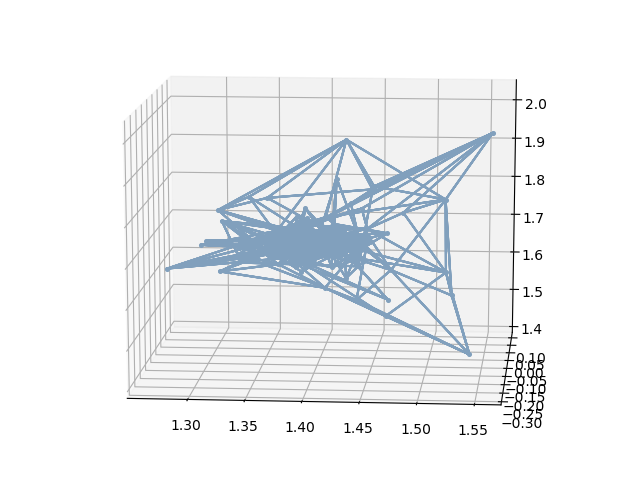

In [279]:
# Initiate a cubical complex
HC, bV = cube_to_drop_init(refinements=2)

#for i in range(150):
for i in range(500):
    HC = mean_flow(HC, bV, m_0, tau=0.01)
    for j in range(10):
        HC = regularize(HC, bV)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

V_eq = 1.0
V_current = 1.0
V_eq = 1.0
V_current = 0.9984409712401437
V_eq = 1.0
V_current = 0.9969121611683254
V_eq = 1.0
V_current = 0.9954130222690023
V_eq = 1.0
V_current = 0.9939430183890307
V_eq = 1.0
V_current = 0.9925016244466187
V_eq = 1.0
V_current = 0.9910883261492222
V_eq = 1.0
V_current = 0.9897026197200711
V_eq = 1.0
V_current = 0.9883440116330212
V_eq = 1.0
V_current = 0.9870120183554439
V_eq = 1.0
V_current = 0.9857061660988718
V_eq = 1.0
V_current = 0.9844259905771429
V_eq = 1.0
V_current = 0.98317103677177
V_eq = 1.0
V_current = 0.9819408587043048
V_eq = 1.0
V_current = 0.9807350192154467
V_eq = 1.0
V_current = 0.9795530897506723
V_eq = 1.0
V_current = 0.9783946501521642
V_eq = 1.0
V_current = 0.9772592884568301
V_eq = 1.0
V_current = 0.9761466007002024
V_eq = 1.0
V_current = 0.975056190726026
V_eq = 1.0
V_current = 0.9739876700013467
V_eq = 1.0
V_current = 0.972940657436911
V_eq = 1.0
V_current = 0.9719147792127122
V_eq = 1.0
V_current = 0.9709096686085039
V_eq = 1.0


V_eq = 1.0
V_current = 0.9383847829984416
V_eq = 1.0
V_current = 0.9385090088066947
V_eq = 1.0
V_current = 0.9386336396229155
V_eq = 1.0
V_current = 0.9387586523329322
V_eq = 1.0
V_current = 0.9388840241876553
V_eq = 1.0
V_current = 0.939009732798648
V_eq = 1.0
V_current = 0.9391357561337578
V_eq = 1.0
V_current = 0.9392620725128183
V_eq = 1.0
V_current = 0.9393886606034109
V_eq = 1.0
V_current = 0.939515499416692
V_eq = 1.0
V_current = 0.9396425683032806
V_eq = 1.0
V_current = 0.939769846949209
V_eq = 1.0
V_current = 0.9398973153719296
V_eq = 1.0
V_current = 0.9400249539163853
V_eq = 1.0
V_current = 0.9401527432511324
V_eq = 1.0
V_current = 0.9402806643645248
V_eq = 1.0
V_current = 0.9404086985609502
V_eq = 1.0
V_current = 0.9405368274571241
V_eq = 1.0
V_current = 0.9406650329784342
V_eq = 1.0
V_current = 0.94079329735534
V_eq = 1.0
V_current = 0.9409216031198238
V_eq = 1.0
V_current = 0.941049933101889
V_eq = 1.0
V_current = 0.9411782704261135
V_eq = 1.0
V_current = 0.941306598508247

V_eq = 1.0
V_current = 0.956638012952692
V_eq = 1.0
V_current = 0.9566779585130085
V_eq = 1.0
V_current = 0.9567174446114411
V_eq = 1.0
V_current = 0.9567564745370295
V_eq = 1.0
V_current = 0.9567950515825774
V_eq = 1.0
V_current = 0.9568331790440712
V_eq = 1.0
V_current = 0.9568708602201036
V_eq = 1.0
V_current = 0.9569080984113122
V_eq = 1.0
V_current = 0.9569448969198256
V_eq = 1.0
V_current = 0.9569812590487193
V_eq = 1.0
V_current = 0.9570171881014821
V_eq = 1.0
V_current = 0.9570526873814916
V_eq = 1.0
V_current = 0.9570877601915014
V_eq = 1.0
V_current = 0.9571224098331346
V_eq = 1.0
V_current = 0.9571566396063901
V_eq = 1.0
V_current = 0.9571904528091569
V_eq = 1.0
V_current = 0.957223852736738
V_eq = 1.0
V_current = 0.9572568426813831
V_eq = 1.0
V_current = 0.9572894259318314
V_eq = 1.0
V_current = 0.9573216057728642
V_eq = 1.0
V_current = 0.9573533854848639
V_eq = 1.0
V_current = 0.9573847683433855
V_eq = 1.0
V_current = 0.9574157576187349
V_eq = 1.0
V_current = 0.95744635657

V_eq = 1.0
V_current = 0.9592218039116941
V_eq = 1.0
V_current = 0.9592218318231348
V_eq = 1.0
V_current = 0.95922181932178
V_eq = 1.0
V_current = 0.9592217671700428
V_eq = 1.0
V_current = 0.9592216761206945
V_eq = 1.0
V_current = 0.9592215469169542
V_eq = 1.0
V_current = 0.9592213802925769
V_eq = 1.0
V_current = 0.9592211769719428
V_eq = 1.0
V_current = 0.959220937670143
V_eq = 1.0
V_current = 0.9592206630930695
V_eq = 1.0
V_current = 0.9592203539375018
V_eq = 1.0
V_current = 0.9592200108911911
V_eq = 1.0
V_current = 0.9592196346329506
V_eq = 1.0
V_current = 0.9592192258327376
V_eq = 1.0
V_current = 0.9592187851517417
V_eq = 1.0
V_current = 0.9592183132424684
V_eq = 1.0
V_current = 0.9592178107488238
V_eq = 1.0
V_current = 0.9592172783061995
V_eq = 1.0
V_current = 0.9592167165415547
V_eq = 1.0
V_current = 0.9592161260735012
V_eq = 1.0
V_current = 0.9592155075123849
V_eq = 1.0
V_current = 0.9592148614603694
V_eq = 1.0
V_current = 0.9592141885115159
V_eq = 1.0
V_current = 0.959213489251

V_eq = 1.0
V_current = 0.9589922789828793
V_eq = 1.0
V_current = 0.9589912801141368
V_eq = 1.0
V_current = 0.9589902881650102
V_eq = 1.0
V_current = 0.9589893031379905
V_eq = 1.0
V_current = 0.9589883250348867
V_eq = 1.0
V_current = 0.9589873538568375
V_eq = 1.0
V_current = 0.9589863896043269
V_eq = 1.0
V_current = 0.9589854322771938
V_eq = 1.0
V_current = 0.9589844818746447
V_eq = 1.0
V_current = 0.9589835383952691
V_eq = 1.0
V_current = 0.9589826018370474
V_eq = 1.0
V_current = 0.9589816721973657
V_eq = 1.0
V_current = 0.9589807494730259
V_eq = 1.0
V_current = 0.9589798336602579
V_eq = 1.0
V_current = 0.9589789247547312
V_eq = 1.0
V_current = 0.958978022751566
V_eq = 1.0
V_current = 0.9589771276453437
V_eq = 1.0
V_current = 0.958976239430119
V_eq = 1.0
V_current = 0.9589753580994292
V_eq = 1.0
V_current = 0.9589744836463061
V_eq = 1.0
V_current = 0.9589736160632863
V_eq = 1.0
V_current = 0.9589727553424199
V_eq = 1.0
V_current = 0.9589719014752841
V_eq = 1.0
V_current = 0.95897105445

V_eq = 1.0
V_current = 0.9589110242307851
V_eq = 1.0
V_current = 0.9589110658046743
V_eq = 1.0
V_current = 0.958911110616986
V_eq = 1.0
V_current = 0.9589111586497486
V_eq = 1.0
V_current = 0.9589112098850797
V_eq = 1.0
V_current = 0.9589112643051868
V_eq = 1.0
V_current = 0.9589113218923687
V_eq = 1.0
V_current = 0.9589113826290134
V_eq = 1.0
V_current = 0.9589114464975994
V_eq = 1.0
V_current = 0.9589115134806955
V_eq = 1.0
V_current = 0.9589115835609615
V_eq = 1.0
V_current = 0.9589116567211468
V_eq = 1.0
V_current = 0.9589117329440908
V_eq = 1.0
V_current = 0.9589118122127238
V_eq = 1.0
V_current = 0.9589118945100661
V_eq = 1.0
V_current = 0.9589119798192277
V_eq = 1.0
V_current = 0.958912068123409
V_eq = 1.0
V_current = 0.9589121594059006
V_eq = 1.0
V_current = 0.9589122536500826
V_eq = 1.0
V_current = 0.9589123508394257


<IPython.core.display.Javascript object>


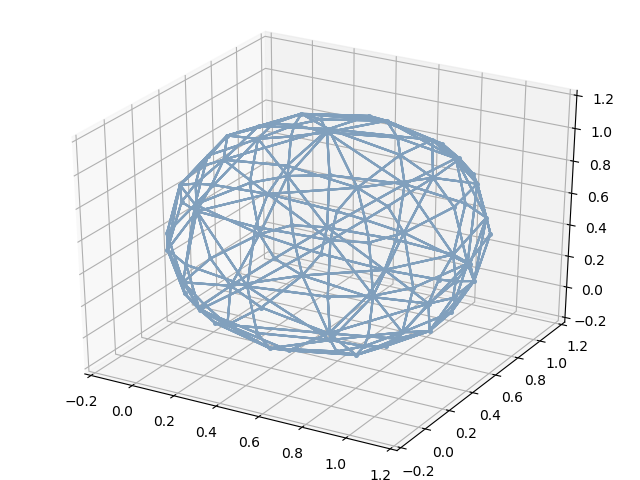

In [280]:
# Initiate a cubical complex
HC, bV = cube_to_drop_init(refinements=2)

#for i in range(150):
for i in range(1000):
    HC = mean_flow(HC, bV, m_0, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

V_eq = 1.0
V_current = 1.0
V_eq = 1.0
V_current = 0.9859478350696244
V_eq = 1.0
V_current = 0.9724030921530026
V_eq = 1.0
V_current = 0.95916704200157
V_eq = 1.0
V_current = 0.9462015358752714
V_eq = 1.0
V_current = 0.9338783567315184
V_eq = 1.0
V_current = 0.9223058845920629
V_eq = 1.0
V_current = 0.9113603745302735
V_eq = 1.0
V_current = 0.9010437601332288
V_eq = 1.0
V_current = 0.8913476636100112
V_eq = 1.0
V_current = 0.8822564561376284
V_eq = 1.0
V_current = 0.8737499483578751
V_eq = 1.0
V_current = 0.8658046228095152
V_eq = 1.0
V_current = 0.8591605415887805
V_eq = 1.0
V_current = 0.8519306167190402
V_eq = 1.0
V_current = 0.8461453588573261
V_eq = 1.0
V_current = 0.839607989750813
V_eq = 1.0
V_current = 0.8335989945619571
V_eq = 1.0
V_current = 0.829130214332123
V_eq = 1.0
V_current = 0.8237035448936759
V_eq = 1.0
V_current = 0.8187524682908488
V_eq = 1.0
V_current = 0.8154029523841214
V_eq = 1.0
V_current = 0.8109253425186318
V_eq = 1.0
V_current = 0.8081210285064585
V_eq = 1.0


V_eq = 1.0
V_current = 0.8798343673672582
V_eq = 1.0
V_current = 0.8818799465103128
V_eq = 1.0
V_current = 0.8838700103825677
V_eq = 1.0
V_current = 0.8846120926627346
V_eq = 1.0
V_current = 0.8866055714781425
V_eq = 1.0
V_current = 0.8873041927089939
V_eq = 1.0
V_current = 0.889292079298604
V_eq = 1.0
V_current = 0.8912192284661674
V_eq = 1.0
V_current = 0.8918345181535606
V_eq = 1.0
V_current = 0.8937690120236375
V_eq = 1.0
V_current = 0.8956424257169019
V_eq = 1.0
V_current = 0.8961755431905304
V_eq = 1.0
V_current = 0.8980635722678684
V_eq = 1.0
V_current = 0.8998887647270305
V_eq = 1.0
V_current = 0.9016600035028196
V_eq = 1.0
V_current = 0.9020706809572699
V_eq = 1.0
V_current = 0.9038769344890111
V_eq = 1.0
V_current = 0.9056205894225027
V_eq = 1.0
V_current = 0.9073110861392473
V_eq = 1.0
V_current = 0.908955702213916
V_eq = 1.0
V_current = 0.9089922403085245
V_eq = 1.0
V_current = 0.9107159209817707
V_eq = 1.0
V_current = 0.9123659360934632
V_eq = 1.0
V_current = 0.91373644448

V_eq = 1.0
V_current = 0.7179399336053308
V_eq = 1.0
V_current = 0.7142664011603682
V_eq = 1.0
V_current = 0.7130779849779604
V_eq = 1.0
V_current = 0.7116341586759743
V_eq = 1.0
V_current = 0.7080765432503564
V_eq = 1.0
V_current = 0.7069122631809109
V_eq = 1.0
V_current = 0.7055280176552765
V_eq = 1.0
V_current = 0.7039732054191569
V_eq = 1.0
V_current = 0.7004874955758768
V_eq = 1.0
V_current = 0.699291171029345
V_eq = 1.0
V_current = 0.6979294451282412
V_eq = 1.0
V_current = 0.6964414654764127
V_eq = 1.0
V_current = 0.6931581495093496
V_eq = 1.0
V_current = 0.6920551346100772
V_eq = 1.0
V_current = 0.6908131697650641
V_eq = 1.0
V_current = 0.6894668665259207
V_eq = 1.0
V_current = 0.6880458082951667
V_eq = 1.0
V_current = 0.6868043742272261
V_eq = 1.0
V_current = 0.6855925532802735
V_eq = 1.0
V_current = 0.6843125611832361
V_eq = 1.0
V_current = 0.68298708465314
V_eq = 1.0
V_current = 0.6816350995309413
V_eq = 1.0
V_current = 0.6802723898088847
V_eq = 1.0
V_current = 0.678912018562

V_eq = 1.0
V_current = 0.875439713082152
V_eq = 1.0
V_current = 0.8747391956147417
V_eq = 1.0
V_current = 0.8769751784848746
V_eq = 1.0
V_current = 0.8762042675474212
V_eq = 1.0
V_current = 0.8784121582247981
V_eq = 1.0
V_current = 0.8775747606317085
V_eq = 1.0
V_current = 0.879758121922496
V_eq = 1.0
V_current = 0.8788570273346386
V_eq = 1.0
V_current = 0.8810185422103873
V_eq = 1.0
V_current = 0.8800556491644748
V_eq = 1.0
V_current = 0.8794606011008561
V_eq = 1.0
V_current = 0.8816761045973568
V_eq = 1.0
V_current = 0.8807417577432867
V_eq = 1.0
V_current = 0.882923948549589
V_eq = 1.0
V_current = 0.8819119547824039
V_eq = 1.0
V_current = 0.8812706212692651
V_eq = 1.0
V_current = 0.8834953193072589
V_eq = 1.0
V_current = 0.8824968781602832
V_eq = 1.0
V_current = 0.8818574311165737
V_eq = 1.0
V_current = 0.8841090873347407
V_eq = 1.0
V_current = 0.8831059316015574
V_eq = 1.0
V_current = 0.885308933410636
V_eq = 1.0
V_current = 0.8842075862478974
V_eq = 1.0
V_current = 0.8834887279324

V_eq = 1.0
V_current = 0.732483190176763
V_eq = 1.0
V_current = 0.7342820450307918
V_eq = 1.0
V_current = 0.7358671529603583
V_eq = 1.0
V_current = 0.7357561747882139
V_eq = 1.0
V_current = 0.7376013258124371
V_eq = 1.0
V_current = 0.7392339112729293
V_eq = 1.0
V_current = 0.7391640511745149
V_eq = 1.0
V_current = 0.741033921786843
V_eq = 1.0
V_current = 0.7427490873887063
V_eq = 1.0
V_current = 0.7444291885426235
V_eq = 1.0
V_current = 0.7443777821295593
V_eq = 1.0
V_current = 0.746275437554556
V_eq = 1.0
V_current = 0.7480072928423378
V_eq = 1.0
V_current = 0.7496956552172002
V_eq = 1.0
V_current = 0.7496292600489097
V_eq = 1.0
V_current = 0.751284097072762
V_eq = 1.0
V_current = 0.7528043244755244
V_eq = 1.0
V_current = 0.7543582874851498
V_eq = 1.0
V_current = 0.7559390336897912
V_eq = 1.0
V_current = 0.7574741133066504
V_eq = 1.0
V_current = 0.7591128186490633
V_eq = 1.0
V_current = 0.7605480998774596
V_eq = 1.0
V_current = 0.7620233573814376
V_eq = 1.0
V_current = 0.7634693698827

V_eq = 1.0
V_current = 0.9000457377682531
V_eq = 1.0
V_current = 0.8981823010541339
V_eq = 1.0
V_current = 0.899460931860992
V_eq = 1.0
V_current = 0.8978336297359482
V_eq = 1.0
V_current = 0.8992295702175895
V_eq = 1.0
V_current = 0.897574055977763
V_eq = 1.0
V_current = 0.8989470080555377
V_eq = 1.0
V_current = 0.8972849473195373
V_eq = 1.0
V_current = 0.8986512263516176
V_eq = 1.0
V_current = 0.8969944613077638
V_eq = 1.0
V_current = 0.8983632877813593
V_eq = 1.0
V_current = 0.8967177489953263
V_eq = 1.0
V_current = 0.8980940069836311
V_eq = 1.0
V_current = 0.8964622090418586
V_eq = 1.0
V_current = 0.8980696447594615
V_eq = 1.0
V_current = 0.8994920324917234
V_eq = 1.0
V_current = 0.9009799561781041
V_eq = 1.0
V_current = 0.9020900962495769
V_eq = 1.0
V_current = 0.8998681221886051
V_eq = 1.0
V_current = 0.9011396507865883


<IPython.core.display.Javascript object>


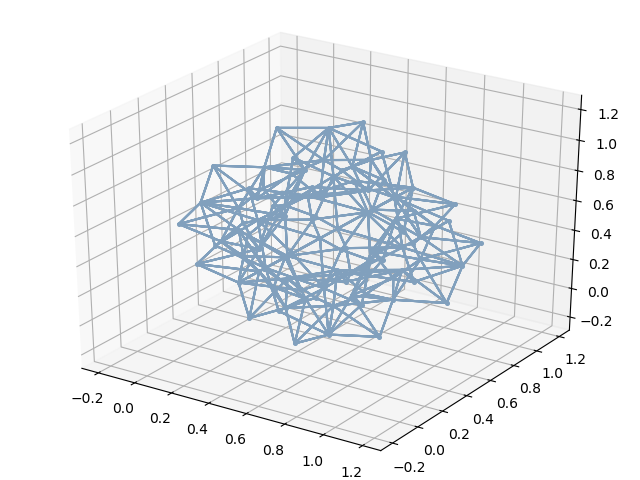

In [281]:
# Initiate a cubical complex
HC, bV = cube_to_drop_init(refinements=2)

#for i in range(150):
for i in range(1000):
    HC = mean_flow(HC, bV, m_0, tau=0.001)
    for j in range(1):
        HC = regularize(HC, bV)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

V_eq = 1.0
V_current = 1.0
V_eq = 1.0
V_current = 0.9984409712401437
V_eq = 1.0
V_current = 0.9969394988970643
V_eq = 1.0
V_current = 0.9954935318629721
V_eq = 1.0
V_current = 0.9941010976751907
V_eq = 1.0
V_current = 0.9927602990977943
V_eq = 1.0
V_current = 0.9914693108766386
V_eq = 1.0
V_current = 0.9902263766575611
V_eq = 1.0
V_current = 0.9890298060582157
V_eq = 1.0
V_current = 0.9878779718846405
V_eq = 1.0
V_current = 0.9867693074842382
V_eq = 1.0
V_current = 0.9857023042273907
V_eq = 1.0
V_current = 0.9846755091104376
V_eq = 1.0
V_current = 0.9836875224732163
V_eq = 1.0
V_current = 0.9827369958247875
V_eq = 1.0
V_current = 0.9818226297713782
V_eq = 1.0
V_current = 0.9809431720409623
V_eq = 1.0
V_current = 0.9800974155992156
V_eq = 1.0
V_current = 0.9792841968519436
V_eq = 1.0
V_current = 0.9785023939293603
V_eq = 1.0
V_current = 0.9777509250478764
V_eq = 1.0
V_current = 0.9770287469453409
V_eq = 1.0
V_current = 0.976334853385893
V_eq = 1.0
V_current = 0.9756682737308351
V_eq = 1

V_eq = 1.0
V_current = 0.9709402350244591
V_eq = 1.0
V_current = 0.9710277199961271
V_eq = 1.0
V_current = 0.9711145486927247
V_eq = 1.0
V_current = 0.9712007280501475
V_eq = 1.0
V_current = 0.9712862647877314
V_eq = 1.0
V_current = 0.9713711654157434
V_eq = 1.0
V_current = 0.9714554362426555
V_eq = 1.0
V_current = 0.971539083382187
V_eq = 1.0
V_current = 0.9716221127601371
V_eq = 1.0
V_current = 0.9717045301210084
V_eq = 1.0
V_current = 0.9717863410344276
V_eq = 1.0
V_current = 0.97186755090137
V_eq = 1.0
V_current = 0.9719481649601952
V_eq = 1.0
V_current = 0.9720281882925003
V_eq = 1.0
V_current = 0.9721076258287886
V_eq = 1.0
V_current = 0.972186482353972
V_eq = 1.0
V_current = 0.9722647625126996
V_eq = 1.0
V_current = 0.9723424708145291
V_eq = 1.0
V_current = 0.9724196116389338
V_eq = 1.0
V_current = 0.9724961892401617
V_eq = 1.0
V_current = 0.9725722077519413
V_eq = 1.0
V_current = 0.9726476711920484
V_eq = 1.0
V_current = 0.9727225834667266
V_eq = 1.0
V_current = 0.9727969483749

V_eq = 1.0
V_current = 0.9794066512695817
V_eq = 1.0
V_current = 0.9794187699402307
V_eq = 1.0
V_current = 0.9794307049879921
V_eq = 1.0
V_current = 0.9794424582666124
V_eq = 1.0
V_current = 0.979454031621001
V_eq = 1.0
V_current = 0.9794654268871152
V_eq = 1.0
V_current = 0.9794766458918502
V_eq = 1.0
V_current = 0.979487690452928
V_eq = 1.0
V_current = 0.979498562378795
V_eq = 1.0
V_current = 0.9795092634685165
V_eq = 1.0
V_current = 0.9795197955116793
V_eq = 1.0
V_current = 0.979530160288295
V_eq = 1.0
V_current = 0.9795403595687052
V_eq = 1.0
V_current = 0.9795503951134926
V_eq = 1.0
V_current = 0.9795602686733919
V_eq = 1.0
V_current = 0.9795699819892061
V_eq = 1.0
V_current = 0.9795795367917242
V_eq = 1.0
V_current = 0.9795889348016428
V_eq = 1.0
V_current = 0.97959817772949
V_eq = 1.0
V_current = 0.9796072672755515
V_eq = 1.0
V_current = 0.9796162051298007
V_eq = 1.0
V_current = 0.9796249929718327
V_eq = 1.0
V_current = 0.9796336324707976
V_eq = 1.0
V_current = 0.979642125285338

V_eq = 1.0
V_current = 0.9799508464925942
V_eq = 1.0
V_current = 0.97994988722853
V_eq = 1.0
V_current = 0.9799489228292645
V_eq = 1.0
V_current = 0.9799479535088224
V_eq = 1.0
V_current = 0.9799469794776875
V_eq = 1.0
V_current = 0.9799460009428477
V_eq = 1.0
V_current = 0.9799450181078354
V_eq = 1.0
V_current = 0.9799440311727737
V_eq = 1.0
V_current = 0.9799430403344171
V_eq = 1.0
V_current = 0.9799420457861939
V_eq = 1.0
V_current = 0.9799410477182476
V_eq = 1.0
V_current = 0.9799400463174782
V_eq = 1.0
V_current = 0.979939041767584
V_eq = 1.0
V_current = 0.9799380342491024
V_eq = 1.0
V_current = 0.9799370239394481
V_eq = 1.0
V_current = 0.979936011012955
V_eq = 1.0
V_current = 0.9799349956409147
V_eq = 1.0
V_current = 0.9799339779916161
V_eq = 1.0
V_current = 0.9799329582303836
V_eq = 1.0
V_current = 0.9799319365196152
V_eq = 1.0
V_current = 0.9799309130188222
V_eq = 1.0
V_current = 0.9799298878846647
V_eq = 1.0
V_current = 0.9799288612709899
V_eq = 1.0
V_current = 0.9799278333288

V_eq = 1.0
V_current = 0.979793141189469
V_eq = 1.0
V_current = 0.9797927327483559
V_eq = 1.0
V_current = 0.9797923283990957
V_eq = 1.0
V_current = 0.9797919281265695
V_eq = 1.0
V_current = 0.9797915319155784
V_eq = 1.0
V_current = 0.9797911397508473
V_eq = 1.0
V_current = 0.9797907516170284
V_eq = 1.0
V_current = 0.9797903674987037
V_eq = 1.0
V_current = 0.9797899873803887
V_eq = 1.0
V_current = 0.9797896112465345
V_eq = 1.0
V_current = 0.9797892390815317
V_eq = 1.0
V_current = 0.9797888708697126
V_eq = 1.0
V_current = 0.9797885065953543
V_eq = 1.0
V_current = 0.979788146242682
V_eq = 1.0
V_current = 0.979787789795869
V_eq = 1.0
V_current = 0.9797874372390446
V_eq = 1.0
V_current = 0.9797870885562916
V_eq = 1.0
V_current = 0.9797867437316512
V_eq = 1.0
V_current = 0.979786402749126
V_eq = 1.0
V_current = 0.9797860655926809
V_eq = 1.0
V_current = 0.9797857322462469
V_eq = 1.0
V_current = 0.9797854026937224
V_eq = 1.0
V_current = 0.9797850769189772
V_eq = 1.0
V_current = 0.9797847549058

V_eq = 1.0
V_current = 0.9797722879231864
V_eq = 1.0
V_current = 0.9797723988990503
V_eq = 1.0
V_current = 0.97977251135589
V_eq = 1.0
V_current = 0.9797726252855653
V_eq = 1.0
V_current = 0.979772740679988
V_eq = 1.0
V_current = 0.9797728575311231
V_eq = 1.0
V_current = 0.9797729758309878
V_eq = 1.0
V_current = 0.9797730955716516
V_eq = 1.0
V_current = 0.9797732167452353
V_eq = 1.0
V_current = 0.9797733393439119
V_eq = 1.0
V_current = 0.9797734633599057
V_eq = 1.0
V_current = 0.9797735887854923
V_eq = 1.0
V_current = 0.9797737156129983
V_eq = 1.0
V_current = 0.9797738438348005
V_eq = 1.0
V_current = 0.9797739734433276
V_eq = 1.0
V_current = 0.979774104431057
V_eq = 1.0
V_current = 0.9797742367905168
V_eq = 1.0
V_current = 0.9797743705142858
V_eq = 1.0
V_current = 0.9797745055949915


<IPython.core.display.Javascript object>


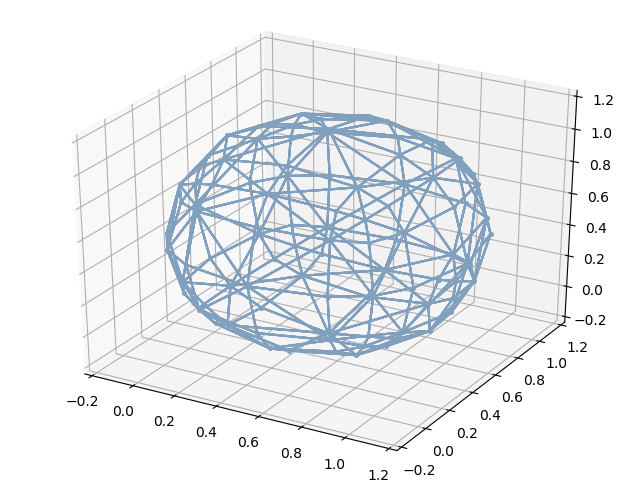

In [284]:
# Initiate a cubical complex
HC, bV = cube_to_drop_init(refinements=2)

#for i in range(150):
for i in range(1000):
    HC = mean_flow(HC, bV, m_0, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

<IPython.core.display.Javascript object>


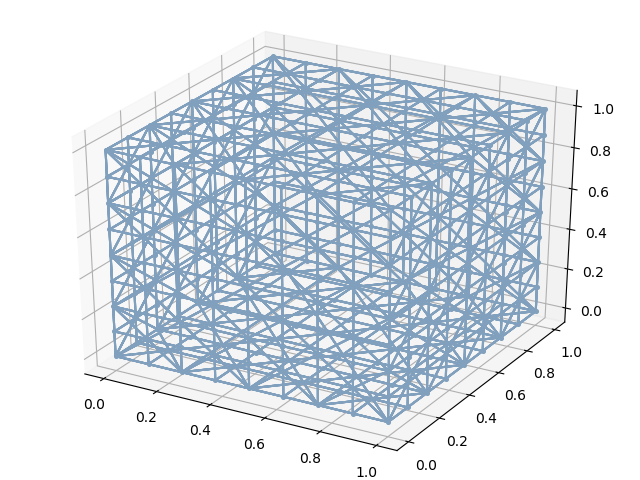

In [8]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(3):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

In [9]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(2):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(1):
    HC = willmore_flow(HC, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


ValueError: operands could not be broadcast together with shapes (98,3) (98,) 

<IPython.core.display.Javascript object>


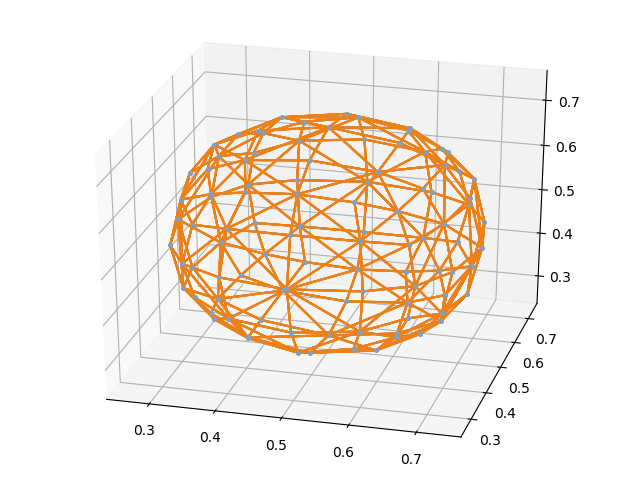

In [10]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(2):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(100):
    HC = mean_flow(HC, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           
                                           complex_color_e=db
                                           )

<IPython.core.display.Javascript object>


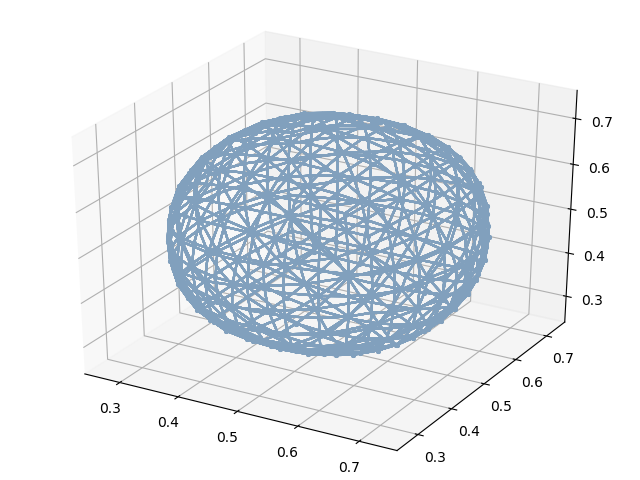

In [11]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(3):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(100):
    HC = mean_flow(HC, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           
                                           complex_color_e=db
                                           )

C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_curvatures.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / np.tan(theta)
C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_curvatures.py:222: RuntimeWarning: invalid value encountered in multiply
  HNdA_ij[j] = (cotan(alpha_ij) + cotan(beta_ij)) * (F[j] - F[i])
C:\Users\Endres\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_curvatures.py:210: RuntimeWarning: invalid value encountered in arccos
  alpha_ij = np.arccos((a ** 2 + b ** 2 - c ** 2) / (2 * a * b))


<IPython.core.display.Javascript object>


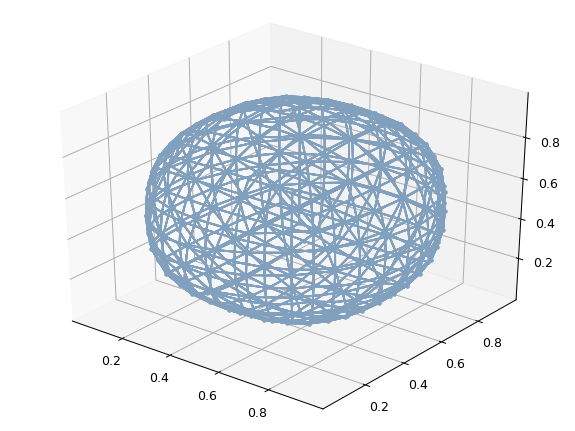

In [25]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(3):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(50):
    HC = mean_flow(HC, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           
                                           complex_color_e=db
                                           )

<IPython.core.display.Javascript object>


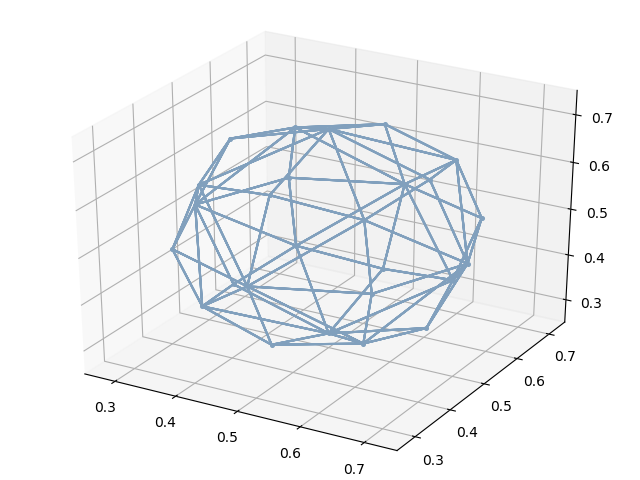

In [16]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(1):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(100):
    HC = mean_flow(HC, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           
                                           complex_color_e=db
                                           )

Gauss Bonnet
==

In [64]:
def chi_H(HC, print_out=True):
    """
    Compute the 2D Euler Characterisitc
    """
    ## Computer Euler Characteristic:
    # Compute the number of vertices
    V = len(list(HC.V))
    # Compute the dges
    E = 0
    for v in HC.V:
        E += len(list(v.nn))
        
    E = E/2.0 # We have added precisely twice the number of edges through adding each connection
    # Compute the faces
    HC.dim = 2  # We have taken the boundary of the sphere
    HC.vertex_face_mesh()
    Faces = HC.simplices_fm
    F = len(Faces)
    
    # Compute Euler
    chi = V - E + F
    if print_out:
        print(f'V = {V}')
        print(f'E = {E}')
        print(f'F = {F}')
        print(f'$\chi = V - E + F$ = {chi}')   
        
    return chi

def K_t(HC, bV=set()):
    """
    Compute the integrated Gaussian curvature on the surface 
    """
    KdA = 0.0
    for v in HC.V:
        if v in bV:
            continue
        else:
            N_f0 = v.x_a - np.zeros_like(v.x_a)  # First approximation # TODO: CHANGE FOR CAP RISE!
            F, nn = vectorise_vnn(v)
            # Compute discrete curvatures
            c_outd = curvatures(F, nn, n_i=N_f0)
            KdA += c_outd['Omega_i']  # == c_outd['K']
            
    return KdA
    
def k_g_t(HC, bV):
    k_g = 0
    for v in bV:
        Theta_i_jk = 0.0
        Simplices = set()
        Dual = set()
        for vn in v.nn:
            if vn in Dual:
                continue
            for vnn in vn.nn:
                if vnn in v.nn:  # Add edges connected to v_i
                    E_ij = vn.x_a - v.x_a
                    E_ik = vnn.x_a - v.x_a
                    
                    # Discrete vector area:
                    # Simplex areas of ijk and normals
                    wedge_ij_ik = np.cross(E_ij, E_ik)

                    #Wedge_ij_ik[j] = wedge_ij_ik
                    theta_i_jk = np.arctan2(np.linalg.norm(wedge_ij_ik), np.dot(E_ij, E_ik))
                    Theta_i_jk += theta_i_jk
                    Dual.add(vnn)

        k_g += np.pi - Theta_i_jk
        
    return k_g

def Gauss_Bonnet(HC, bV=set()):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :return:
    """
    chi = chi_H(HC)
    KdA = K_t(HC, bV)
    k_g = k_g_t(HC, bV)
    print(f' KdA = {KdA}')
    print(f' k_g = {k_g}')
    print(f' 2 pi chi$ = {2 * np.pi * chi}')
    print(f' LHS - RHS = {KdA + k_g - 2 * np.pi * chi}')
    return chi, KdA

Gauss_Bonnet(HC)

V = 26
E = 72.0
F = 48
$\chi = V - E + F$ = 2.0
 KdA = 12.566370614359169
 k_g = 0
 2 pi chi$ = 12.566370614359172
 LHS - RHS = -3.552713678800501e-15


(2.0, 12.566370614359169)